In [1]:
from fmri_preprocessing import vectorized_correlation
from utils import find_repo_root
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os
from sklearn.preprocessing import StandardScaler
import pickle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

### Function Definitions

In [2]:
def load_dict(filename_):
    with open(filename_, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        ret_di = u.load()
    return ret_di

In [3]:


# fast linear regression function with Pytorch (taken from CCN2021_Algonauts.ipynb)
# class OLS_pytorch(object):
#     def __init__(self,use_gpu=False):
#         self.coefficients = []
#         self.use_gpu = use_gpu
#         self.X = None
#         self.y = None
# 
#     def fit(self,X,y):
#         if len(X.shape) == 1:
#             X = self._reshape_x(X)
#         if len(y.shape) == 1:
#             y = self._reshape_x(y)
# 
#         X =  self._concatenate_ones(X)
# 
#         X = torch.from_numpy(X).float()
#         y = torch.from_numpy(y).float()
#         if self.use_gpu:
#             X = X.cuda()
#             y = y.cuda()
#         XtX = torch.matmul(X.t(),X)
#         Xty = torch.matmul(X.t(),y.unsqueeze(2))
#         XtX = XtX.unsqueeze(0)
#         XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
#         betas_cholesky, _ = torch.solve(Xty, XtX)
# 
#         self.coefficients = betas_cholesky
# 
#     def predict(self, entry):
#         if len(entry.shape) == 1:
#             entry = self._reshape_x(entry)
#         entry =  self._concatenate_ones(entry)
#         entry = torch.from_numpy(entry).float()
#         if self.use_gpu:
#             entry = entry.cuda()
#         prediction = torch.matmul(entry,self.coefficients)
#         prediction = prediction.cpu().numpy()
#         prediction = np.squeeze(prediction).T
#         return prediction
# 
#     def _reshape_x(self,X):
#         return X.reshape(-1,1)
# 
#     def _concatenate_ones(self,X):
#         ones = np.ones(shape=X.shape[0]).reshape(-1,1)
#         return np.concatenate((ones,X),1)

# def predict_fmri_fast(train_activations, test_activations, train_fmri,use_gpu=False):
#     """This function fits a linear regressor using train_activations and train_fmri,
#     then returns the predicted fmri_pred_test using the fitted weights and
#     test_activations.
#     Parameters
#     ----------
#     train_activations : np.array
#         matrix of dimensions #train_vids x #pca_components
#         containing activations of train videos.
#     test_activations : np.array
#         matrix of dimensions #test_vids x #pca_components
#         containing activations of test videos
#     train_fmri : np.array
#         matrix of dimensions #train_vids x  #voxels
#         containing fMRI responses to train videos
#     use_gpu : bool
#         whether to use gpu or not.
#     Returns
#     -------
#     fmri_pred_test: np.array
#         matrix of dimensions #test_vids x  #voxels
#         containing predicted fMRI responses to test videos .
#     """
# 
#     reg = OLS_pytorch(use_gpu)
#     reg.fit(train_activations,train_fmri.T)
#     fmri_pred_test = reg.predict(test_activations)
#     return fmri_pred_test

In [4]:
def get_fmri(fmri_dir, ROI):
    """This function loads fMRI data into a numpy array for to a given ROI.
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data. Relates to a specific subject.
    ROI : str
        name of ROI.
    Returns
    -------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI
    """

    # Loading ROI data
    # ToDo: if necessary, adjust path as soon as preprocessing is done
    ROI_file = os.path.join(fmri_dir, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    # Todo: Check if this step is done by the preprocessing from Marcel
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)
    if ROI == "WB":
        voxel_mask = ROI_data['voxel_mask']
        return ROI_data_train, voxel_mask

    return ROI_data_train

In [5]:
# Dense Layer
def train_model(X_train, X_val, y_train, y_val, num_epochs = 1, visualize_results = True):
    """
    conducts the training for a particular layer, subject & ROI. saves model.
    :param X_train: training data (feature map PCs from first 800 videos from a particular layer)
    :param X_val: validation data (feature map PCs from videos 801-900 from a particular layer)
    :param y_train: training labels (scans for first 800 videos for the particular subject & ROI)
    :param y_val: training labels (scans for videos 801-900 for the particular subject & ROI)
    :param num_epochs: number of epochs for training
    :return: model parameters & validation accuracy
    """
    
    # flatten X data over 2nd and 3rd dimension
    X_train = X_train.reshape(800, -1)
    X_val =  X_val.reshape(100, -1)

    print("X_train shape: ", X_train.shape)
    print("y_train shape: ", y_train.shape)
    print("X_val shape: ", X_val.shape)
    print("y_val shape: ", y_val.shape)
    # specify number of neurons per layer, depending on the number of inputs from a particular layer and number of output voxels
    input_neurons = X_train.shape[1]
    hidden1_neurons = y_train.shape[1] + (X_train.shape[1] - y_train.shape[1])*(2/3)
    hidden2_neurons = y_train.shape[1] + (X_train.shape[1] - y_train.shape[1])*(1/3)
    output_neurons = y_train.shape[1]
    
    # model construction: 2 hidden layers
    model = Sequential([
        Dense(hidden1_neurons, input_shape=(input_neurons,), activation='relu'),
        Dense(hidden2_neurons, activation='relu'),
        Dense(output_neurons)
    ])
    
    # Compiling the model
    adam = Adam(learning_rate=0.001)
    model.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
    
    # ToDo: define the custom evaluation metric (via keras.backend)
    
    # Training the model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_val, y_val))
    
    # print layer overview
    print(model.summary())
    
    # extract validation accuracy
    validation_accuracy = history.history['val_accuracy']
    
    if visualize_results:
        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
        
        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    
    # save the model in a new folder
    models_dir = os.path.join(find_repo_root(), "models", layer, ROI, sub)
    print(models_dir)
    if not os.path.exists(models_dir):
      os.makedirs(models_dir)
    model.save(models_dir)
    
    return model, validation_accuracy

In [6]:
# train-val-test split, fitting linear regression model, visualize voxel predictions
def perform_encoding(pca_dir, fmri_dir, sub, layer, ROI = 'WB', mode = 'val'):
    
    # Load activations (PCA outputs)
    # ToDo: adjust pca_dir to load in all scans per subject & ROI
    # pca_dir = os.path.join("/content/activations" )
    train_activations,test_activations = get_activations(pca_dir, layer)
    
    # Load fMRI data (labels)
    # ToDO: adjust directory as soon as fMRI preprocessing is done
    if ROI == "WB":
      track = "full_track"
    else:
      track = "mini_track"
    fmri_dir = os.path.join(fmri_dir, track)
    sub_fmri_dir = os.path.join(fmri_dir, sub)
    if track == "full_track":
      fmri_train_all,voxel_mask = get_fmri(sub_fmri_dir,ROI)
    else:
      fmri_train_all = get_fmri(sub_fmri_dir,ROI)
    
    print('fmri_train_al', fmri_train_all.shape)
    print('train_activations', train_activations.shape)
    
    # Creating data splits
    if mode == 'val':
      # split labels
      val_activations = train_activations[800:900,:]
      train_activations = train_activations[:800,:]
      
      fmri_train = fmri_train_all[:800,:]
      fmri_val = fmri_train_all[800:900,:]
      
      trained_model, val_acc = train_model(train_activations, val_activations, fmri_train, fmri_val)
    
    else:
        fmri_test = fmri_train_all[900:]
    
    # ToDo: calculate global mean & std_dev
    # mean = np.mean(train_activations, axis=tuple(range(train_activations.ndim)))
    # std_dev = np.std(train_activations, axis=tuple(range(train_activations.ndim)))
    # 
    # # Standardize both test & train data
    # train_activations = (train_activations - mean) / std_dev
    # test_activations = (test_activations - mean) / std_dev

In [7]:
def get_activations(activations_dir, layer):
    """This function loads neural network features/activations (preprocessed using PCA) into a
    numpy array according to a given layer.
    Parameters
    ----------
    activations_dir : str
        Path to PCA processed Neural Network features
    layer_name : str
        which layer of the neural network to load,
    Returns
    -------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    test_activations : np.array
        matrix of dimensions #test_vids x #pca_components
        containing activations of test videos
    """

    
    # numpy arrays of the PCA results
    # @ToDo: adjust after all PCAs are loaded here. Change paths & split in train & test. Currently, no test data is loaded
    
    train_activations = []
    test_activations = [1]
    stage_path = os.path.join(activations_dir, layer)
    print(stage_path)
        # Loop through each file in the folder
    for filename in os.listdir(stage_path):
        file_path = os.path.join(stage_path, filename)
        with open(file_path, 'rb') as file:
            loaded_data = pickle.load(file)
            # Convert loaded data to NumPy array if needed
            if isinstance(loaded_data, np.ndarray):
                # Add a new axis before appending to the list
                loaded_data = loaded_data[np.newaxis, ...]
                train_activations.append(loaded_data)
            else:
                # Convert to array if data is not already in array format
                loaded_data = np.array(loaded_data)
                # Add a new axis before appending to the list
                loaded_data = loaded_data[np.newaxis, ...]
                train_activations.append(loaded_data)
    
    # Concatenate the data along the new axis (axis=0 for a new dimension)
    train_activations = np.concatenate(train_activations, axis=0)
    print(train_activations.shape)
    
    # @Todo: Remove this step after all PCA has been loaded
    train_activations = np.concatenate([train_activations] * 200, axis=0)
    print(train_activations.shape)

    return train_activations, test_activations

### Calculations

Starting ROI:  WB sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 18222)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 18222)
X_val shape:  (100, 900)
y_val shape:  (100, 18222)
25/25 [==============================] - 26s 951ms/step - loss: 64.1383 - accuracy: 0.0000e+00 - val_loss: 0.2195 - val_accuracy: 0.0000e+00
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6674)              6013274   
                                                                 
 dense_1 (Dense)             (None, 12448)             83090400  
                                                                 
 dense_2 (Dense)             (None, 18222)             226845678 
                      

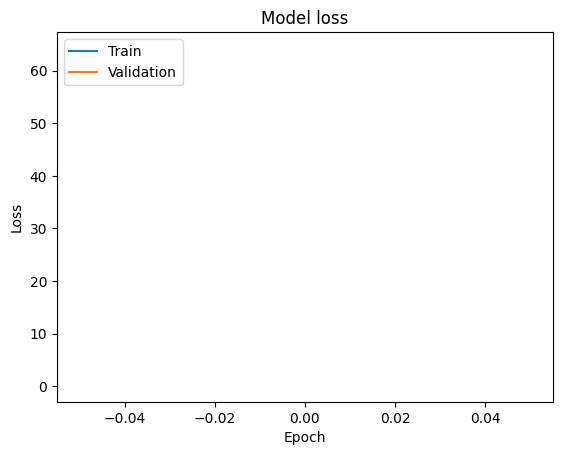

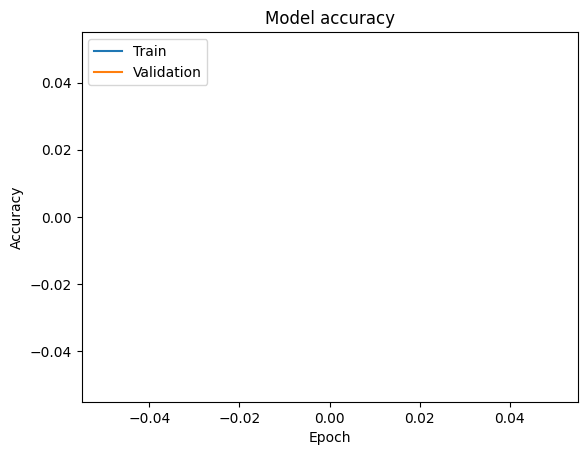

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub01\assets


Completed ROI:  WB sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 232)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 232)
X_val shape:  (100, 900)
y_val shape:  (100, 232)
25/25 [==============================] - 1s 14ms/step - loss: 125.5278 - accuracy: 0.0037 - val_loss: 0.2407 - val_accuracy: 0.0000e+00
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 677)               609977    
                                                                 
 dense_4 (Dense)             (None, 454)               307812    
                                                       

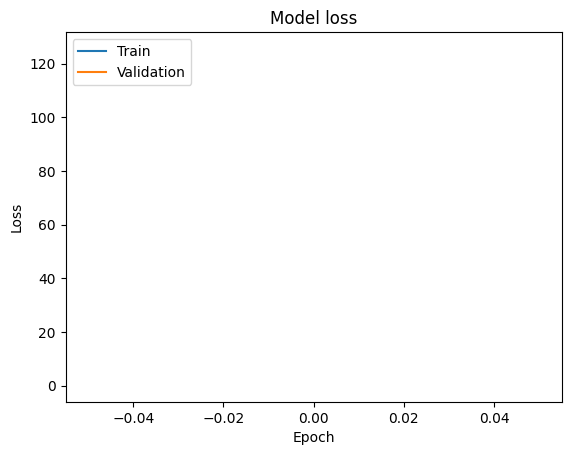

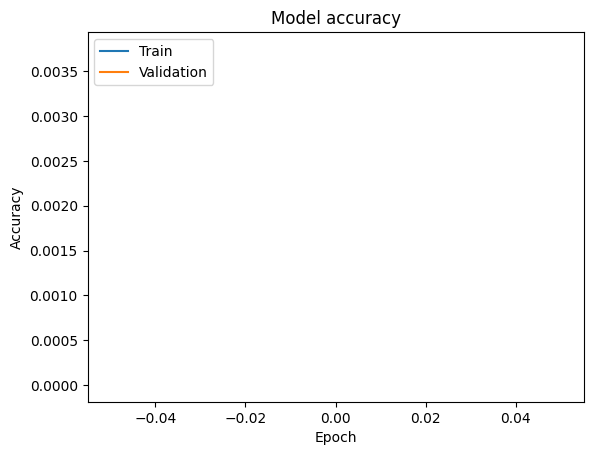

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub01\assets


Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 231)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 231)
X_val shape:  (100, 900)
y_val shape:  (100, 231)
25/25 [==============================] - 1s 14ms/step - loss: 100.2478 - accuracy: 0.0037 - val_loss: 0.2442 - val_accuracy: 0.0000e+00
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 677)               609977    
                                                                 
 dense_7 (Dense)             (None, 454)               307812    
                                                       

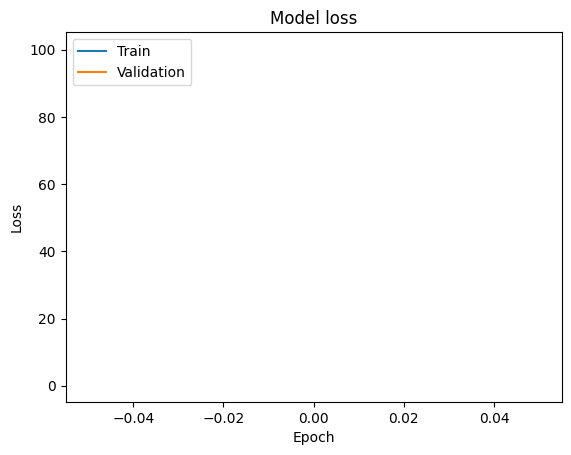

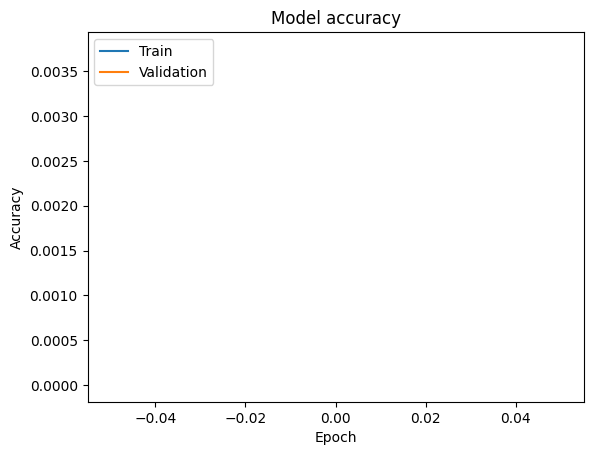

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub01\assets


Completed ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 261)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 261)
X_val shape:  (100, 900)
y_val shape:  (100, 261)
25/25 [==============================] - 1s 15ms/step - loss: 108.4755 - accuracy: 0.0025 - val_loss: 0.2274 - val_accuracy: 0.0000e+00
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 687)               618987    
                                                                 
 dense_10 (Dense)            (None, 474)               326112    
                                                       

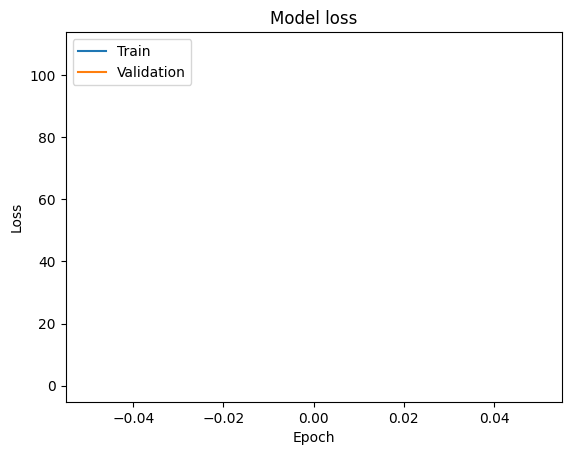

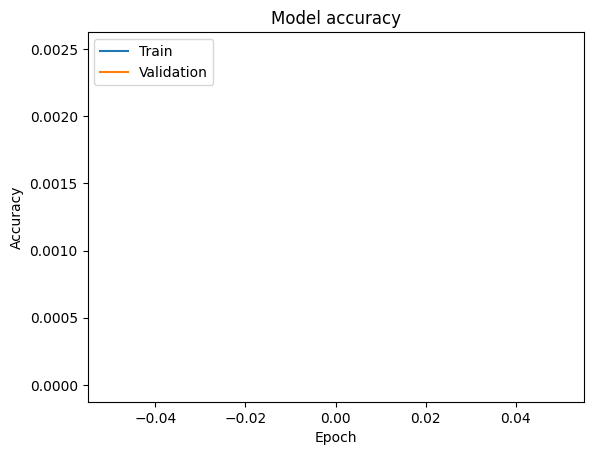

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub01\assets


Completed ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 107)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 107)
X_val shape:  (100, 900)
y_val shape:  (100, 107)
25/25 [==============================] - 1s 14ms/step - loss: 200.9124 - accuracy: 0.0075 - val_loss: 0.2586 - val_accuracy: 0.0200
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 635)               572135    
                                                                 
 dense_13 (Dense)            (None, 371)               235956    
                                                           

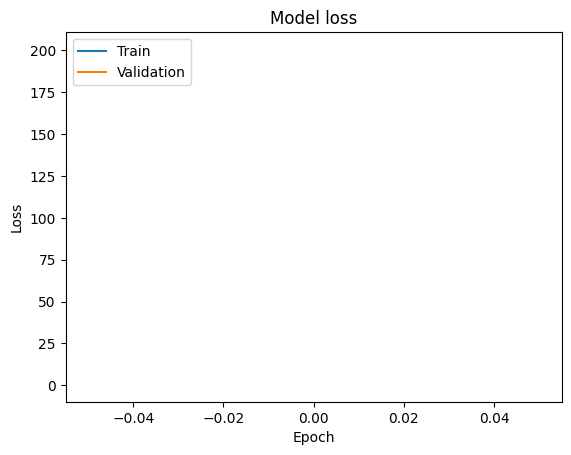

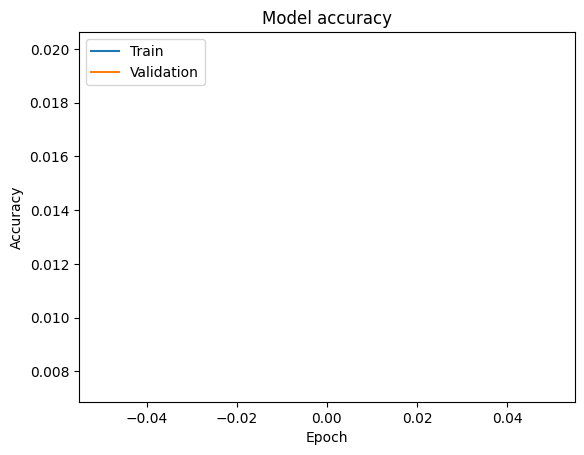

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub01\assets


Completed ROI:  V4 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1843)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1843)
X_val shape:  (100, 900)
y_val shape:  (100, 1843)
25/25 [==============================] - 3s 85ms/step - loss: 39.1388 - accuracy: 0.0012 - val_loss: 0.2532 - val_accuracy: 0.0000e+00
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1214)              1093814   
                                                                 
 dense_16 (Dense)            (None, 1528)              1856520   
                                                    

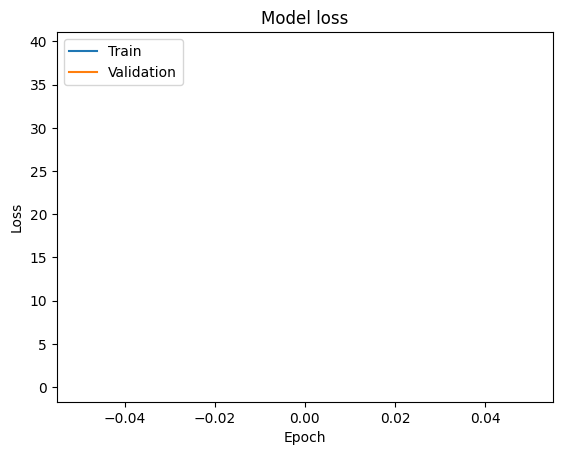

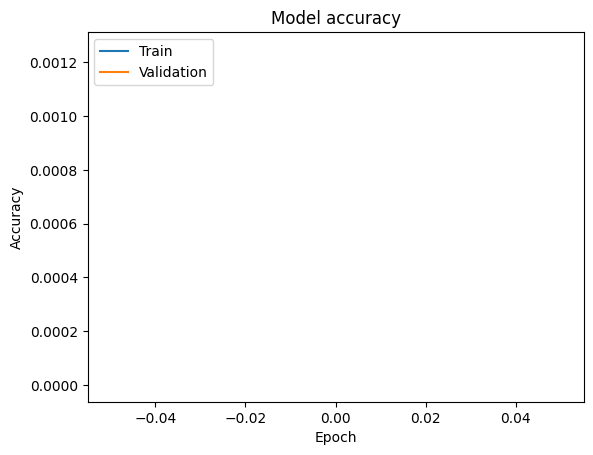

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub01\assets


Completed ROI:  LOC sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 351)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 351)
X_val shape:  (100, 900)
y_val shape:  (100, 351)
25/25 [==============================] - 1s 14ms/step - loss: 91.3716 - accuracy: 0.0025 - val_loss: 0.2545 - val_accuracy: 0.0100
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 717)               646017    
                                                                 
 dense_19 (Dense)            (None, 534)               383412    
                                                          

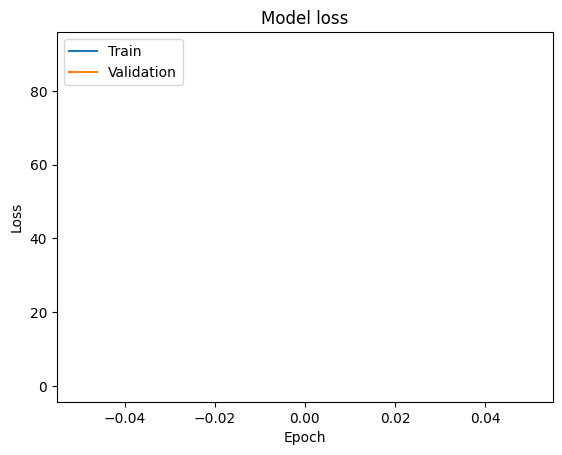

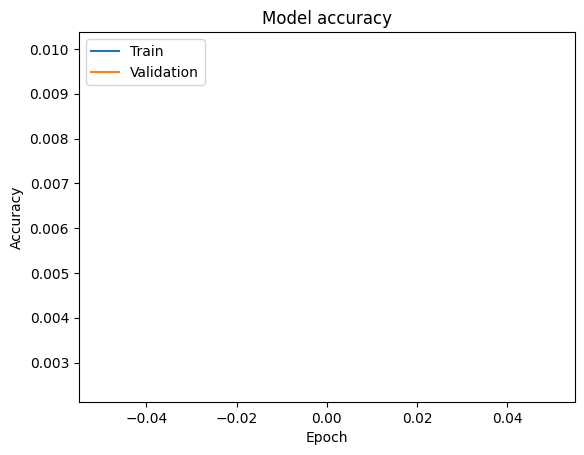

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub01\assets


Completed ROI:  EBA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 68)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 68)
X_val shape:  (100, 900)
y_val shape:  (100, 68)
25/25 [==============================] - 1s 13ms/step - loss: 304.6081 - accuracy: 0.0213 - val_loss: 18.1335 - val_accuracy: 0.0100
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 622)               560422    
                                                                 
 dense_22 (Dense)            (None, 345)               214935    
                                                           

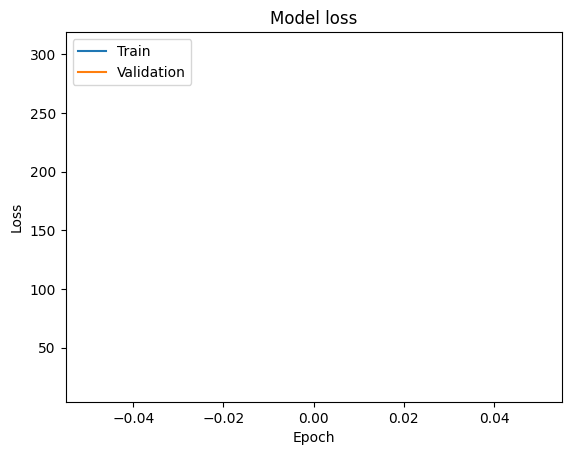

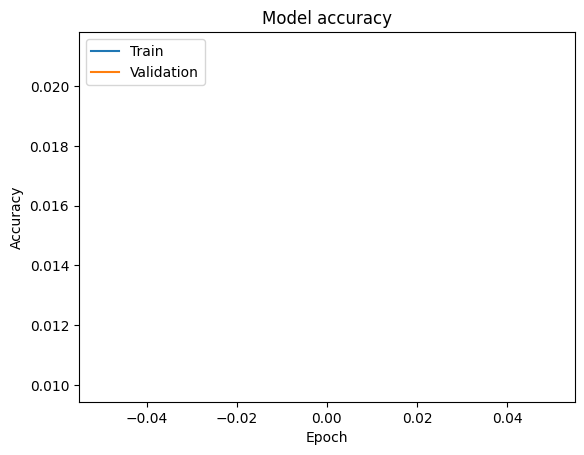

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub01\assets


Completed ROI:  FFA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 341)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 341)
X_val shape:  (100, 900)
y_val shape:  (100, 341)
25/25 [==============================] - 1s 16ms/step - loss: 95.1305 - accuracy: 0.0025 - val_loss: 0.2426 - val_accuracy: 0.0000e+00
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 713)               642413    
                                                                 
 dense_25 (Dense)            (None, 527)               376278    
                                                      

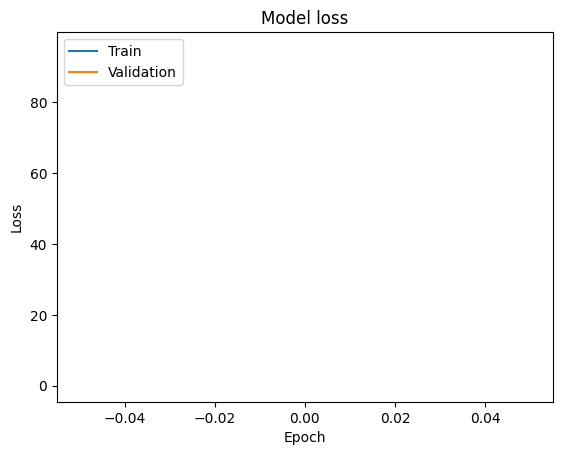

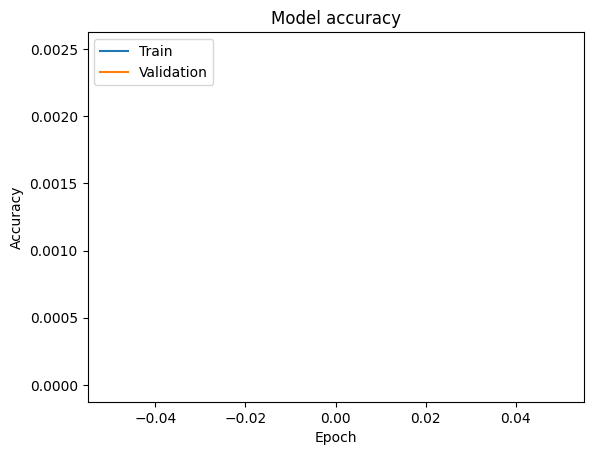

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub01\assets


Completed ROI:  STS sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub01
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 425)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 425)
X_val shape:  (100, 900)
y_val shape:  (100, 425)
25/25 [==============================] - 1s 17ms/step - loss: 88.8773 - accuracy: 0.0025 - val_loss: 0.2167 - val_accuracy: 0.0000e+00
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 741)               667641    
                                                                 
 dense_28 (Dense)            (None, 583)               432586    
                                                      

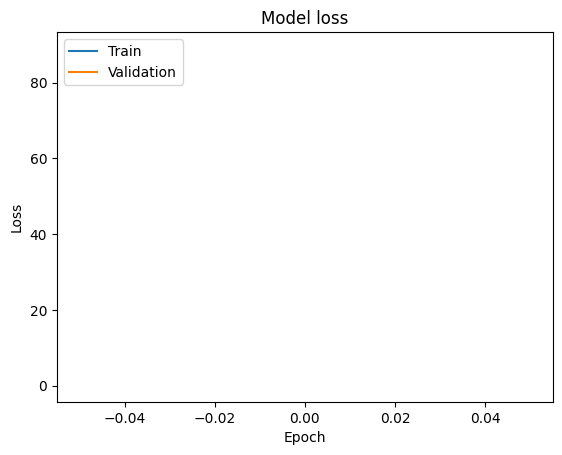

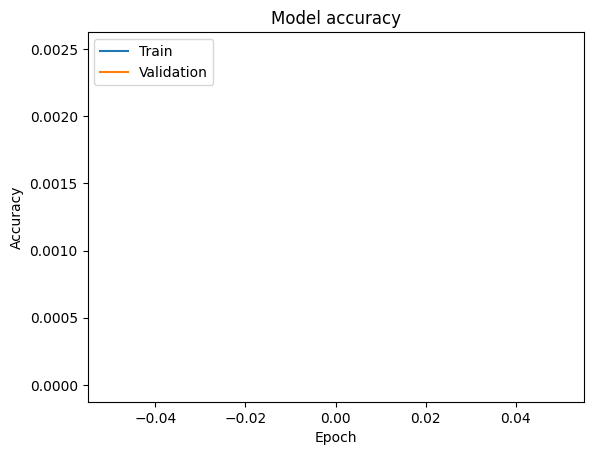

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub01
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub01\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub01\assets


Completed ROI:  PPA sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 21573)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 21573)
X_val shape:  (100, 900)
y_val shape:  (100, 21573)
25/25 [==============================] - 90s 3s/step - loss: 93.4917 - accuracy: 0.0000e+00 - val_loss: 0.3130 - val_accuracy: 0.0000e+00
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 7791)              7019691   
                                                                 
 dense_31 (Dense)            (None, 14682)             114402144 
                                             

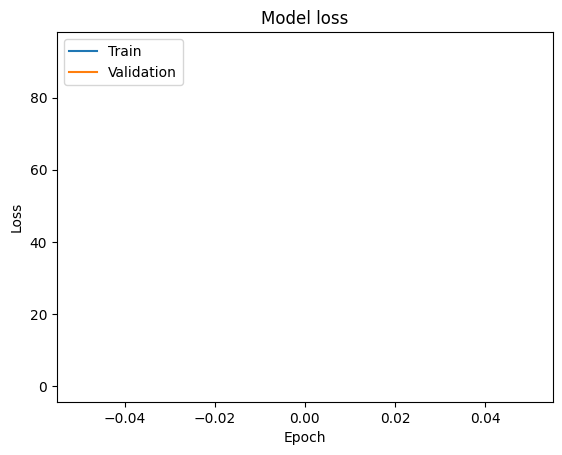

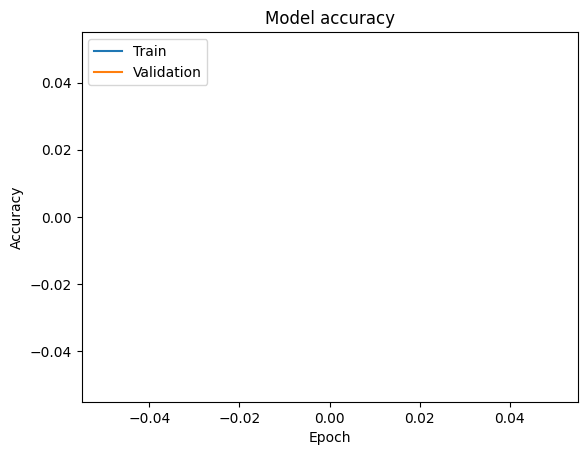

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub02\assets


Completed ROI:  WB sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 285)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 285)
X_val shape:  (100, 900)
y_val shape:  (100, 285)
25/25 [==============================] - 1s 19ms/step - loss: 124.3642 - accuracy: 0.0050 - val_loss: 0.2369 - val_accuracy: 0.0100
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 695)               626195    
                                                                 
 dense_34 (Dense)            (None, 490)               341040    
                                                          

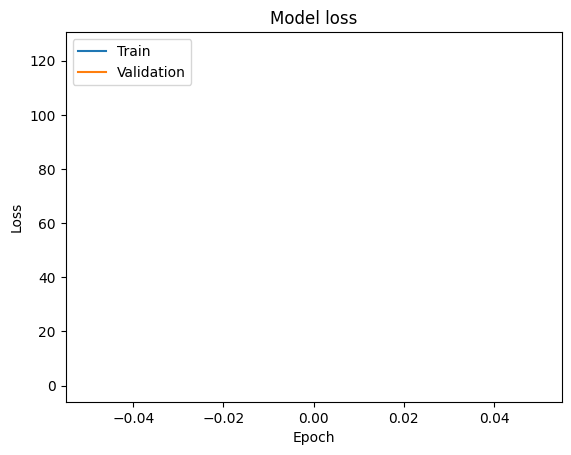

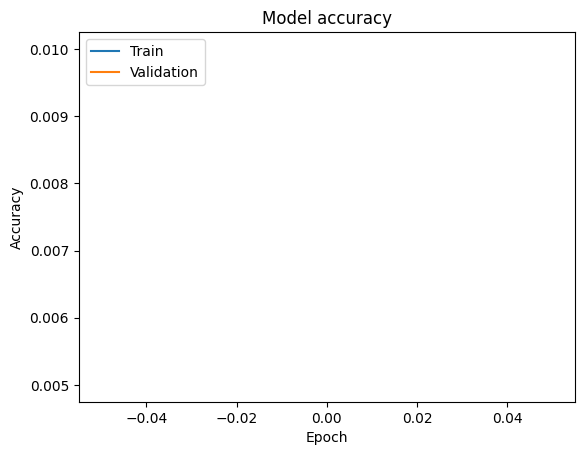

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub02\assets


Completed ROI:  V1 sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 231)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 231)
X_val shape:  (100, 900)
y_val shape:  (100, 231)
25/25 [==============================] - 1s 16ms/step - loss: 115.4679 - accuracy: 0.0063 - val_loss: 0.2422 - val_accuracy: 0.0000e+00
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 677)               609977    
                                                                 
 dense_37 (Dense)            (None, 454)               307812    
                                                      

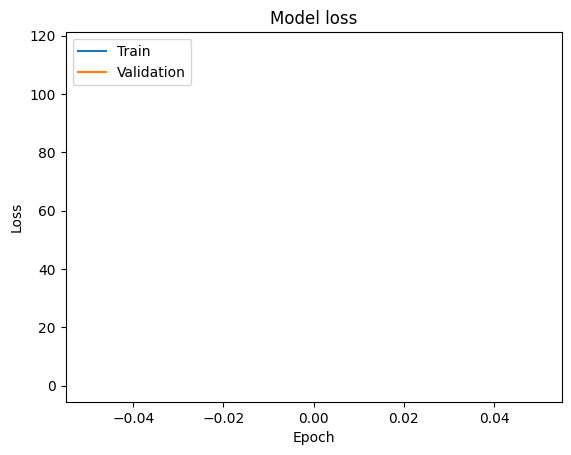

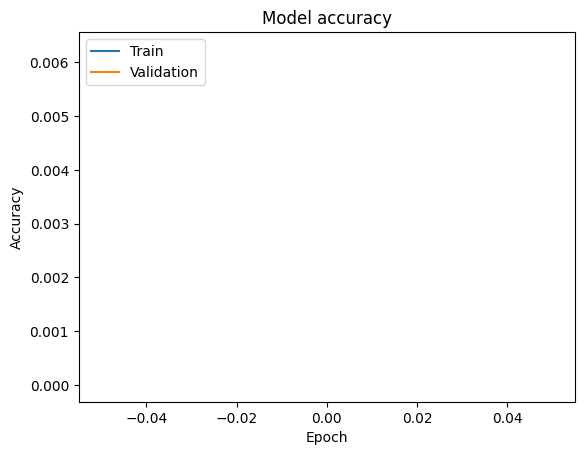

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub02\assets


Completed ROI:  V2 sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 270)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 270)
X_val shape:  (100, 900)
y_val shape:  (100, 270)
25/25 [==============================] - 1s 16ms/step - loss: 99.5355 - accuracy: 0.0063 - val_loss: 0.2409 - val_accuracy: 0.0100
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 690)               621690    
                                                                 
 dense_40 (Dense)            (None, 480)               331680    
                                                           

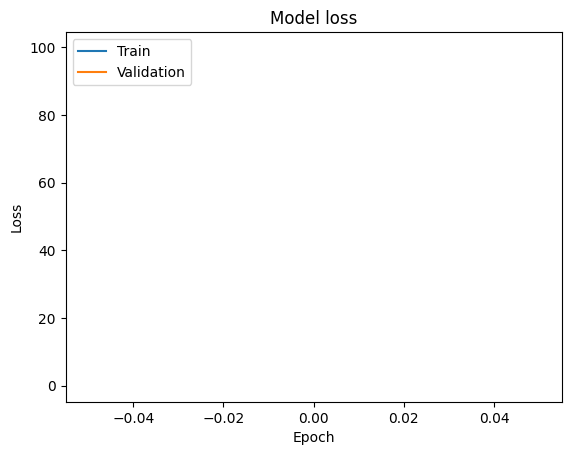

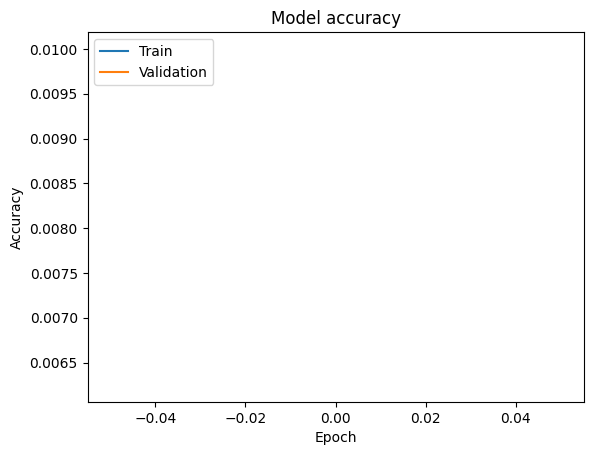

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub02\assets


Completed ROI:  V3 sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 95)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 95)
X_val shape:  (100, 900)
y_val shape:  (100, 95)
25/25 [==============================] - 1s 15ms/step - loss: 237.4288 - accuracy: 0.0188 - val_loss: 5.3494 - val_accuracy: 0.0100
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 631)               568531    
                                                                 
 dense_43 (Dense)            (None, 363)               229416    
                                                             

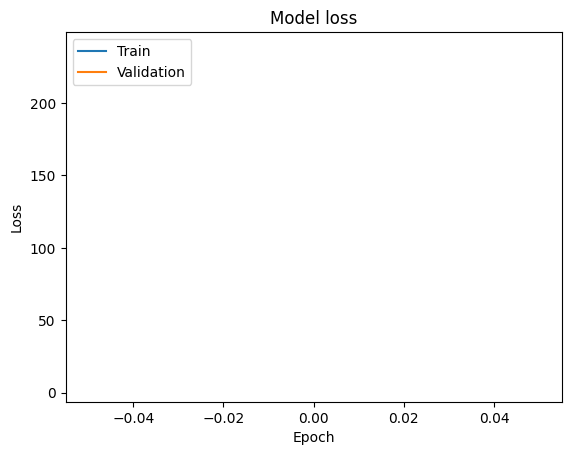

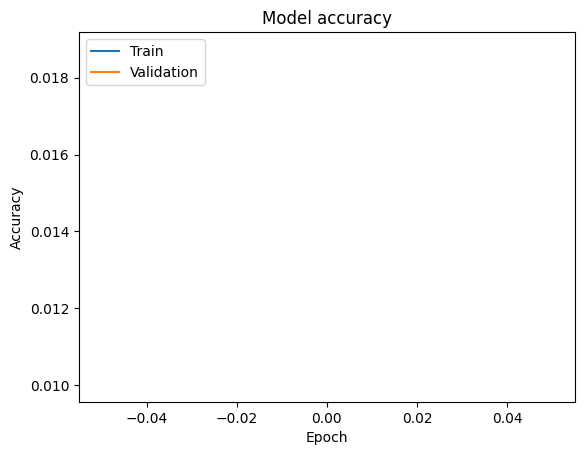

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub02\assets


Completed ROI:  V4 sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1348)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1348)
X_val shape:  (100, 900)
y_val shape:  (100, 1348)
25/25 [==============================] - 1s 25ms/step - loss: 51.1716 - accuracy: 0.0012 - val_loss: 0.2605 - val_accuracy: 0.0000e+00
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 1049)              945149    
                                                                 
 dense_46 (Dense)            (None, 1198)              1257900   
                                                   

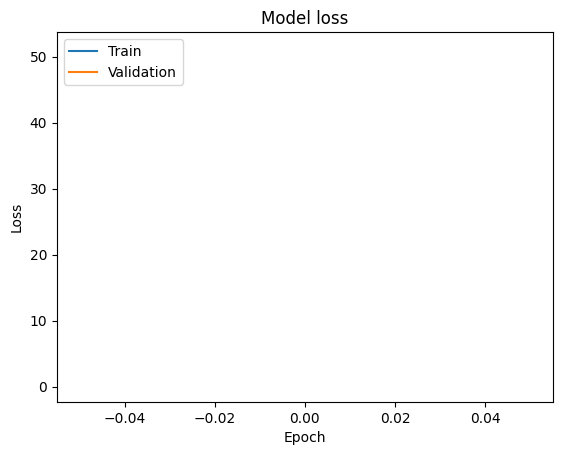

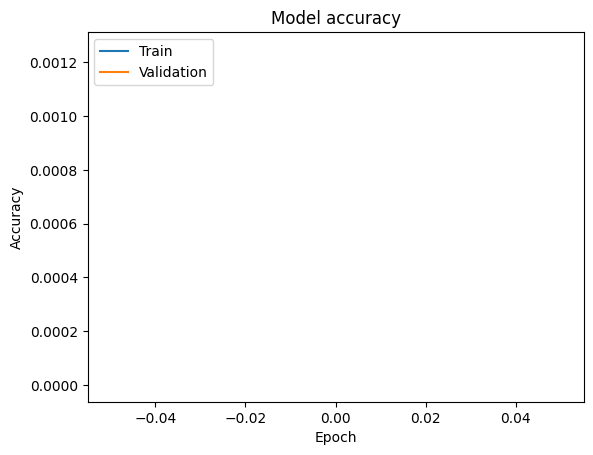

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub02\assets


Completed ROI:  LOC sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 183)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 183)
X_val shape:  (100, 900)
y_val shape:  (100, 183)
25/25 [==============================] - 1s 17ms/step - loss: 129.2574 - accuracy: 0.0063 - val_loss: 0.2786 - val_accuracy: 0.0000e+00
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 661)               595561    
                                                                 
 dense_49 (Dense)            (None, 422)               279364    
                                                    

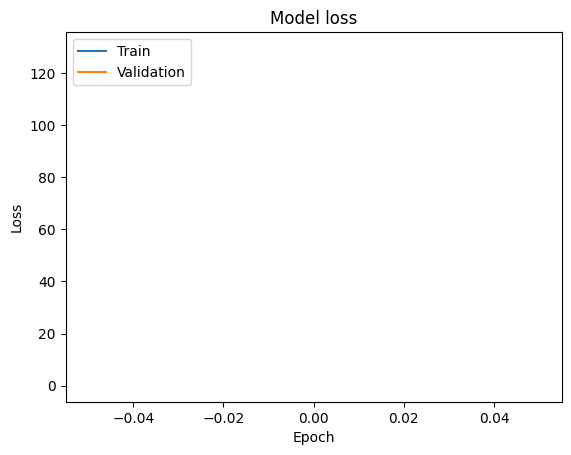

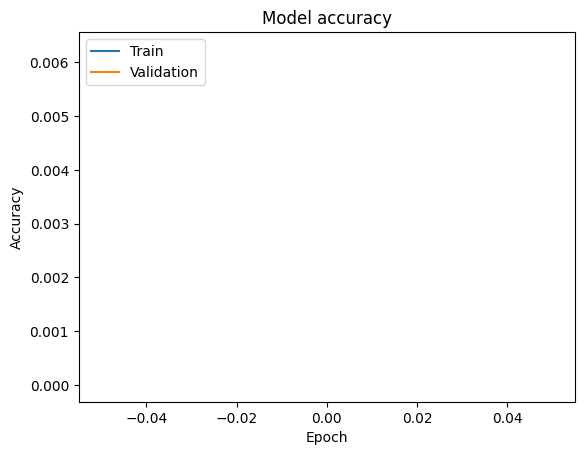

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub02\assets


Completed ROI:  EBA sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 157)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 157)
X_val shape:  (100, 900)
y_val shape:  (100, 157)
25/25 [==============================] - 1s 14ms/step - loss: 130.4131 - accuracy: 0.0088 - val_loss: 0.2978 - val_accuracy: 0.0000e+00
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 652)               587452    
                                                                 
 dense_52 (Dense)            (None, 404)               263812    
                                                    

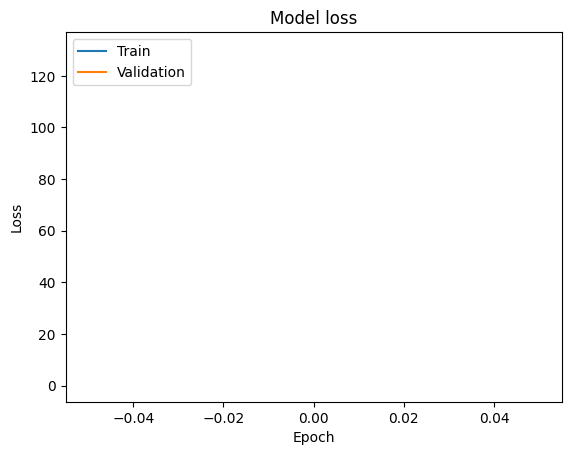

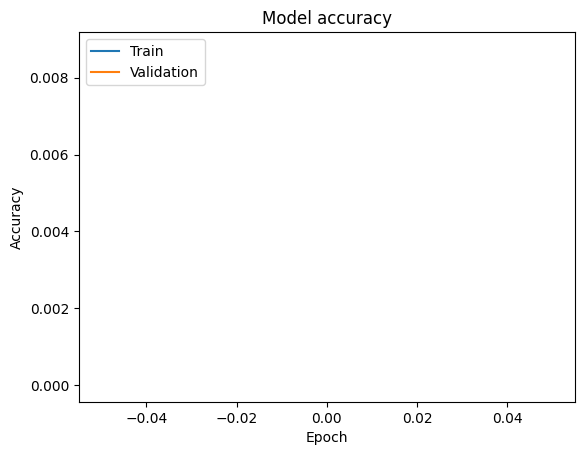

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub02\assets


Completed ROI:  FFA sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 421)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 421)
X_val shape:  (100, 900)
y_val shape:  (100, 421)
25/25 [==============================] - 1s 17ms/step - loss: 90.1102 - accuracy: 0.0012 - val_loss: 0.2362 - val_accuracy: 0.0000e+00
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 740)               666740    
                                                                 
 dense_55 (Dense)            (None, 580)               429780    
                                                     

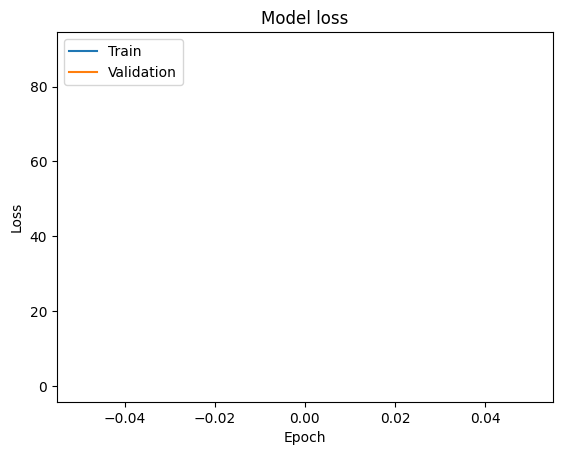

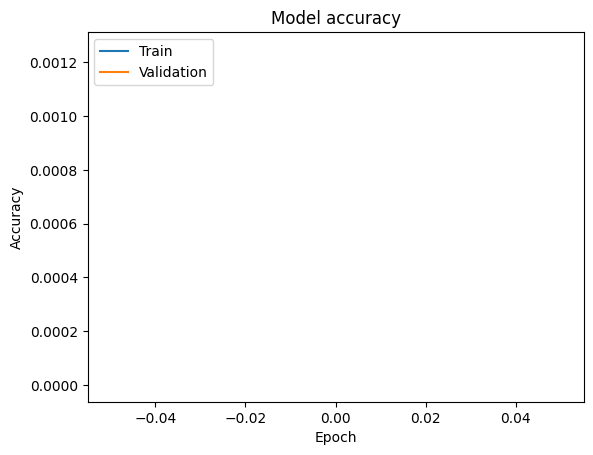

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub02\assets


Completed ROI:  STS sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub02
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 153)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 153)
X_val shape:  (100, 900)
y_val shape:  (100, 153)
25/25 [==============================] - 1s 13ms/step - loss: 178.0328 - accuracy: 0.0063 - val_loss: 0.2023 - val_accuracy: 0.0300
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 651)               586551    
                                                                 
 dense_58 (Dense)            (None, 402)               262104    
                                                        

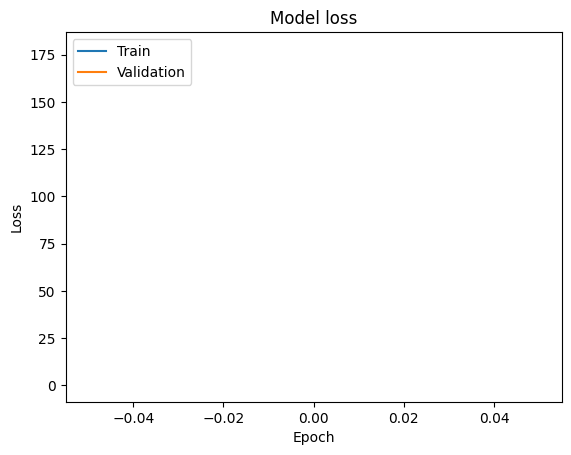

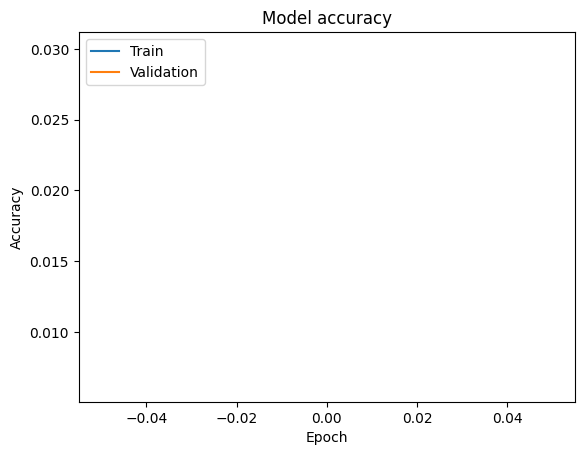

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub02
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub02\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub02\assets


Completed ROI:  PPA sub:  sub02
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 15225)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 15225)
X_val shape:  (100, 900)
y_val shape:  (100, 15225)
25/25 [==============================] - 22s 677ms/step - loss: 50.9048 - accuracy: 0.0000e+00 - val_loss: 0.2024 - val_accuracy: 0.0000e+00
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, 5675)              5113175   
                                                                 
 dense_61 (Dense)            (None, 10450)             59314200  
                                          

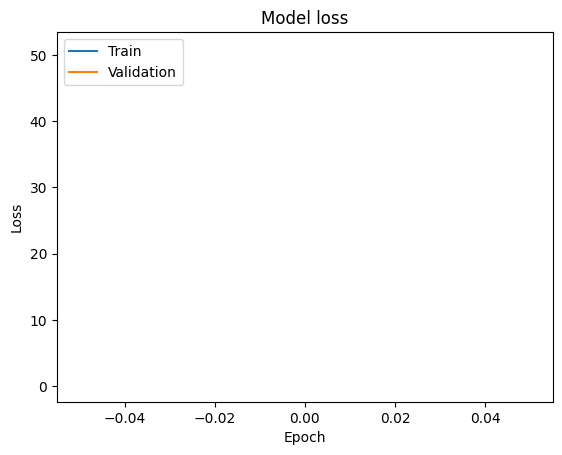

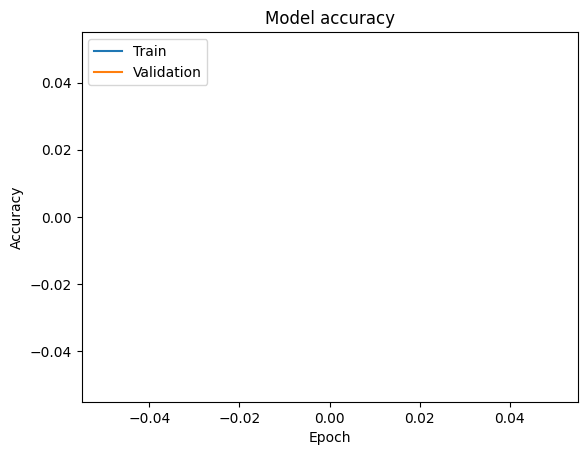

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub03\assets


Completed ROI:  WB sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 164)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 164)
X_val shape:  (100, 900)
y_val shape:  (100, 164)
25/25 [==============================] - 2s 14ms/step - loss: 153.7038 - accuracy: 0.0050 - val_loss: 0.2175 - val_accuracy: 0.0000e+00
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 654)               589254    
                                                                 
 dense_64 (Dense)            (None, 409)               267895    
                                                      

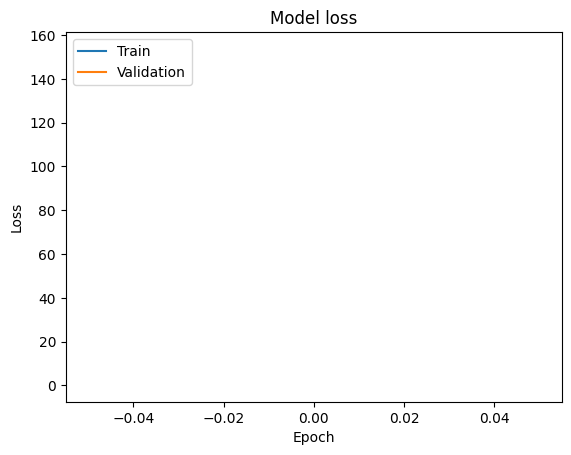

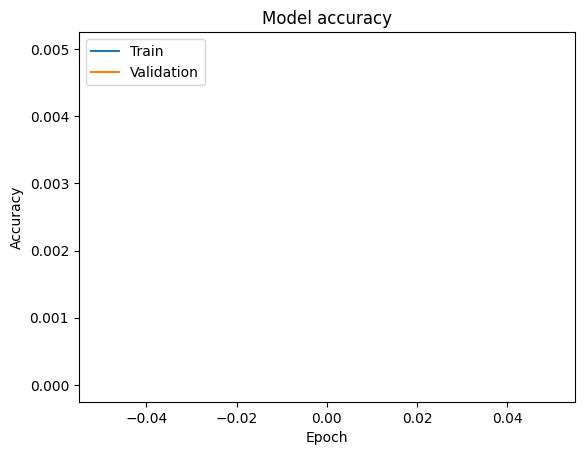

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub03\assets


Completed ROI:  V1 sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 271)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 271)
X_val shape:  (100, 900)
y_val shape:  (100, 271)
25/25 [==============================] - 1s 15ms/step - loss: 114.1977 - accuracy: 0.0088 - val_loss: 0.2065 - val_accuracy: 0.0100
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 690)               621690    
                                                                 
 dense_67 (Dense)            (None, 480)               331680    
                                                          

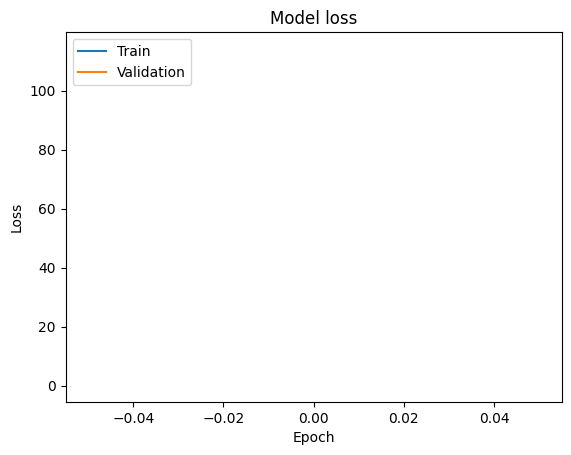

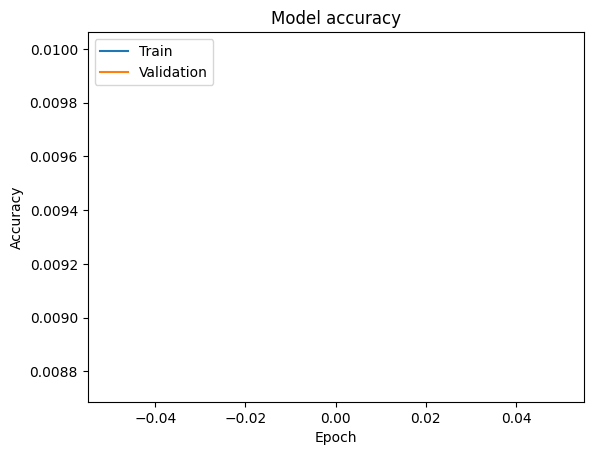

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub03\assets


Completed ROI:  V2 sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 270)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 270)
X_val shape:  (100, 900)
y_val shape:  (100, 270)
25/25 [==============================] - 1s 16ms/step - loss: 161.5459 - accuracy: 0.0012 - val_loss: 0.2034 - val_accuracy: 0.0000e+00
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 690)               621690    
                                                                 
 dense_70 (Dense)            (None, 480)               331680    
                                                      

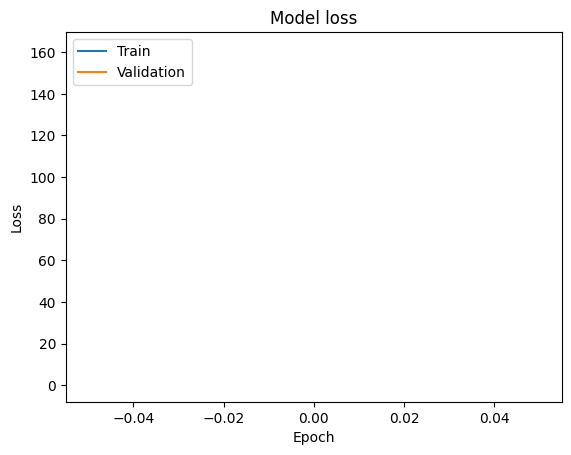

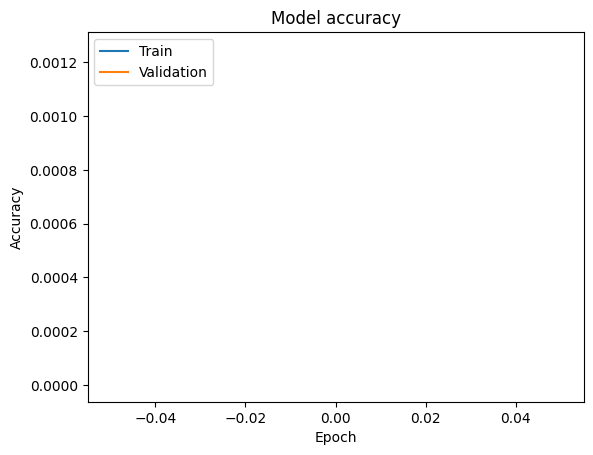

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub03\assets


Completed ROI:  V3 sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 111)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 111)
X_val shape:  (100, 900)
y_val shape:  (100, 111)
25/25 [==============================] - 1s 14ms/step - loss: 148.3922 - accuracy: 0.0125 - val_loss: 0.3010 - val_accuracy: 0.0100
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 637)               573937    
                                                                 
 dense_73 (Dense)            (None, 374)               238612    
                                                          

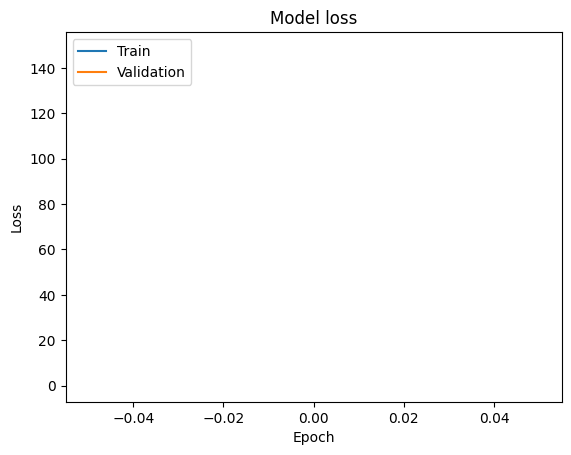

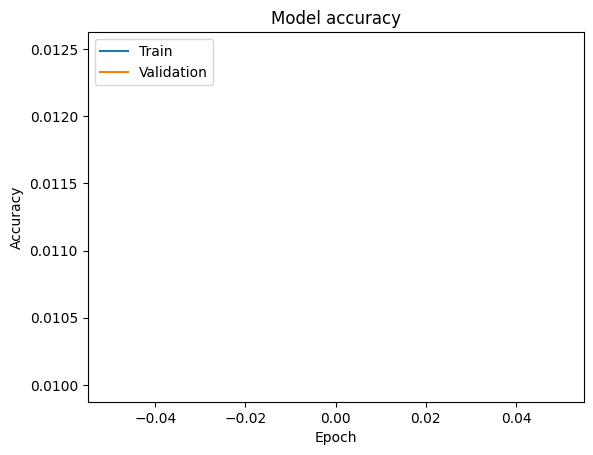

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub03\assets


Completed ROI:  V4 sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1237)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1237)
X_val shape:  (100, 900)
y_val shape:  (100, 1237)
25/25 [==============================] - 1s 23ms/step - loss: 50.7220 - accuracy: 0.0000e+00 - val_loss: 0.2261 - val_accuracy: 0.0000e+00
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 1012)              911812    
                                                                 
 dense_76 (Dense)            (None, 1124)              1138612   
                                               

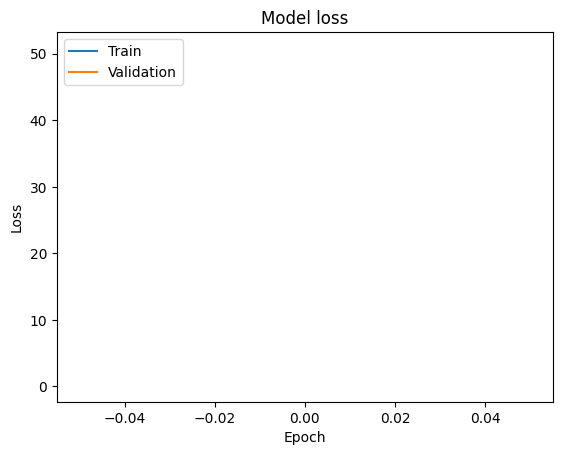

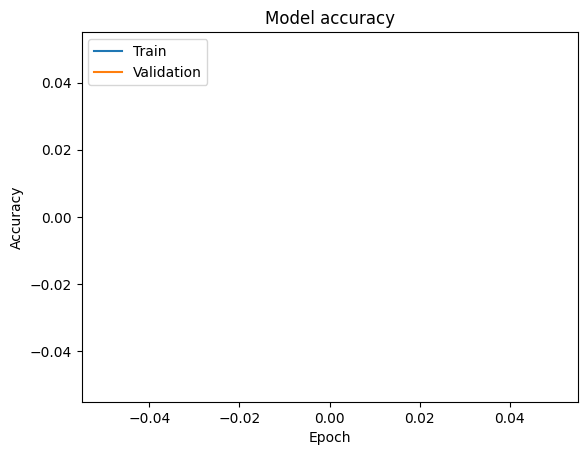

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub03\assets


Completed ROI:  LOC sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 376)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 376)
X_val shape:  (100, 900)
y_val shape:  (100, 376)
25/25 [==============================] - 1s 15ms/step - loss: 92.7533 - accuracy: 0.0037 - val_loss: 0.2448 - val_accuracy: 0.0000e+00
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 725)               653225    
                                                                 
 dense_79 (Dense)            (None, 550)               399300    
                                                     

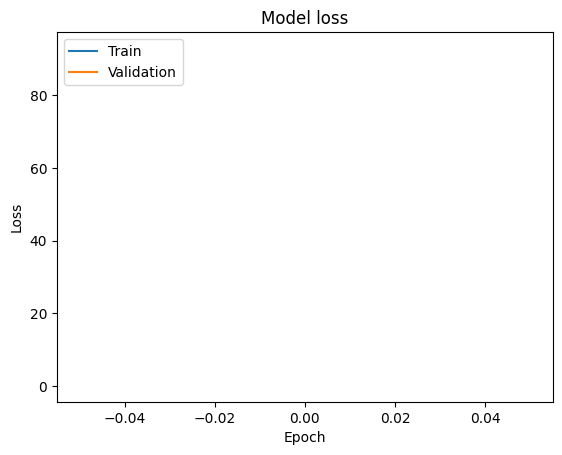

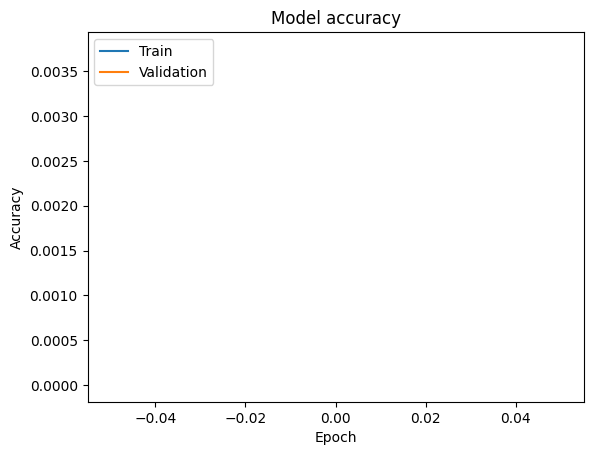

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub03\assets


Completed ROI:  EBA sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 80)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 80)
X_val shape:  (100, 900)
y_val shape:  (100, 80)
25/25 [==============================] - 1s 14ms/step - loss: 196.6219 - accuracy: 0.0113 - val_loss: 8.5954 - val_accuracy: 0.0000e+00
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_81 (Dense)            (None, 626)               564026    
                                                                 
 dense_82 (Dense)            (None, 353)               221331    
                                                       

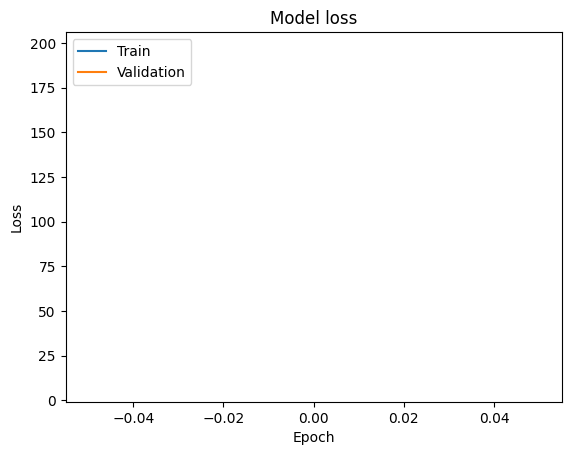

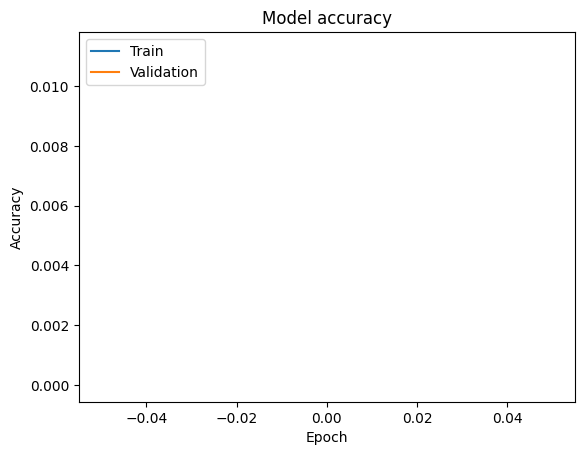

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub03\assets


Completed ROI:  FFA sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 278)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 278)
X_val shape:  (100, 900)
y_val shape:  (100, 278)
25/25 [==============================] - 1s 14ms/step - loss: 105.2637 - accuracy: 0.0037 - val_loss: 0.2239 - val_accuracy: 0.0100
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 692)               623492    
                                                                 
 dense_85 (Dense)            (None, 485)               336105    
                                                        

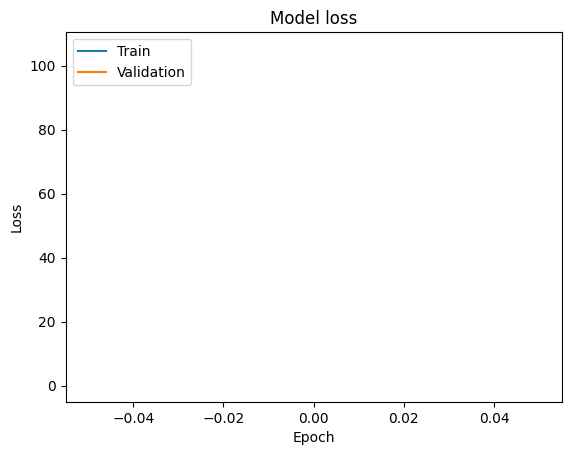

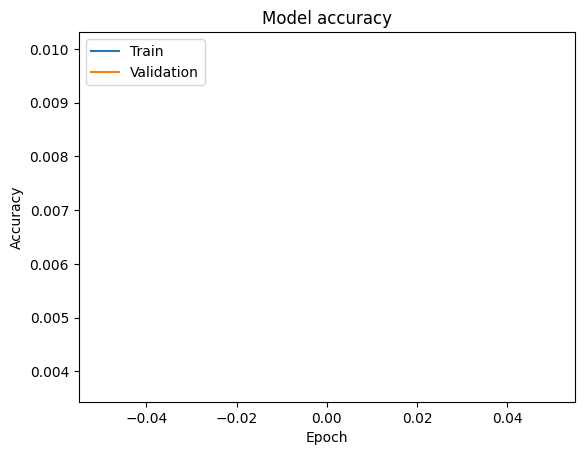

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub03\assets


Completed ROI:  STS sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub03
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 368)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 368)
X_val shape:  (100, 900)
y_val shape:  (100, 368)
25/25 [==============================] - 1s 16ms/step - loss: 101.4509 - accuracy: 0.0012 - val_loss: 0.2150 - val_accuracy: 0.0000e+00
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            (None, 722)               650522    
                                                                 
 dense_88 (Dense)            (None, 545)               394035    
                                                    

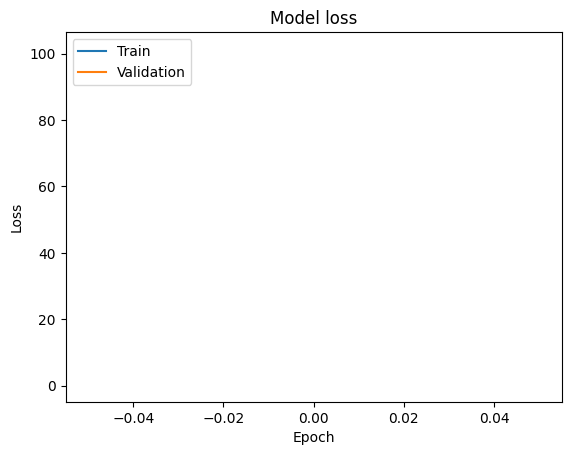

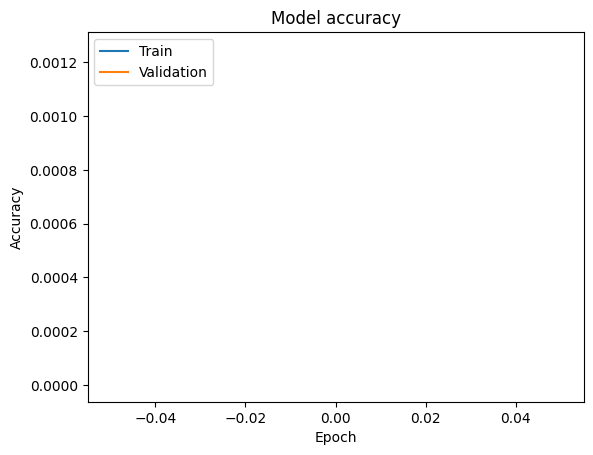

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub03
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub03\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub03\assets


Completed ROI:  PPA sub:  sub03
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 19445)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 19445)
X_val shape:  (100, 900)
y_val shape:  (100, 19445)
25/25 [==============================] - 59s 1s/step - loss: 74.9145 - accuracy: 0.0000e+00 - val_loss: 0.2165 - val_accuracy: 0.0000e+00
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 7081)              6379981   
                                                                 
 dense_91 (Dense)            (None, 13263)             93928566  
                                             

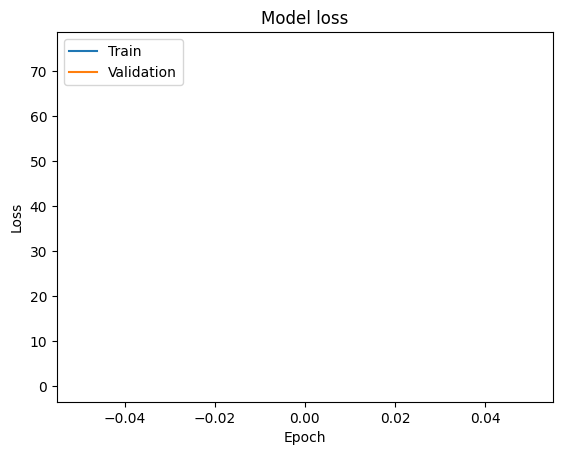

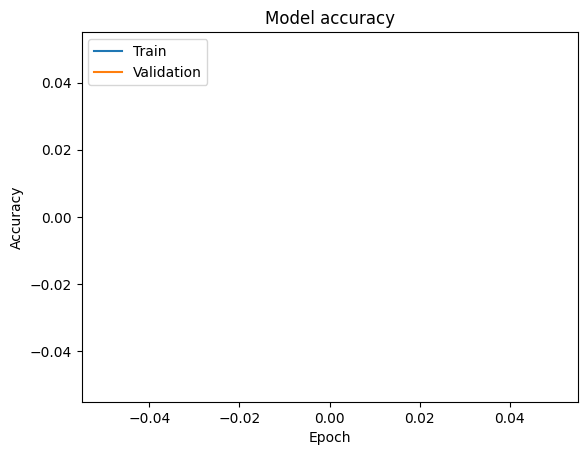

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub04\assets


Completed ROI:  WB sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 176)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 176)
X_val shape:  (100, 900)
y_val shape:  (100, 176)
25/25 [==============================] - 1s 20ms/step - loss: 149.5526 - accuracy: 0.0050 - val_loss: 0.2456 - val_accuracy: 0.0000e+00
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 658)               592858    
                                                                 
 dense_94 (Dense)            (None, 417)               274803    
                                                      

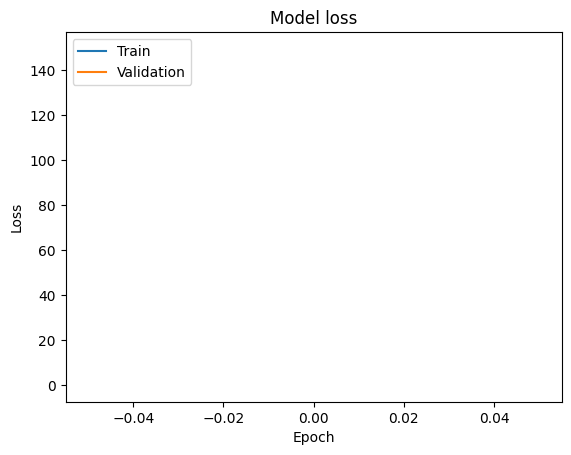

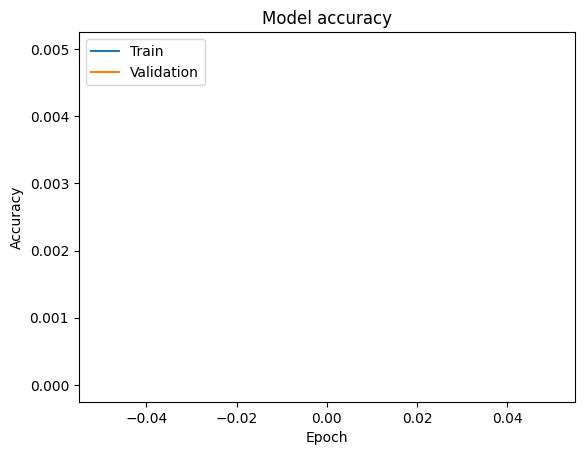

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub04\assets


Completed ROI:  V1 sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 209)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 209)
X_val shape:  (100, 900)
y_val shape:  (100, 209)
25/25 [==============================] - 1s 18ms/step - loss: 139.7317 - accuracy: 0.0088 - val_loss: 0.2371 - val_accuracy: 0.0000e+00
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 669)               602769    
                                                                 
 dense_97 (Dense)            (None, 439)               294130    
                                                      

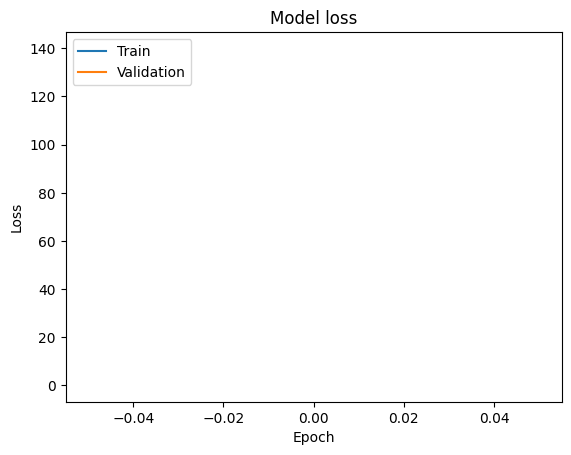

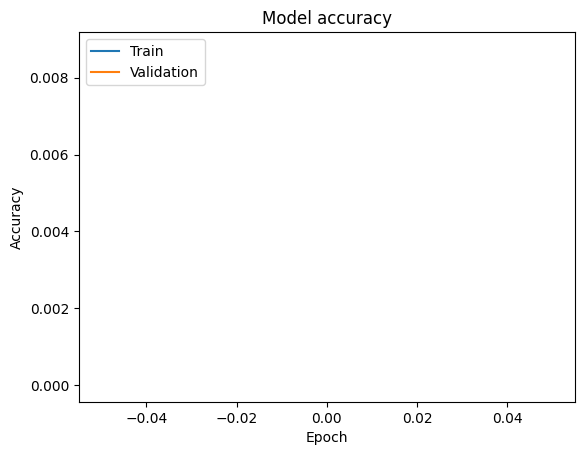

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub04\assets


Completed ROI:  V2 sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 212)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 212)
X_val shape:  (100, 900)
y_val shape:  (100, 212)
25/25 [==============================] - 1s 25ms/step - loss: 146.4084 - accuracy: 0.0063 - val_loss: 0.2485 - val_accuracy: 0.0000e+00
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 670)               603670    
                                                                 
 dense_100 (Dense)           (None, 441)               295911    
                                                      

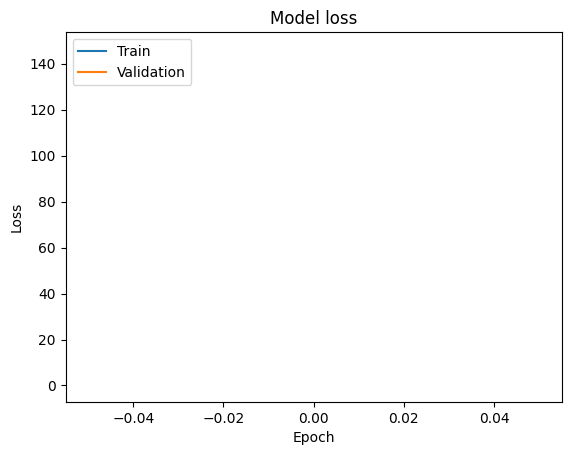

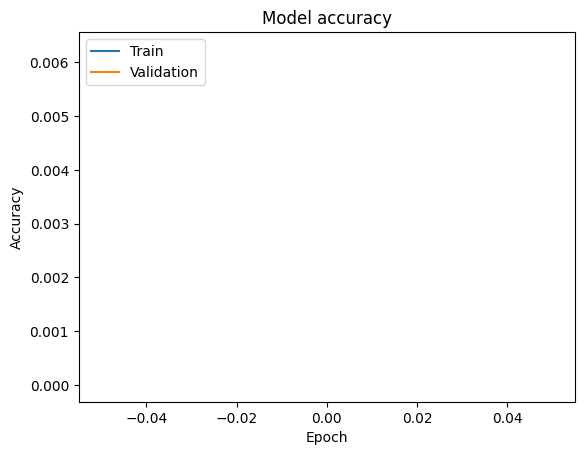

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub04\assets


Completed ROI:  V3 sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 117)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 117)
X_val shape:  (100, 900)
y_val shape:  (100, 117)
25/25 [==============================] - 1s 16ms/step - loss: 159.7149 - accuracy: 0.0050 - val_loss: 1.4741 - val_accuracy: 0.0000e+00
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 639)               575739    
                                                                 
 dense_103 (Dense)           (None, 378)               241920    
                                                      

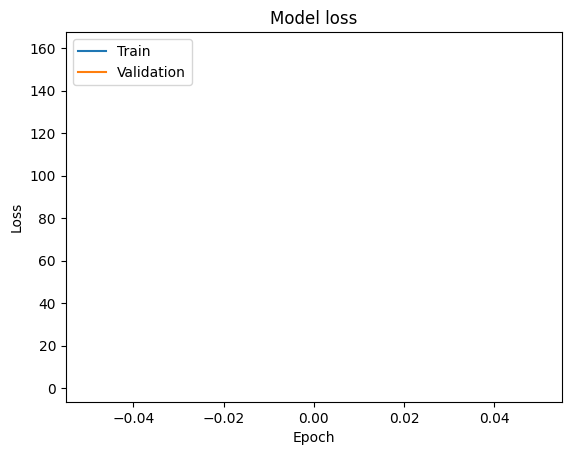

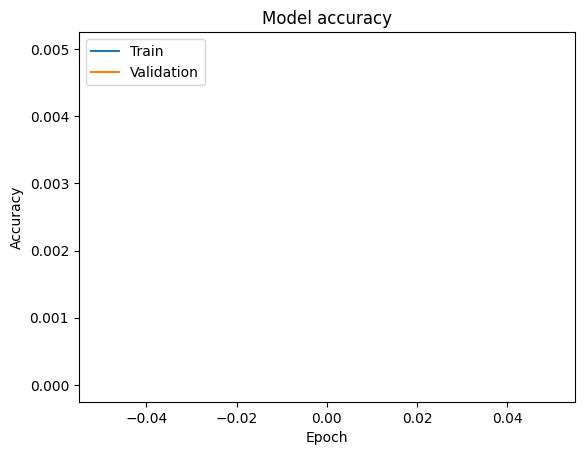

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub04\assets


Completed ROI:  V4 sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1153)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1153)
X_val shape:  (100, 900)
y_val shape:  (100, 1153)
25/25 [==============================] - 1s 25ms/step - loss: 52.4008 - accuracy: 0.0025 - val_loss: 0.2542 - val_accuracy: 0.0000e+00
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_105 (Dense)           (None, 984)               886584    
                                                                 
 dense_106 (Dense)           (None, 1068)              1051980   
                                                   

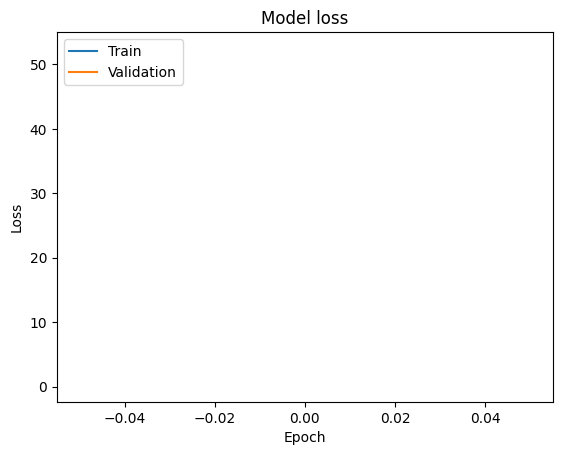

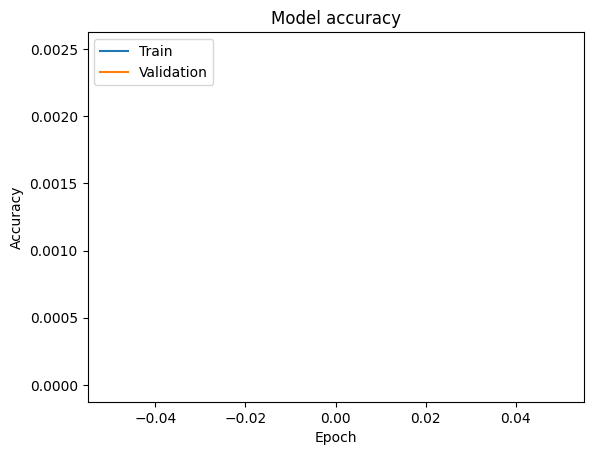

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub04\assets


Completed ROI:  LOC sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 368)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 368)
X_val shape:  (100, 900)
y_val shape:  (100, 368)
25/25 [==============================] - 1s 17ms/step - loss: 104.4334 - accuracy: 0.0025 - val_loss: 0.2729 - val_accuracy: 0.0000e+00
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 722)               650522    
                                                                 
 dense_109 (Dense)           (None, 545)               394035    
                                                    

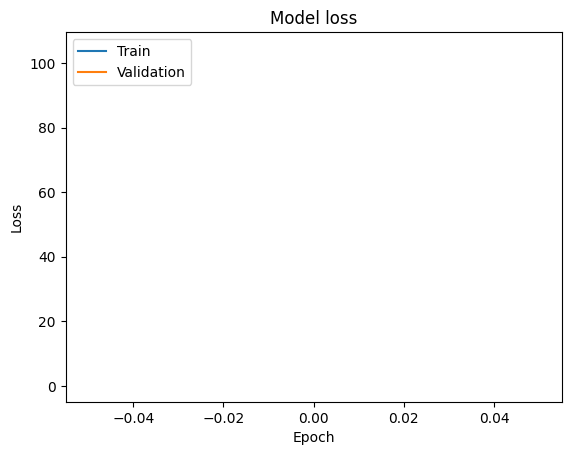

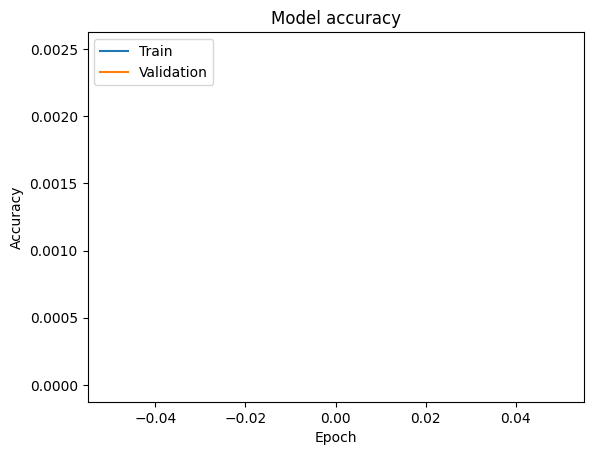

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub04\assets


Completed ROI:  EBA sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 210)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 210)
X_val shape:  (100, 900)
y_val shape:  (100, 210)
25/25 [==============================] - 1s 15ms/step - loss: 136.8504 - accuracy: 0.0025 - val_loss: 0.2284 - val_accuracy: 0.0200
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_111 (Dense)           (None, 670)               603670    
                                                                 
 dense_112 (Dense)           (None, 440)               295240    
                                                        

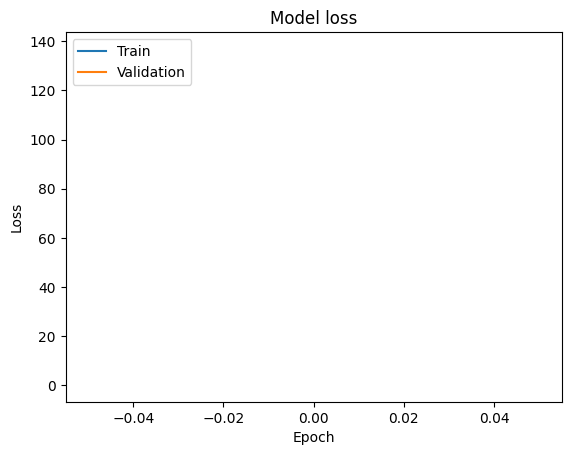

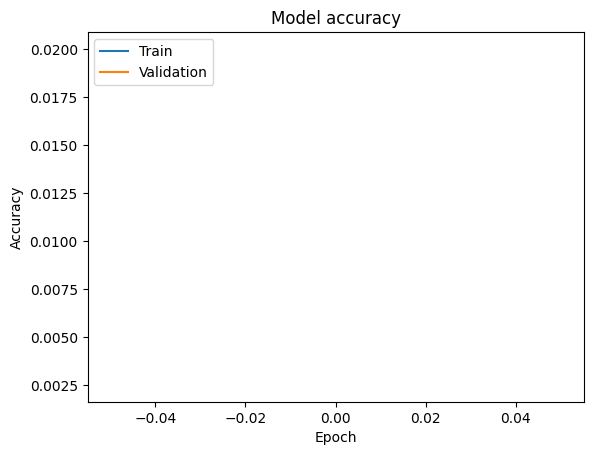

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub04\assets


Completed ROI:  FFA sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 398)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 398)
X_val shape:  (100, 900)
y_val shape:  (100, 398)
25/25 [==============================] - 1s 17ms/step - loss: 83.6877 - accuracy: 0.0012 - val_loss: 0.2352 - val_accuracy: 0.0200
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 732)               659532    
                                                                 
 dense_115 (Dense)           (None, 565)               414145    
                                                         

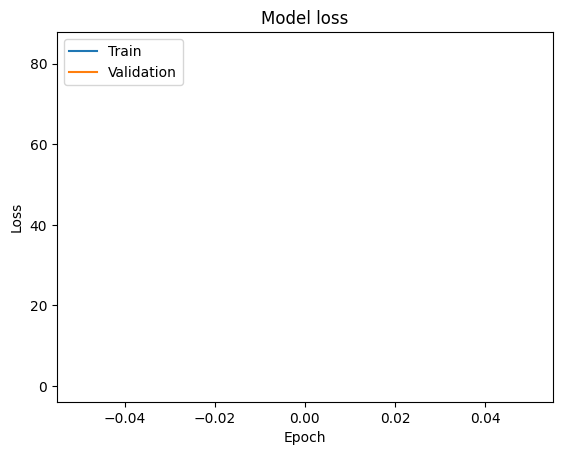

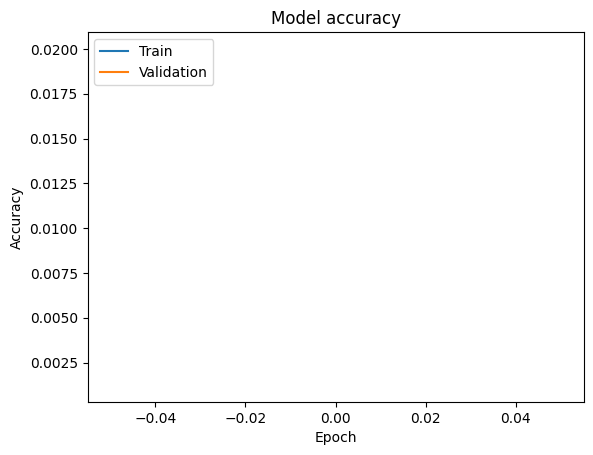

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub04\assets


Completed ROI:  STS sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub04
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 225)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 225)
X_val shape:  (100, 900)
y_val shape:  (100, 225)
25/25 [==============================] - 1s 14ms/step - loss: 166.5606 - accuracy: 0.0037 - val_loss: 0.1962 - val_accuracy: 0.0000e+00
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 675)               608175    
                                                                 
 dense_118 (Dense)           (None, 450)               304200    
                                                    

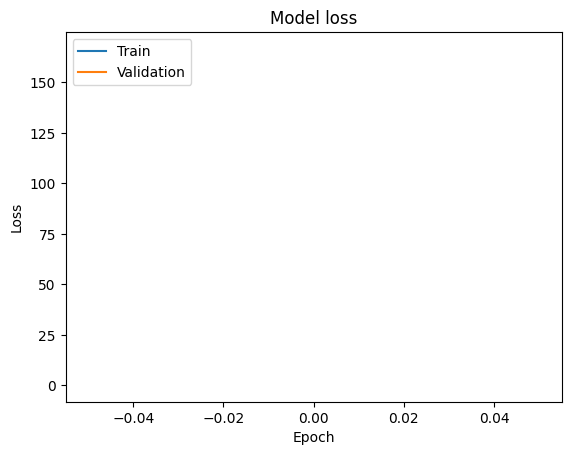

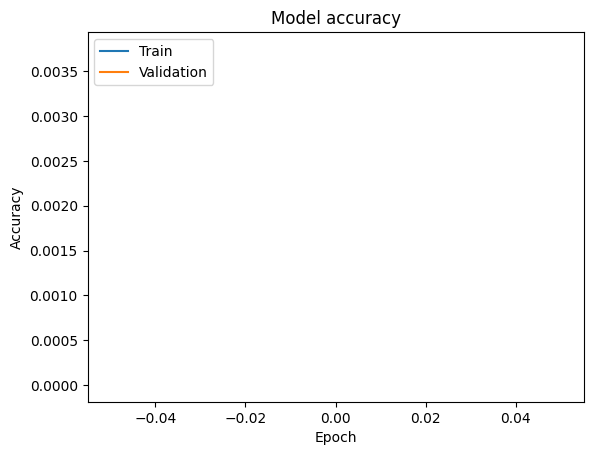

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub04
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub04\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub04\assets


Completed ROI:  PPA sub:  sub04
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 13340)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 13340)
X_val shape:  (100, 900)
y_val shape:  (100, 13340)
25/25 [==============================] - 13s 502ms/step - loss: 33.8736 - accuracy: 0.0000e+00 - val_loss: 0.2232 - val_accuracy: 0.0000e+00
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 5046)              4546446   
                                                                 
 dense_121 (Dense)           (None, 9193)              46397071  
                                          

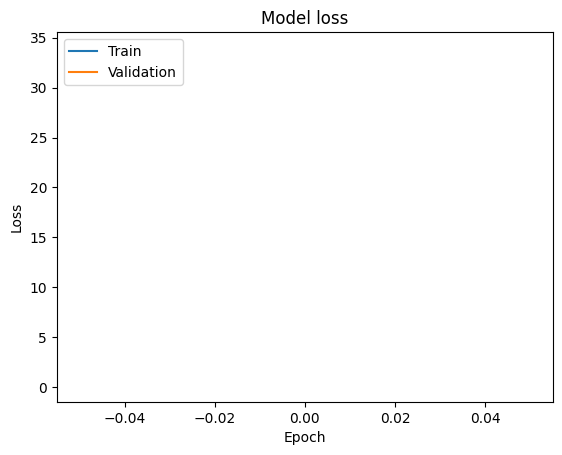

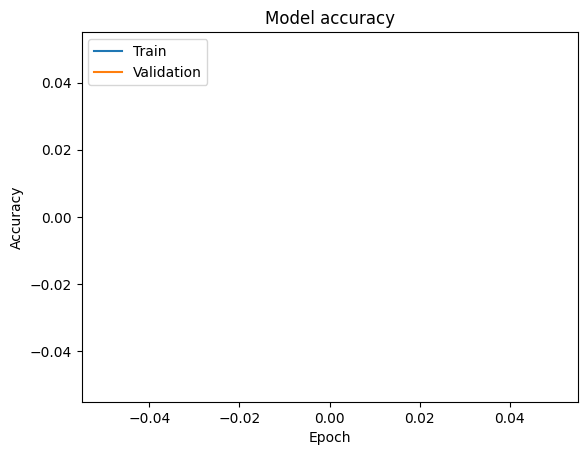

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub05\assets


Completed ROI:  WB sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 326)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 326)
X_val shape:  (100, 900)
y_val shape:  (100, 326)
25/25 [==============================] - 1s 18ms/step - loss: 101.1690 - accuracy: 0.0050 - val_loss: 0.2694 - val_accuracy: 0.0000e+00
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_123 (Dense)           (None, 708)               637908    
                                                                 
 dense_124 (Dense)           (None, 517)               366553    
                                                      

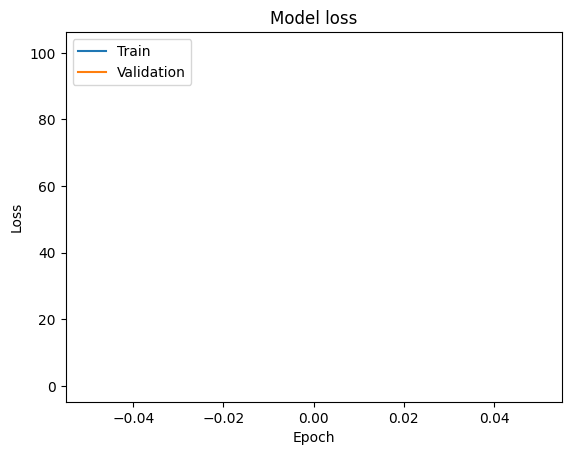

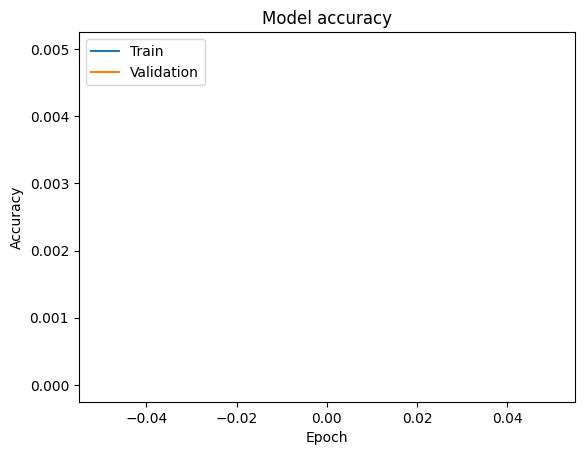

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub05\assets


Completed ROI:  V1 sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 196)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 196)
X_val shape:  (100, 900)
y_val shape:  (100, 196)
25/25 [==============================] - 1s 16ms/step - loss: 113.5968 - accuracy: 0.0063 - val_loss: 0.2593 - val_accuracy: 0.0000e+00
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 665)               599165    
                                                                 
 dense_127 (Dense)           (None, 430)               286380    
                                                      

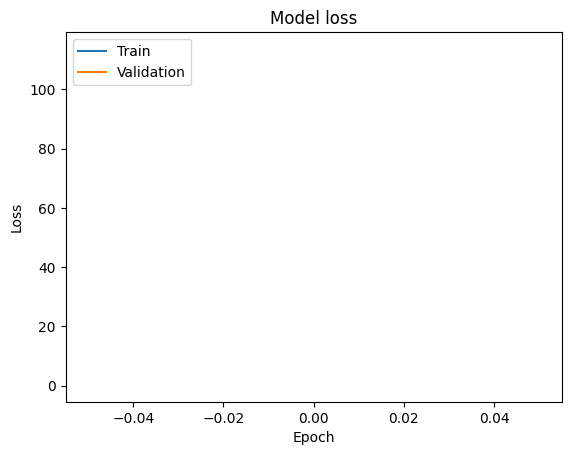

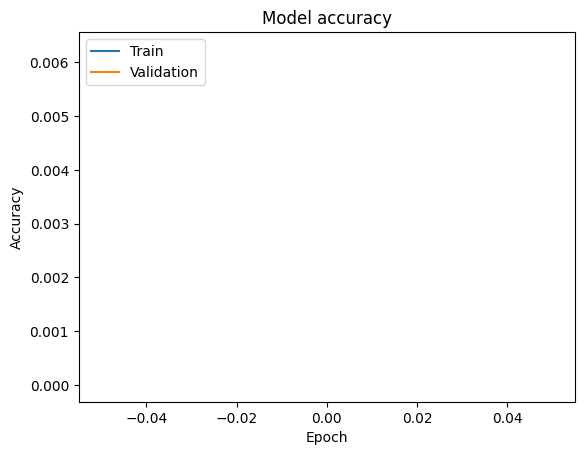

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub05\assets


Completed ROI:  V2 sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 176)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 176)
X_val shape:  (100, 900)
y_val shape:  (100, 176)
25/25 [==============================] - 1s 15ms/step - loss: 156.4146 - accuracy: 0.0037 - val_loss: 0.2497 - val_accuracy: 0.0000e+00
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 658)               592858    
                                                                 
 dense_130 (Dense)           (None, 417)               274803    
                                                      

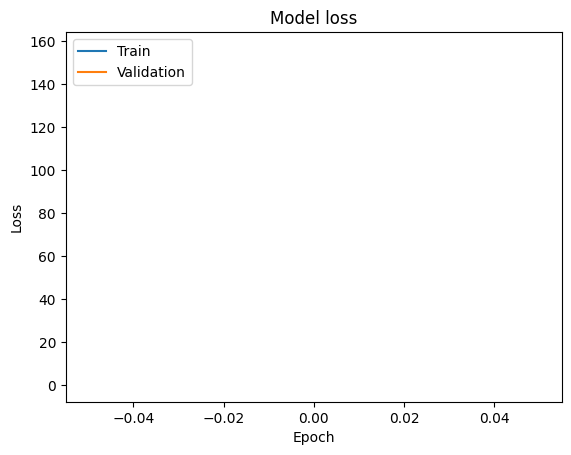

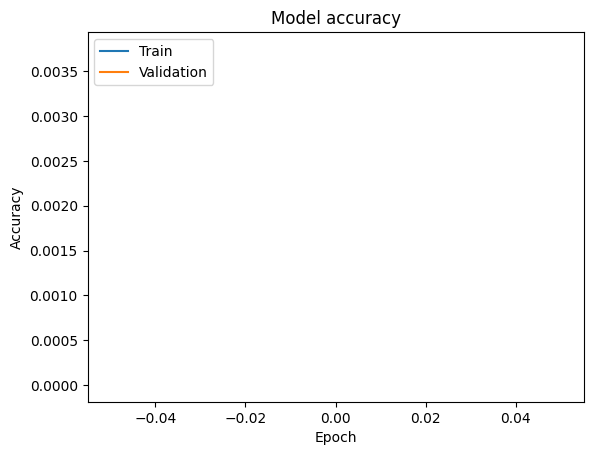

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub05\assets


Completed ROI:  V3 sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 73)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 73)
X_val shape:  (100, 900)
y_val shape:  (100, 73)
25/25 [==============================] - 1s 12ms/step - loss: 226.5299 - accuracy: 0.0113 - val_loss: 9.1995 - val_accuracy: 0.0000e+00
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 624)               562224    
                                                                 
 dense_133 (Dense)           (None, 348)               217500    
                                                         

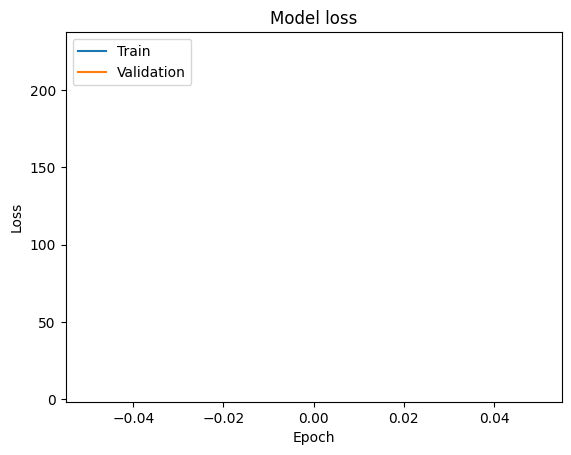

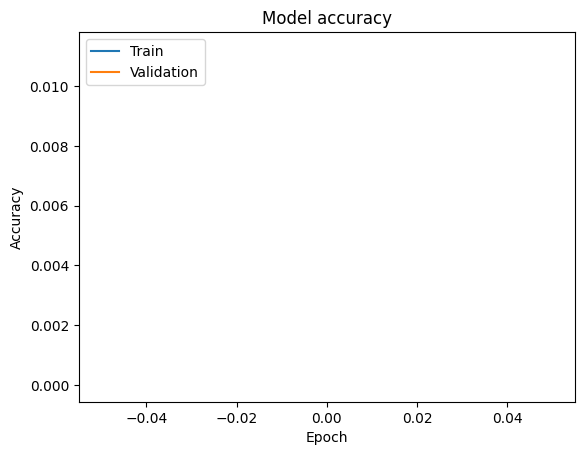

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub05\assets


Completed ROI:  V4 sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1397)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1397)
X_val shape:  (100, 900)
y_val shape:  (100, 1397)
25/25 [==============================] - 1s 26ms/step - loss: 44.3121 - accuracy: 0.0000e+00 - val_loss: 0.2792 - val_accuracy: 0.0000e+00
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 1065)              959565    
                                                                 
 dense_136 (Dense)           (None, 1231)              1312246   
                                               

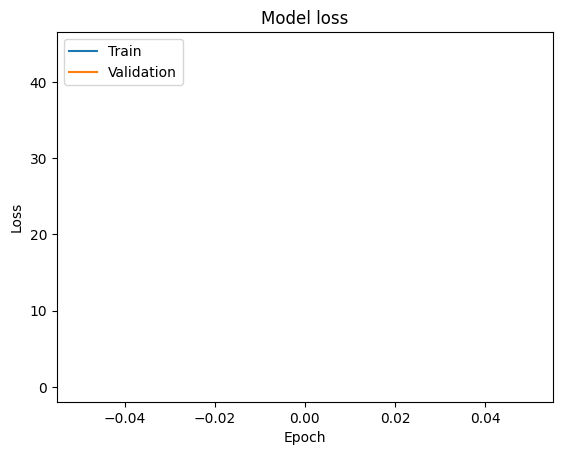

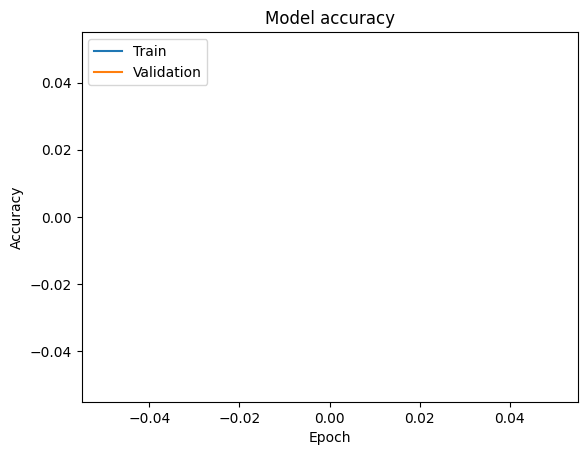

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub05\assets


Completed ROI:  LOC sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 309)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 309)
X_val shape:  (100, 900)
y_val shape:  (100, 309)
25/25 [==============================] - 1s 14ms/step - loss: 105.3038 - accuracy: 0.0050 - val_loss: 0.3039 - val_accuracy: 0.0100
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_138 (Dense)           (None, 703)               633403    
                                                                 
 dense_139 (Dense)           (None, 506)               356224    
                                                        

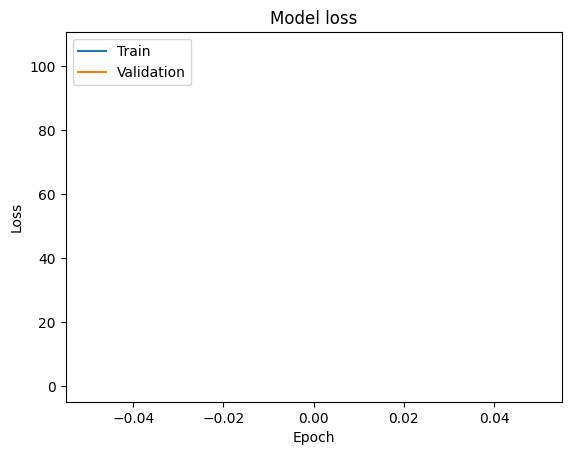

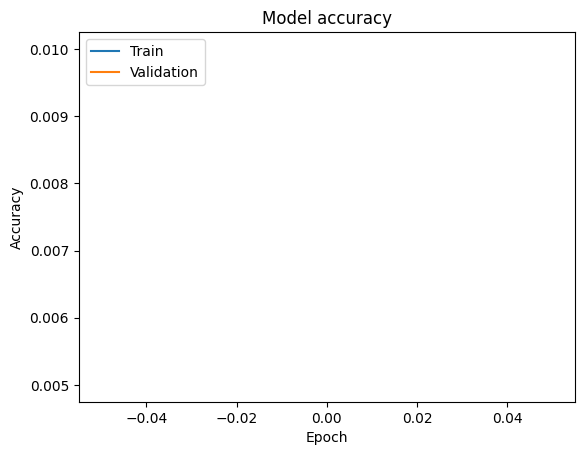

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub05\assets


Completed ROI:  EBA sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 69)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 69)
X_val shape:  (100, 900)
y_val shape:  (100, 69)
25/25 [==============================] - 1s 14ms/step - loss: 239.2616 - accuracy: 0.0125 - val_loss: 10.9247 - val_accuracy: 0.0200
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_141 (Dense)           (None, 623)               561323    
                                                                 
 dense_142 (Dense)           (None, 346)               215904    
                                                          

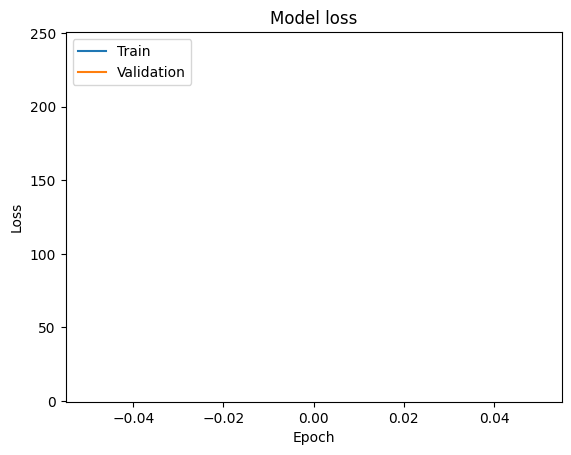

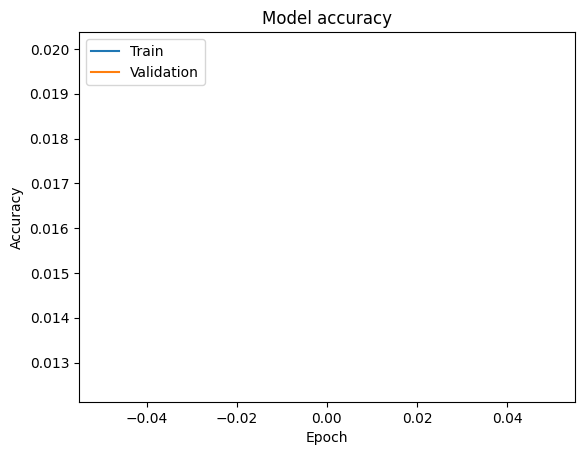

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub05\assets


Completed ROI:  FFA sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 219)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 219)
X_val shape:  (100, 900)
y_val shape:  (100, 219)
25/25 [==============================] - 1s 17ms/step - loss: 144.7651 - accuracy: 0.0050 - val_loss: 0.2305 - val_accuracy: 0.0000e+00
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_144 (Dense)           (None, 673)               606373    
                                                                 
 dense_145 (Dense)           (None, 446)               300604    
                                                    

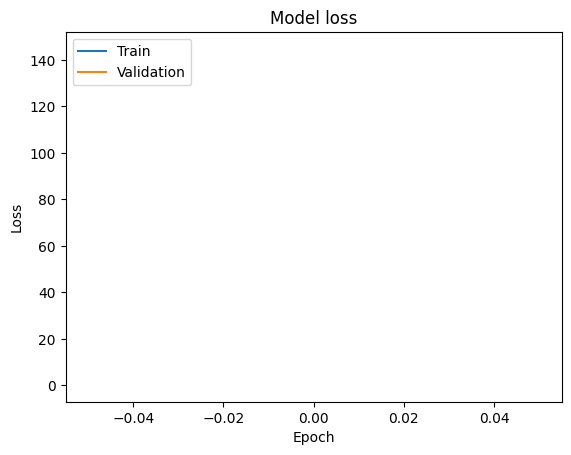

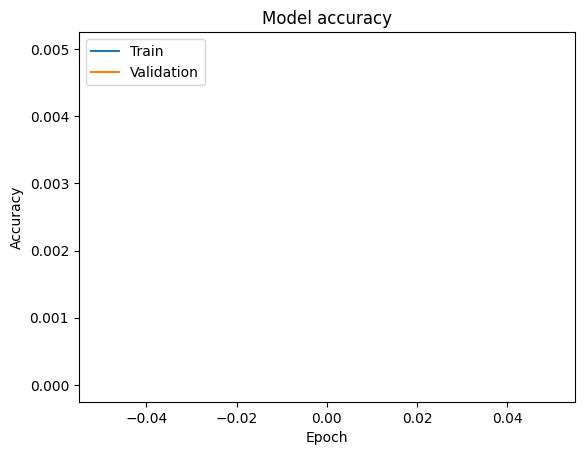

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub05\assets


Completed ROI:  STS sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub05
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 210)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 210)
X_val shape:  (100, 900)
y_val shape:  (100, 210)
25/25 [==============================] - 1s 14ms/step - loss: 125.3107 - accuracy: 0.0050 - val_loss: 0.2077 - val_accuracy: 0.0000e+00
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_147 (Dense)           (None, 670)               603670    
                                                                 
 dense_148 (Dense)           (None, 440)               295240    
                                                    

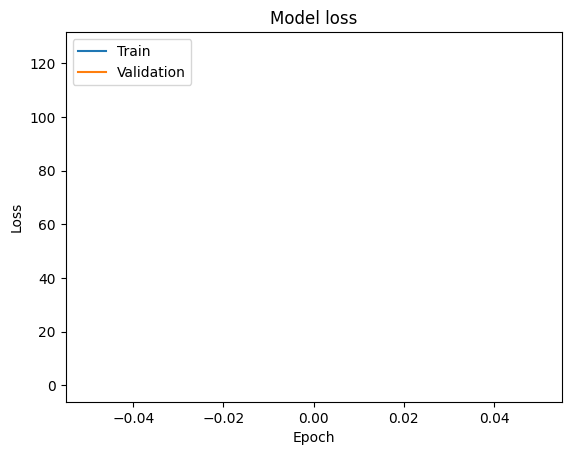

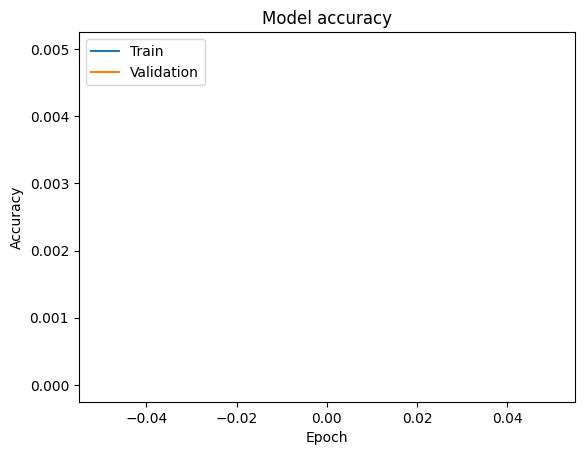

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub05
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub05\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub05\assets


Completed ROI:  PPA sub:  sub05
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 19818)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 19818)
X_val shape:  (100, 900)
y_val shape:  (100, 19818)
25/25 [==============================] - 34s 1s/step - loss: 77.4328 - accuracy: 0.0000e+00 - val_loss: 0.2179 - val_accuracy: 0.0000e+00
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 7206)              6492606   
                                                                 
 dense_151 (Dense)           (None, 13512)             97380984  
                                             

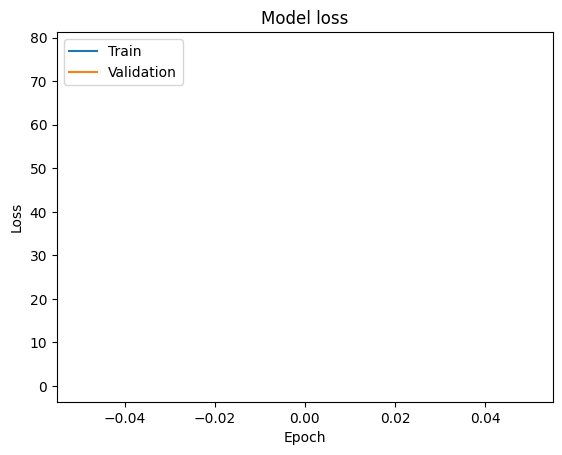

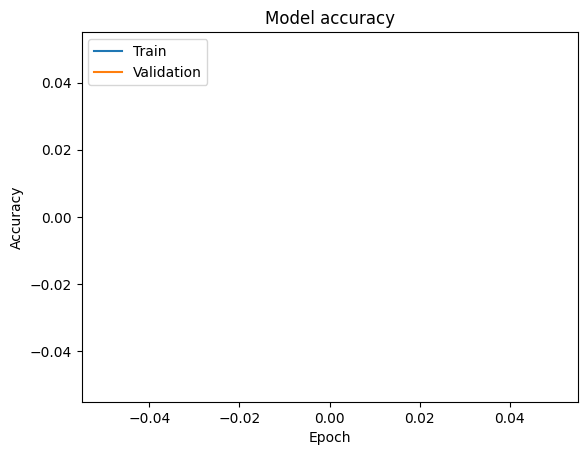

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub06\assets


Completed ROI:  WB sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 286)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 286)
X_val shape:  (100, 900)
y_val shape:  (100, 286)
25/25 [==============================] - 1s 19ms/step - loss: 103.2960 - accuracy: 0.0000e+00 - val_loss: 0.2338 - val_accuracy: 0.0000e+00
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_153 (Dense)           (None, 695)               626195    
                                                                 
 dense_154 (Dense)           (None, 490)               341040    
                                                  

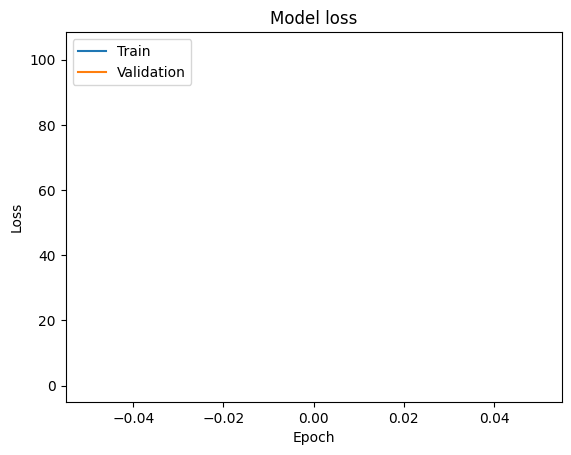

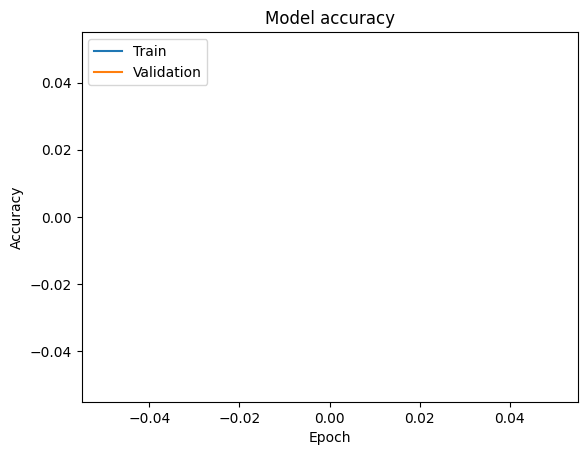

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub06\assets


Completed ROI:  V1 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 281)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 281)
X_val shape:  (100, 900)
y_val shape:  (100, 281)
25/25 [==============================] - 1s 17ms/step - loss: 103.3862 - accuracy: 0.0025 - val_loss: 0.2358 - val_accuracy: 0.0100
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 693)               624393    
                                                                 
 dense_157 (Dense)           (None, 487)               337978    
                                                          

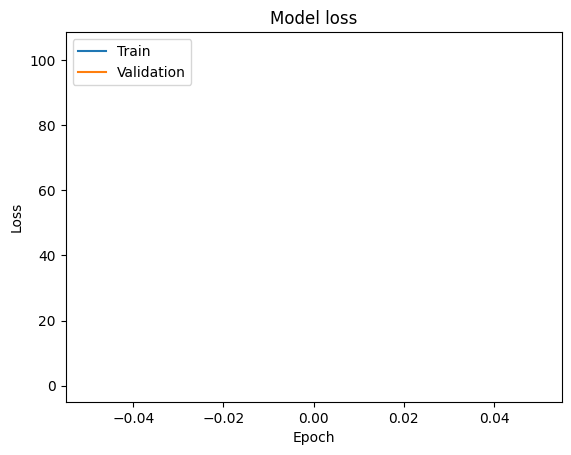

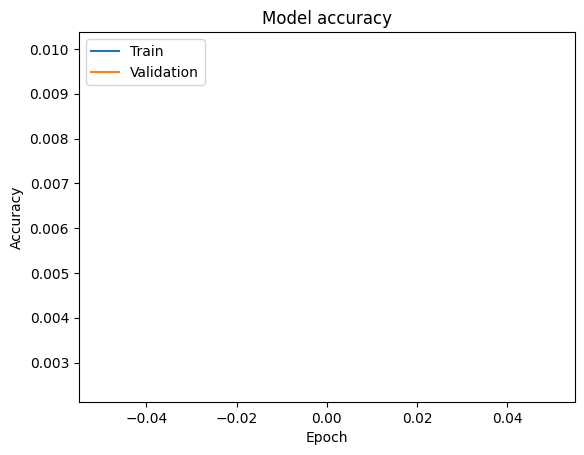

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub06\assets


Completed ROI:  V2 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 229)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 229)
X_val shape:  (100, 900)
y_val shape:  (100, 229)
25/25 [==============================] - 1s 32ms/step - loss: 135.4992 - accuracy: 0.0012 - val_loss: 0.2391 - val_accuracy: 0.0000e+00
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 676)               609076    
                                                                 
 dense_160 (Dense)           (None, 452)               306004    
                                                      

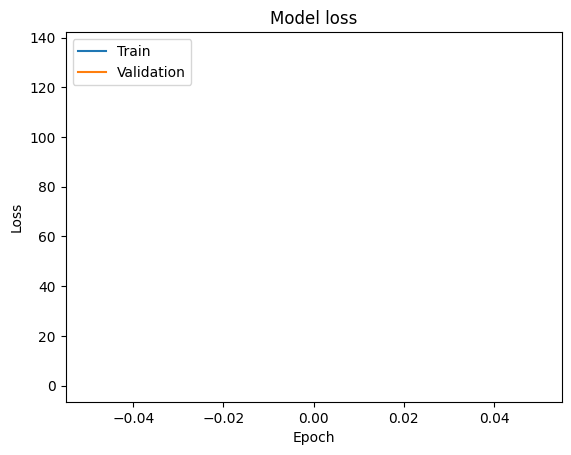

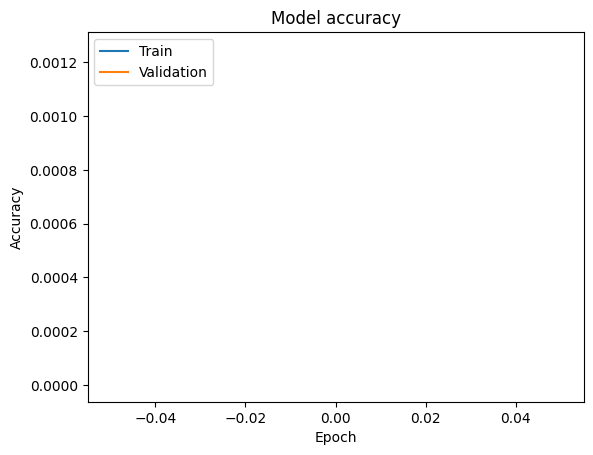

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub06\assets


Completed ROI:  V3 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 108)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 108)
X_val shape:  (100, 900)
y_val shape:  (100, 108)
25/25 [==============================] - 1s 18ms/step - loss: 165.6900 - accuracy: 0.0075 - val_loss: 1.9333 - val_accuracy: 0.0200
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_162 (Dense)           (None, 636)               573036    
                                                                 
 dense_163 (Dense)           (None, 372)               236964    
                                                          

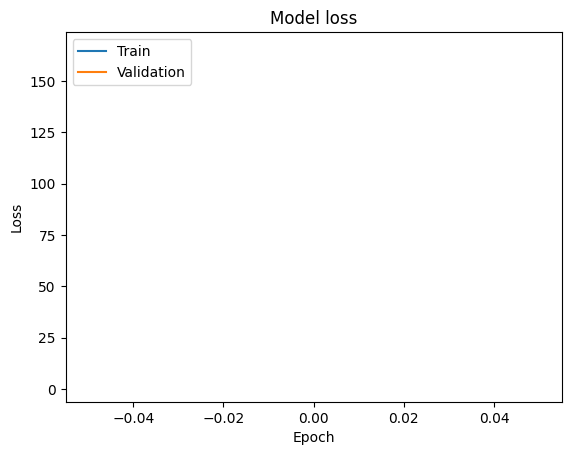

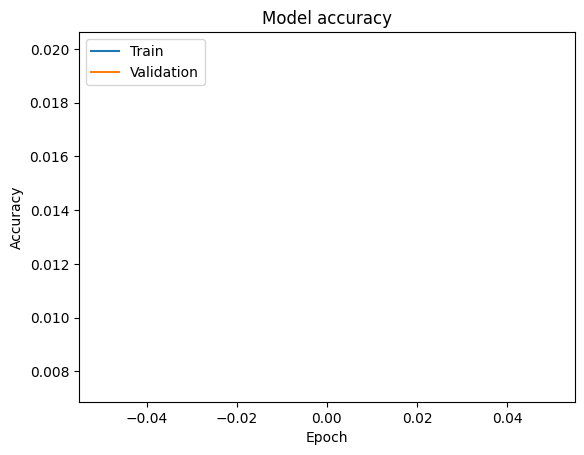

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub06\assets


Completed ROI:  V4 sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1356)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1356)
X_val shape:  (100, 900)
y_val shape:  (100, 1356)
25/25 [==============================] - 1s 28ms/step - loss: 51.2556 - accuracy: 0.0012 - val_loss: 0.2530 - val_accuracy: 0.0000e+00
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_165 (Dense)           (None, 1052)              947852    
                                                                 
 dense_166 (Dense)           (None, 1204)              1267812   
                                                   

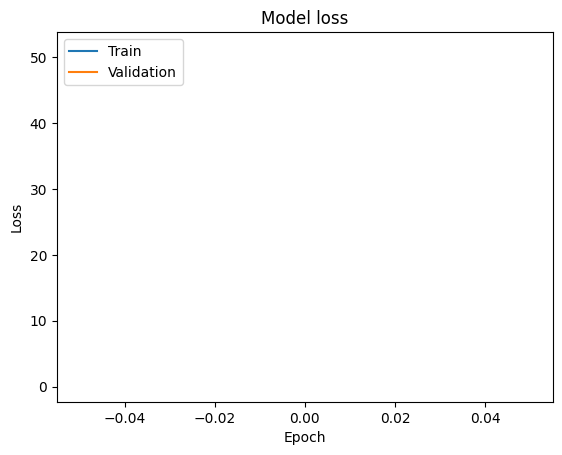

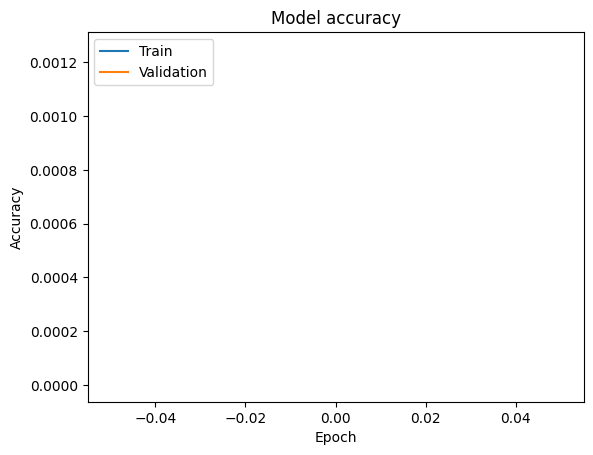

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub06\assets


Completed ROI:  LOC sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 308)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 308)
X_val shape:  (100, 900)
y_val shape:  (100, 308)
25/25 [==============================] - 1s 16ms/step - loss: 84.4255 - accuracy: 0.0037 - val_loss: 0.2466 - val_accuracy: 0.0000e+00
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 702)               632502    
                                                                 
 dense_169 (Dense)           (None, 505)               355015    
                                                     

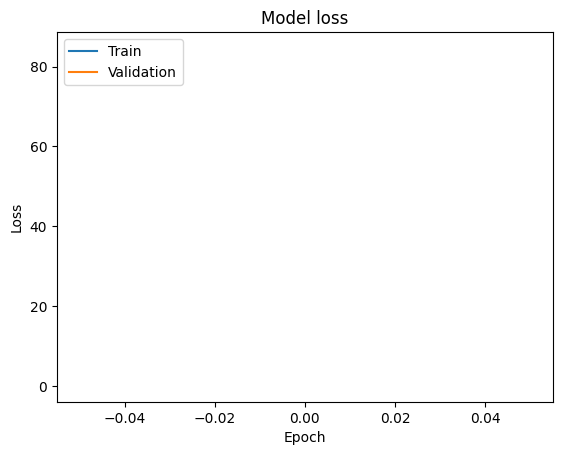

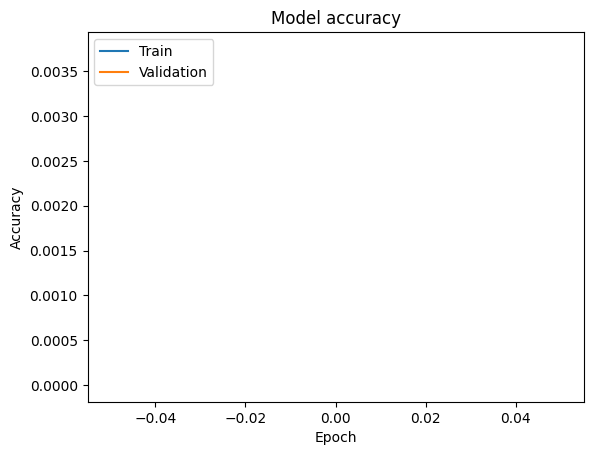

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub06\assets


Completed ROI:  EBA sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 119)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 119)
X_val shape:  (100, 900)
y_val shape:  (100, 119)
25/25 [==============================] - 1s 14ms/step - loss: 146.8868 - accuracy: 0.0088 - val_loss: 0.5368 - val_accuracy: 0.0100
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_171 (Dense)           (None, 639)               575739    
                                                                 
 dense_172 (Dense)           (None, 379)               242560    
                                                        

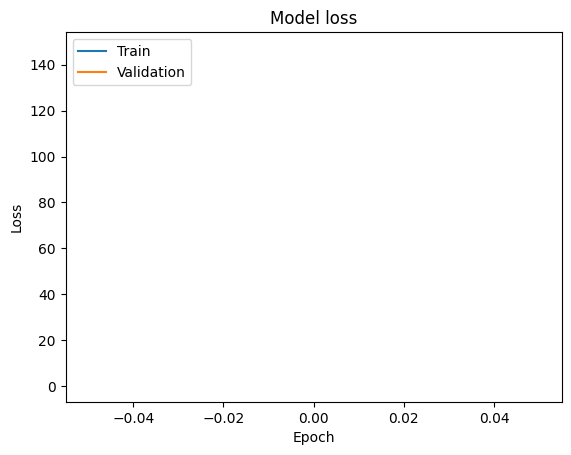

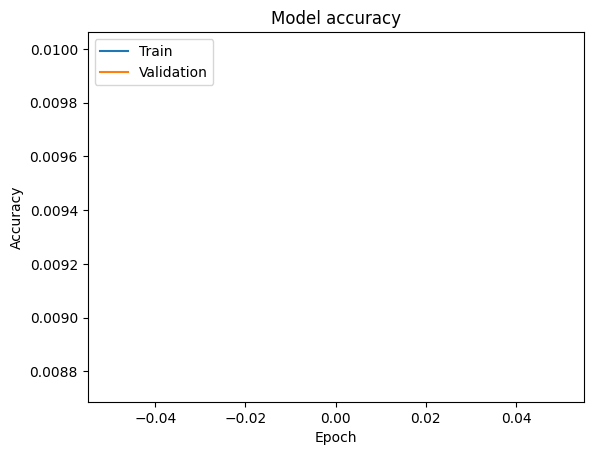

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub06\assets


Completed ROI:  FFA sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 173)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 173)
X_val shape:  (100, 900)
y_val shape:  (100, 173)
25/25 [==============================] - 1s 15ms/step - loss: 147.2543 - accuracy: 0.0050 - val_loss: 0.2315 - val_accuracy: 0.0100
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_174 (Dense)           (None, 657)               591957    
                                                                 
 dense_175 (Dense)           (None, 415)               273070    
                                                        

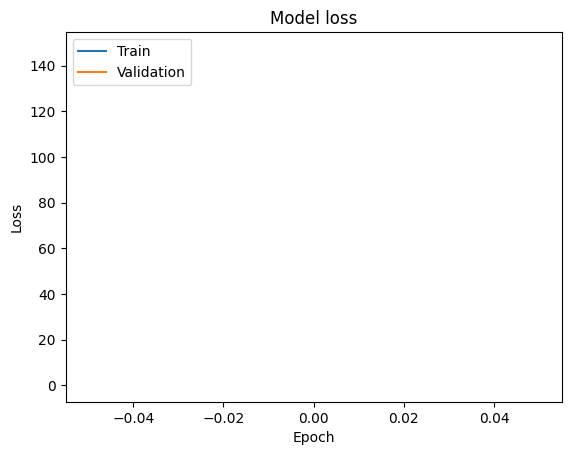

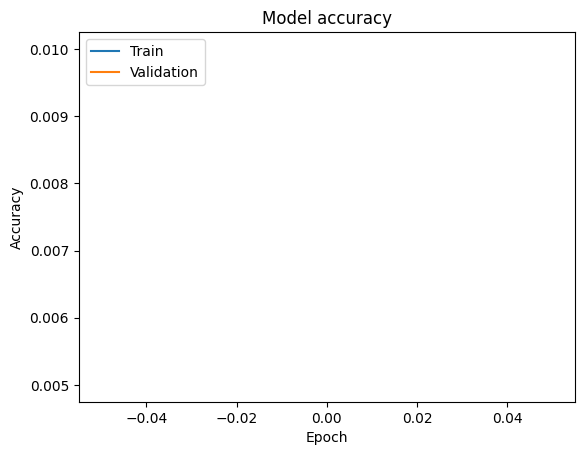

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub06\assets


Completed ROI:  STS sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub06
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 216)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 216)
X_val shape:  (100, 900)
y_val shape:  (100, 216)
25/25 [==============================] - 1s 15ms/step - loss: 138.2195 - accuracy: 0.0075 - val_loss: 0.2065 - val_accuracy: 0.0100
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_177 (Dense)           (None, 672)               605472    
                                                                 
 dense_178 (Dense)           (None, 444)               298812    
                                                        

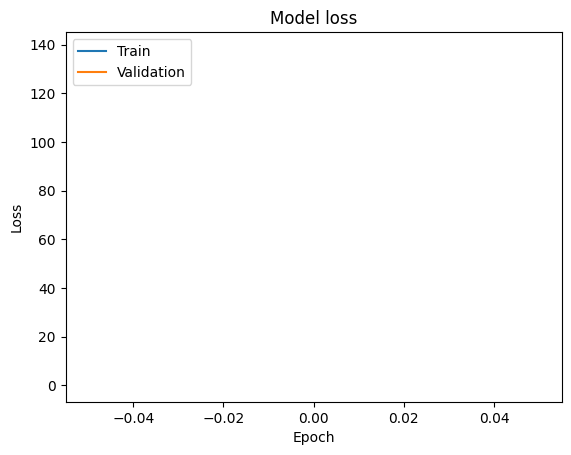

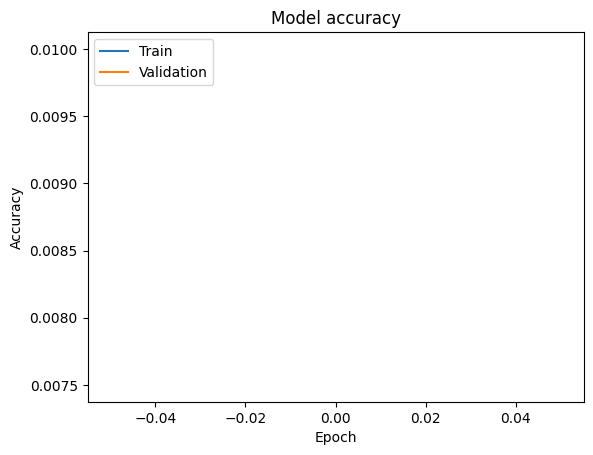

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub06
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub06\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub06\assets


Completed ROI:  PPA sub:  sub06
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 10836)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 10836)
X_val shape:  (100, 900)
y_val shape:  (100, 10836)
25/25 [==============================] - 10s 370ms/step - loss: 32.9289 - accuracy: 0.0000e+00 - val_loss: 0.2269 - val_accuracy: 0.0000e+00
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 4212)              3795012   
                                                                 
 dense_181 (Dense)           (None, 7524)              31698612  
                                          

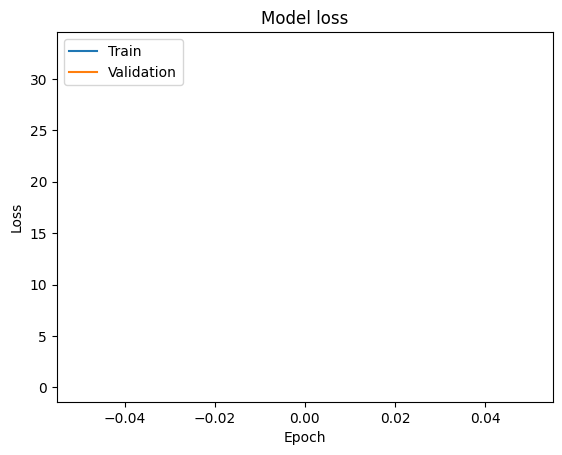

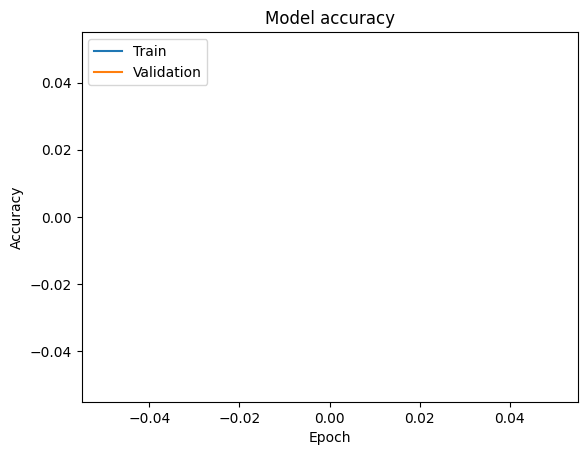

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub07\assets


Completed ROI:  WB sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 195)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 195)
X_val shape:  (100, 900)
y_val shape:  (100, 195)
25/25 [==============================] - 1s 16ms/step - loss: 171.6438 - accuracy: 0.0037 - val_loss: 0.2580 - val_accuracy: 0.0100
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_183 (Dense)           (None, 665)               599165    
                                                                 
 dense_184 (Dense)           (None, 430)               286380    
                                                          

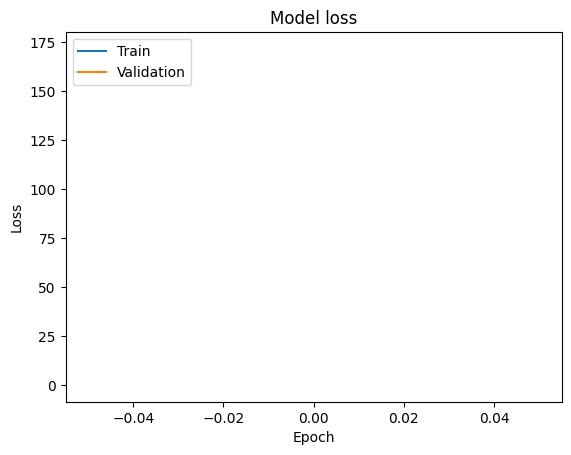

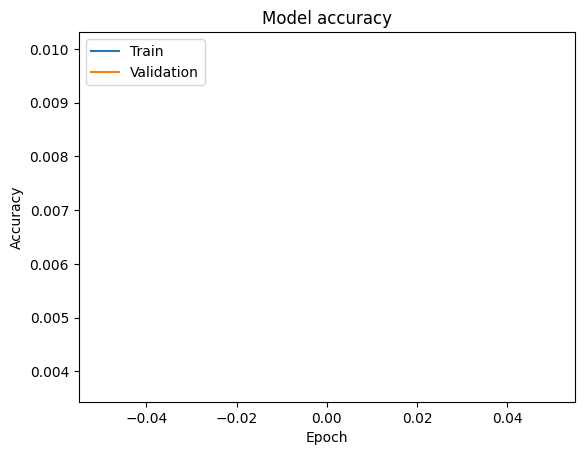

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub07\assets


Completed ROI:  V1 sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 189)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 189)
X_val shape:  (100, 900)
y_val shape:  (100, 189)
25/25 [==============================] - 1s 16ms/step - loss: 199.1482 - accuracy: 0.0050 - val_loss: 0.2829 - val_accuracy: 0.0000e+00
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_186 (Dense)           (None, 663)               597363    
                                                                 
 dense_187 (Dense)           (None, 426)               282864    
                                                      

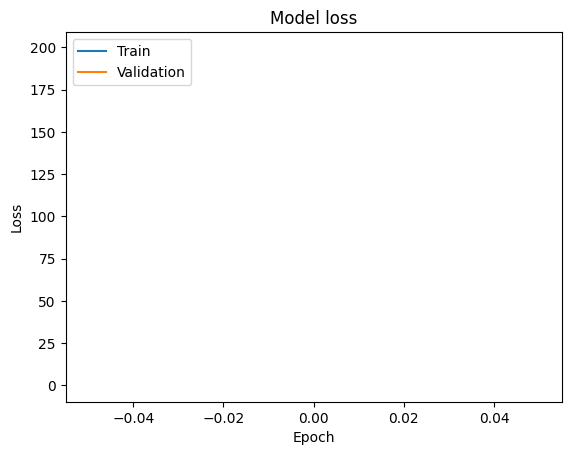

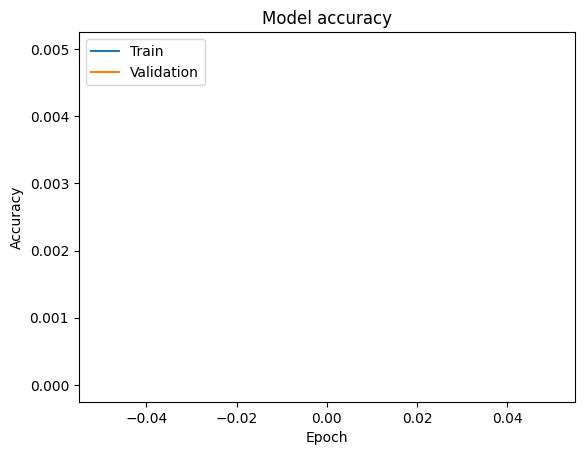

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub07\assets


Completed ROI:  V2 sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 174)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 174)
X_val shape:  (100, 900)
y_val shape:  (100, 174)
25/25 [==============================] - 1s 13ms/step - loss: 143.6122 - accuracy: 0.0050 - val_loss: 0.2553 - val_accuracy: 0.0200
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_189 (Dense)           (None, 658)               592858    
                                                                 
 dense_190 (Dense)           (None, 416)               274144    
                                                          

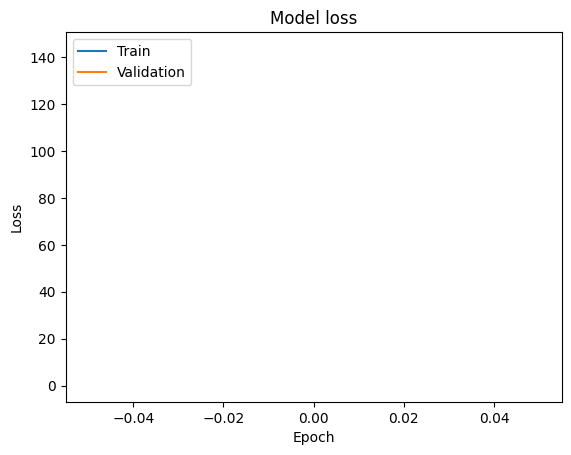

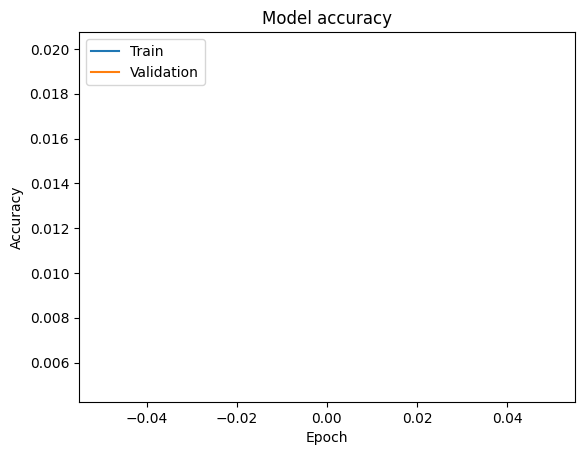

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub07\assets


Completed ROI:  V3 sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 55)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 55)
X_val shape:  (100, 900)
y_val shape:  (100, 55)
25/25 [==============================] - 1s 13ms/step - loss: 238.1693 - accuracy: 0.0213 - val_loss: 15.4383 - val_accuracy: 0.0200
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_192 (Dense)           (None, 618)               556818    
                                                                 
 dense_193 (Dense)           (None, 336)               207984    
                                                            

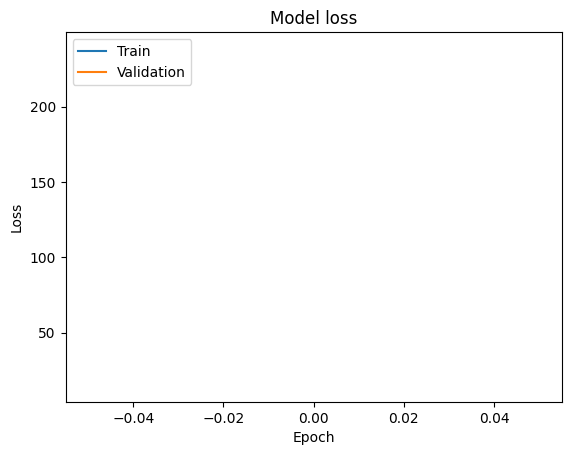

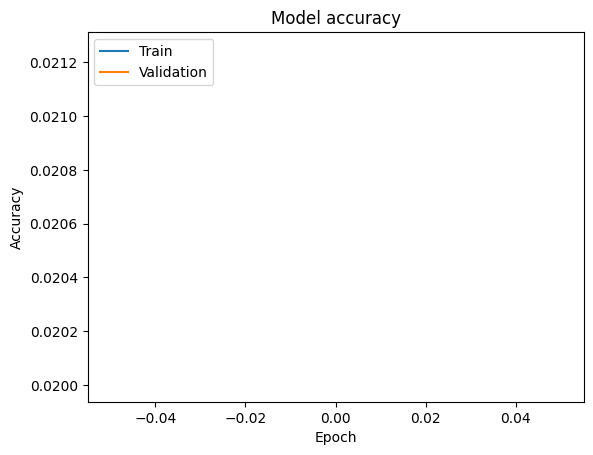

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub07\assets


Completed ROI:  V4 sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1117)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1117)
X_val shape:  (100, 900)
y_val shape:  (100, 1117)
25/25 [==============================] - 1s 24ms/step - loss: 52.9612 - accuracy: 0.0000e+00 - val_loss: 0.2618 - val_accuracy: 0.0000e+00
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_195 (Dense)           (None, 972)               875772    
                                                                 
 dense_196 (Dense)           (None, 1044)              1015812   
                                               

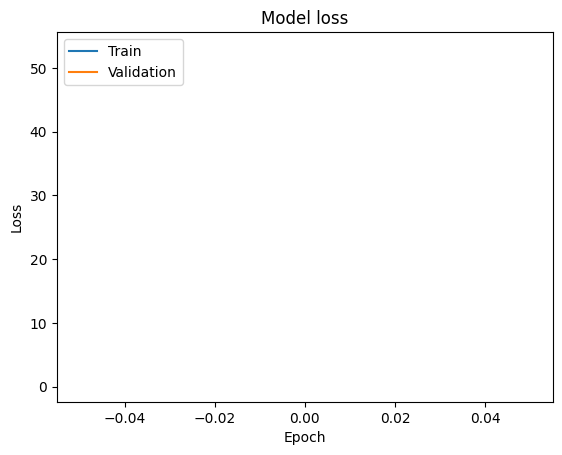

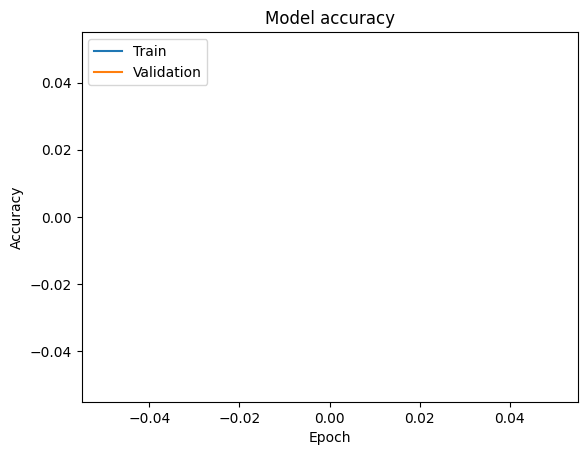

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub07\assets


Completed ROI:  LOC sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 101)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 101)
X_val shape:  (100, 900)
y_val shape:  (100, 101)
25/25 [==============================] - 1s 14ms/step - loss: 172.1569 - accuracy: 0.0125 - val_loss: 0.6971 - val_accuracy: 0.0000e+00
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 633)               570333    
                                                                 
 dense_199 (Dense)           (None, 367)               232678    
                                                    

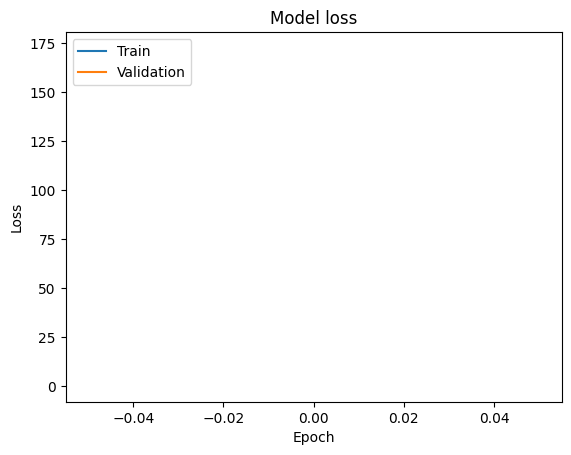

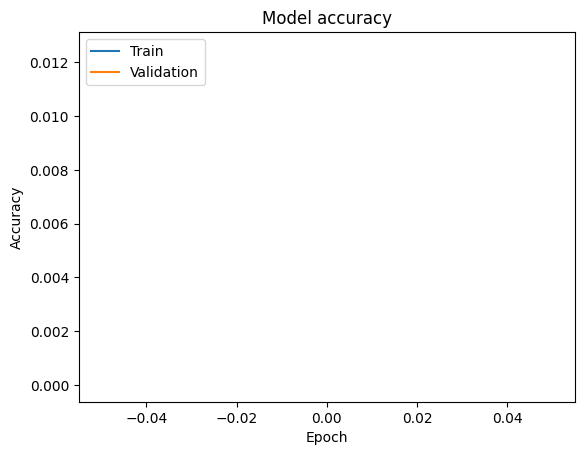

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub07\assets


Completed ROI:  EBA sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 89)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 89)
X_val shape:  (100, 900)
y_val shape:  (100, 89)
25/25 [==============================] - 1s 14ms/step - loss: 242.9599 - accuracy: 0.0113 - val_loss: 7.8353 - val_accuracy: 0.0100
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_201 (Dense)           (None, 629)               566729    
                                                                 
 dense_202 (Dense)           (None, 359)               226170    
                                                           

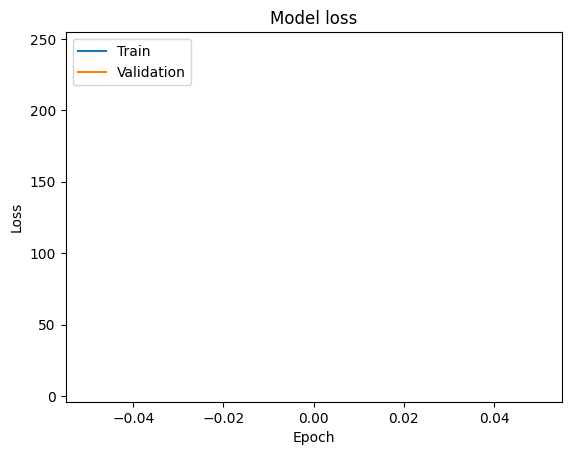

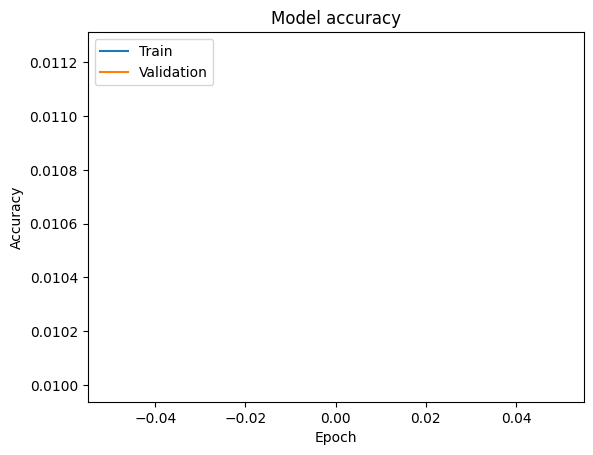

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub07\assets


Completed ROI:  FFA sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 80)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 80)
X_val shape:  (100, 900)
y_val shape:  (100, 80)
25/25 [==============================] - 1s 14ms/step - loss: 215.4296 - accuracy: 0.0150 - val_loss: 8.9470 - val_accuracy: 0.0200
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 626)               564026    
                                                                 
 dense_205 (Dense)           (None, 353)               221331    
                                                           

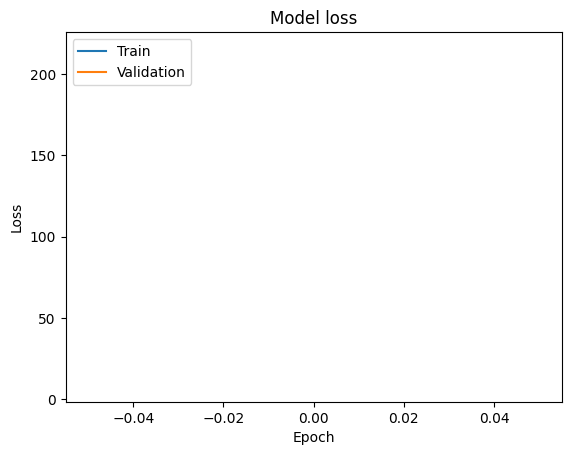

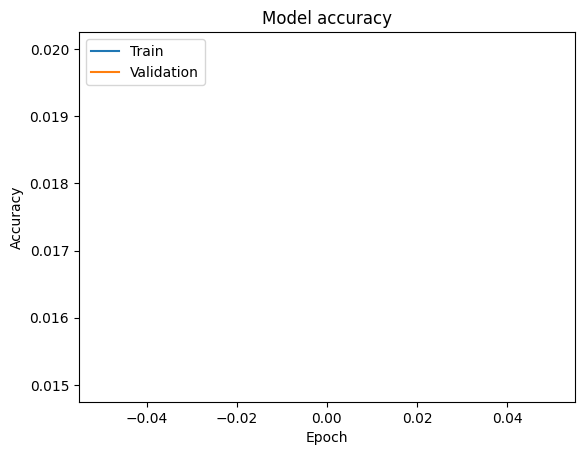

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub07\assets


Completed ROI:  STS sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub07
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 33)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 33)
X_val shape:  (100, 900)
y_val shape:  (100, 33)
25/25 [==============================] - 1s 12ms/step - loss: 328.1429 - accuracy: 0.0225 - val_loss: 24.8230 - val_accuracy: 0.0000e+00
Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_207 (Dense)           (None, 611)               550511    
                                                                 
 dense_208 (Dense)           (None, 322)               197064    
                                                      

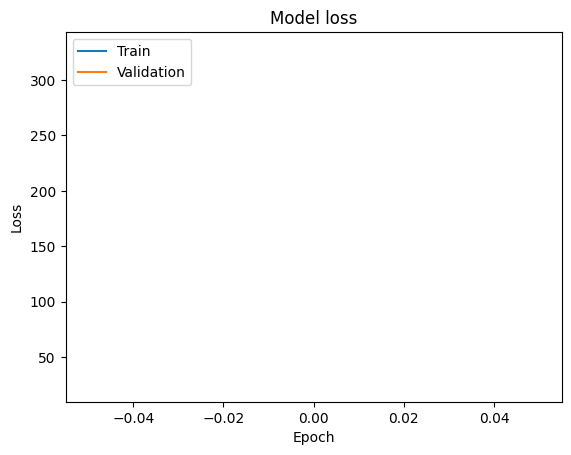

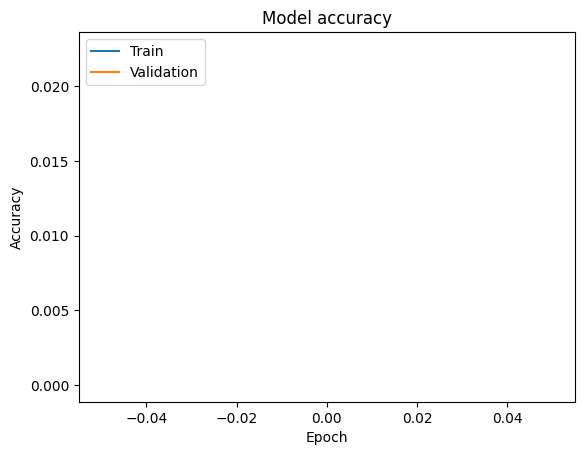

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub07
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub07\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub07\assets


Completed ROI:  PPA sub:  sub07
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 12347)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 12347)
X_val shape:  (100, 900)
y_val shape:  (100, 12347)
25/25 [==============================] - 13s 508ms/step - loss: 35.1650 - accuracy: 0.0000e+00 - val_loss: 0.2135 - val_accuracy: 0.0000e+00
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, 4715)              4248215   
                                                                 
 dense_211 (Dense)           (None, 8531)              40232196  
                                          

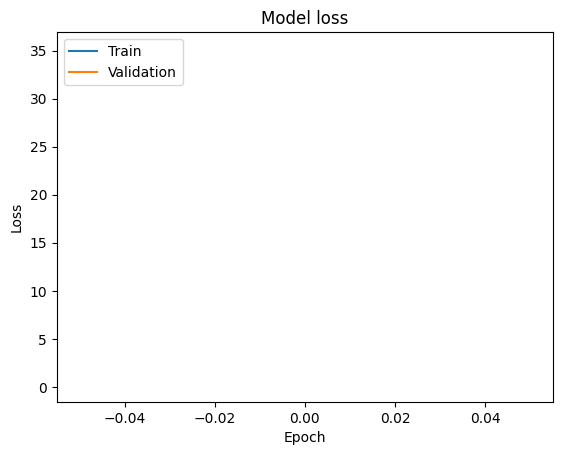

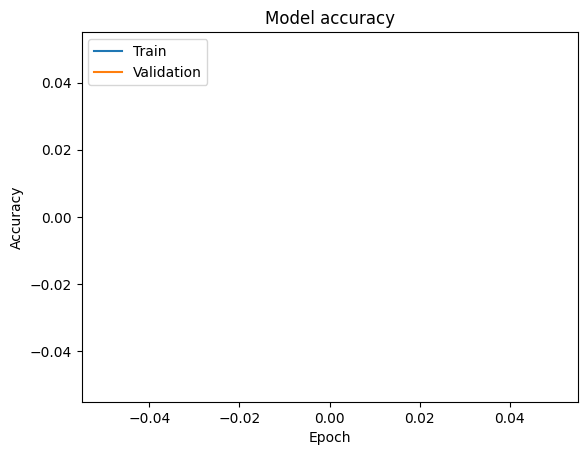

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub08\assets


Completed ROI:  WB sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 300)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 300)
X_val shape:  (100, 900)
y_val shape:  (100, 300)
25/25 [==============================] - 1s 18ms/step - loss: 115.6024 - accuracy: 0.0025 - val_loss: 0.2467 - val_accuracy: 0.0100
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_213 (Dense)           (None, 700)               630700    
                                                                 
 dense_214 (Dense)           (None, 500)               350500    
                                                          

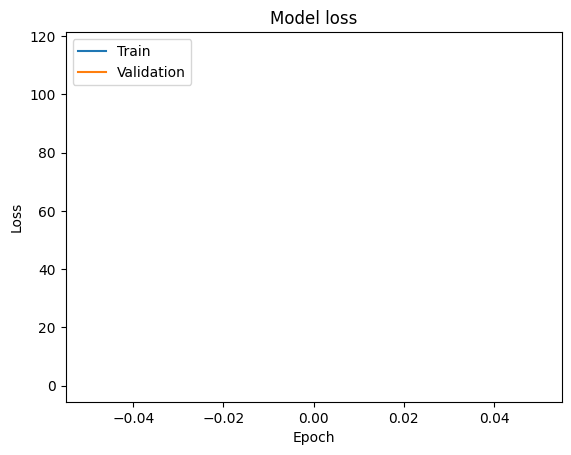

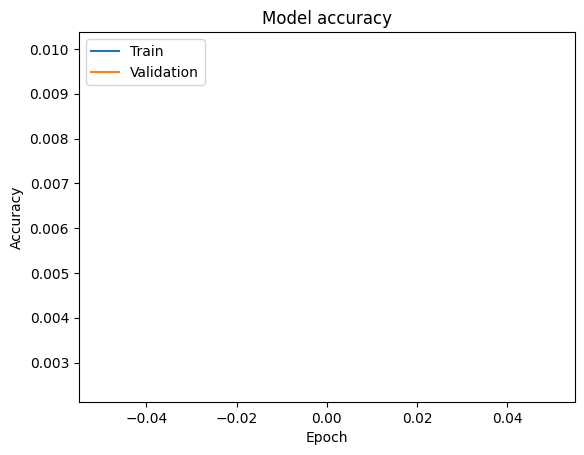

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub08\assets


Completed ROI:  V1 sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 238)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 238)
X_val shape:  (100, 900)
y_val shape:  (100, 238)
25/25 [==============================] - 1s 16ms/step - loss: 159.2997 - accuracy: 0.0025 - val_loss: 0.2345 - val_accuracy: 0.0100
Model: "sequential_72"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 679)               611779    
                                                                 
 dense_217 (Dense)           (None, 458)               311440    
                                                          

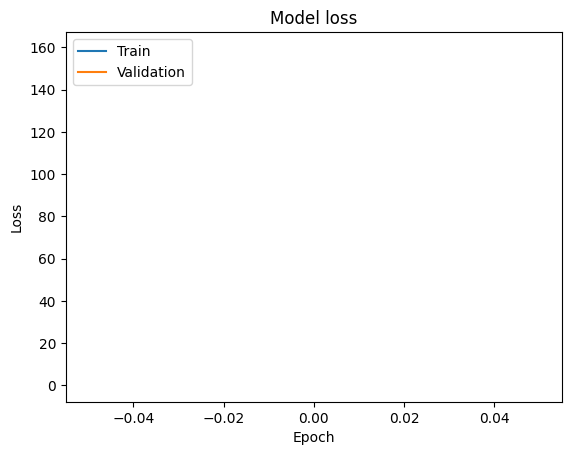

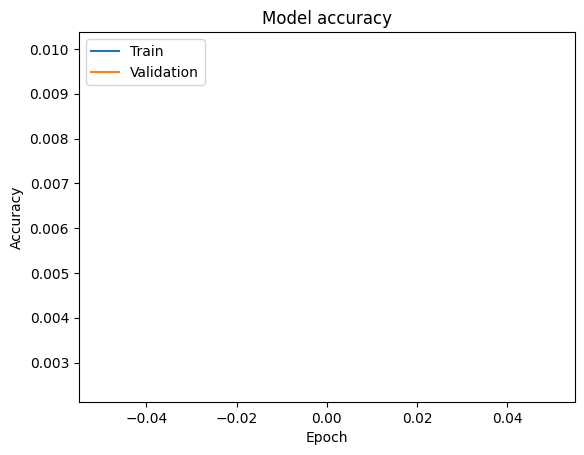

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub08\assets


Completed ROI:  V2 sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 223)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 223)
X_val shape:  (100, 900)
y_val shape:  (100, 223)
25/25 [==============================] - 1s 16ms/step - loss: 98.8980 - accuracy: 0.0025 - val_loss: 0.2272 - val_accuracy: 0.0000e+00
Model: "sequential_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_219 (Dense)           (None, 674)               607274    
                                                                 
 dense_220 (Dense)           (None, 448)               302400    
                                                       

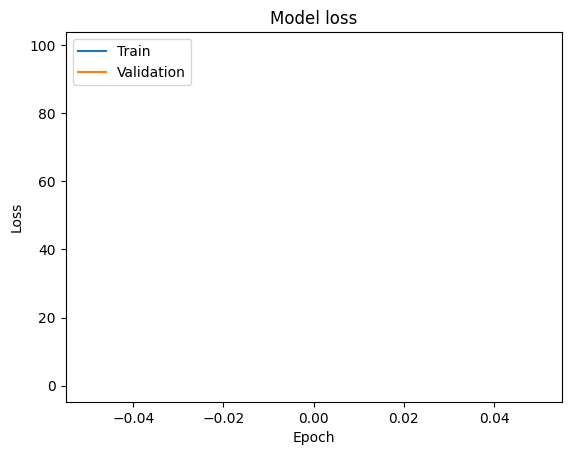

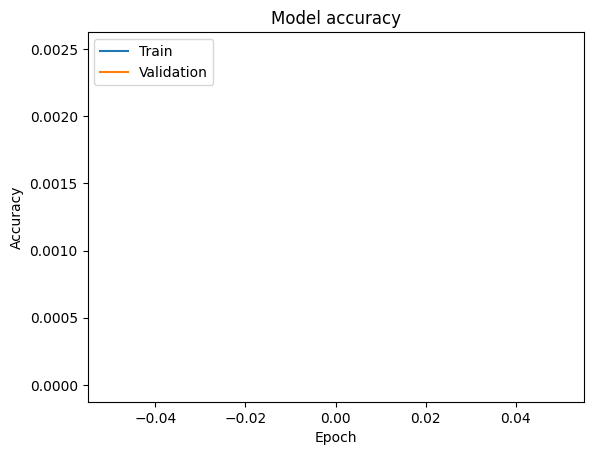

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub08\assets


Completed ROI:  V3 sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 85)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 85)
X_val shape:  (100, 900)
y_val shape:  (100, 85)
25/25 [==============================] - 1s 13ms/step - loss: 225.7862 - accuracy: 0.0063 - val_loss: 6.3002 - val_accuracy: 0.0200
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_222 (Dense)           (None, 628)               565828    
                                                                 
 dense_223 (Dense)           (None, 356)               223924    
                                                             

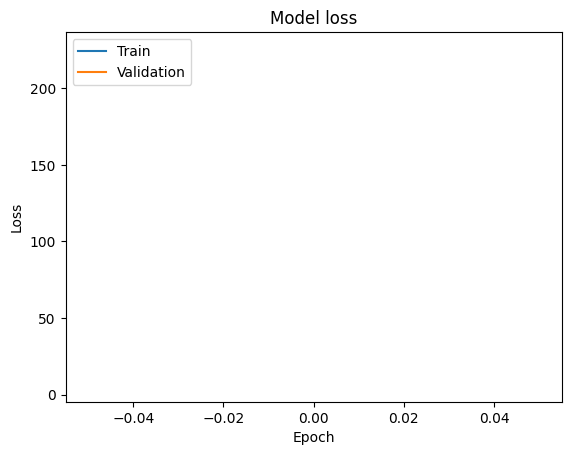

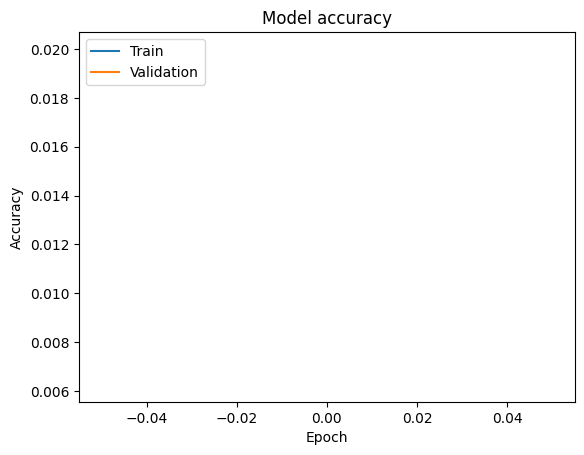

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub08\assets


Completed ROI:  V4 sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1244)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1244)
X_val shape:  (100, 900)
y_val shape:  (100, 1244)
25/25 [==============================] - 1s 26ms/step - loss: 49.0940 - accuracy: 0.0000e+00 - val_loss: 0.2518 - val_accuracy: 0.0000e+00
Model: "sequential_75"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_225 (Dense)           (None, 1014)              913614    
                                                                 
 dense_226 (Dense)           (None, 1129)              1145935   
                                               

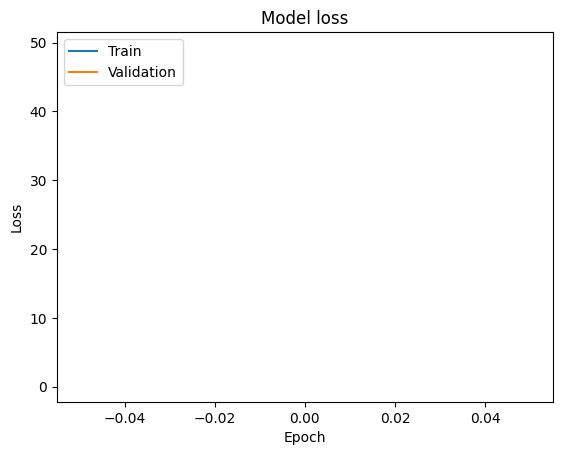

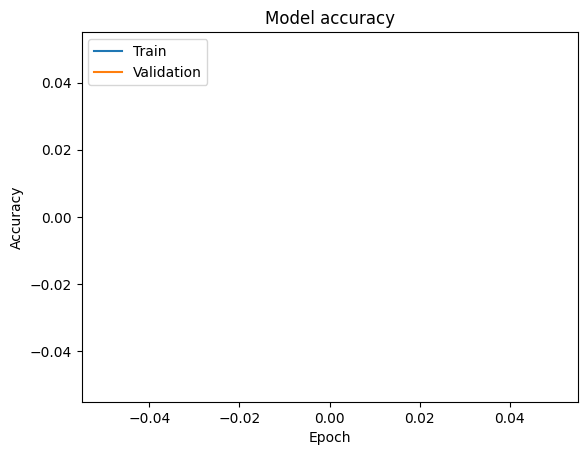

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub08\assets


Completed ROI:  LOC sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 55)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 55)
X_val shape:  (100, 900)
y_val shape:  (100, 55)
25/25 [==============================] - 1s 14ms/step - loss: 278.1981 - accuracy: 0.0188 - val_loss: 15.8737 - val_accuracy: 0.0300
Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 618)               556818    
                                                                 
 dense_229 (Dense)           (None, 336)               207984    
                                                          

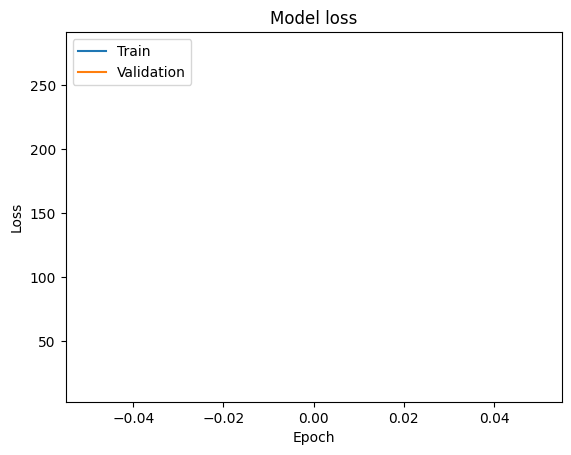

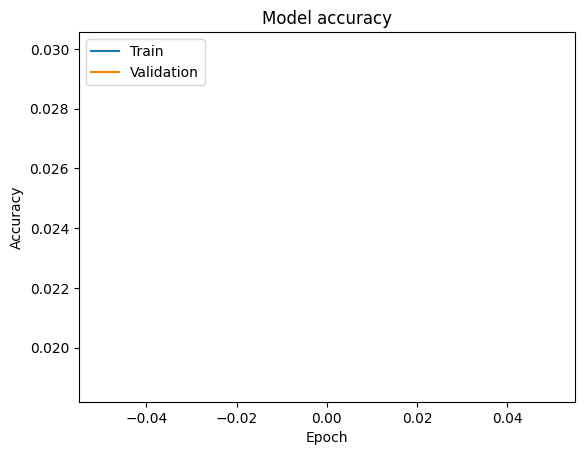

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub08\assets


Completed ROI:  EBA sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 163)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 163)
X_val shape:  (100, 900)
y_val shape:  (100, 163)
25/25 [==============================] - 1s 14ms/step - loss: 141.3114 - accuracy: 0.0075 - val_loss: 0.2508 - val_accuracy: 0.0000e+00
Model: "sequential_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_231 (Dense)           (None, 654)               589254    
                                                                 
 dense_232 (Dense)           (None, 408)               267240    
                                                    

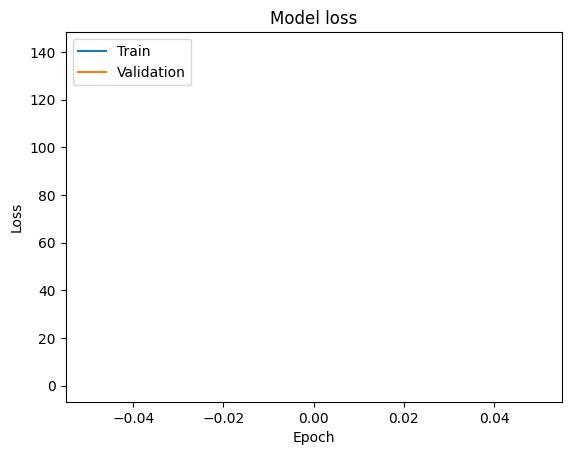

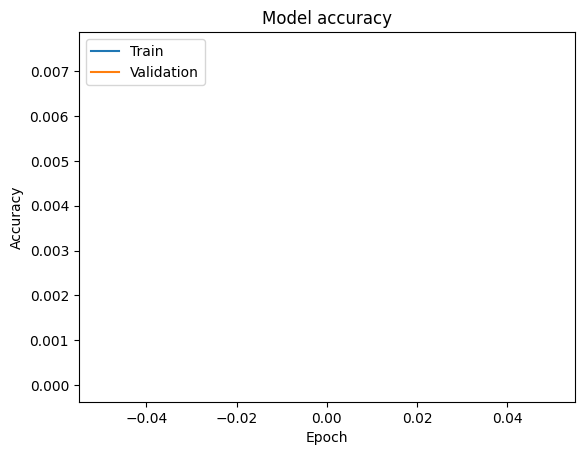

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub08\assets


Completed ROI:  FFA sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 306)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 306)
X_val shape:  (100, 900)
y_val shape:  (100, 306)
25/25 [==============================] - 1s 16ms/step - loss: 92.2758 - accuracy: 0.0025 - val_loss: 0.2592 - val_accuracy: 0.0000e+00
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_234 (Dense)           (None, 702)               632502    
                                                                 
 dense_235 (Dense)           (None, 504)               354312    
                                                     

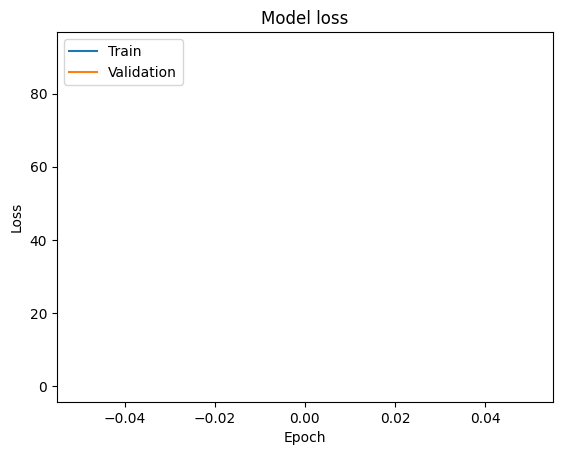

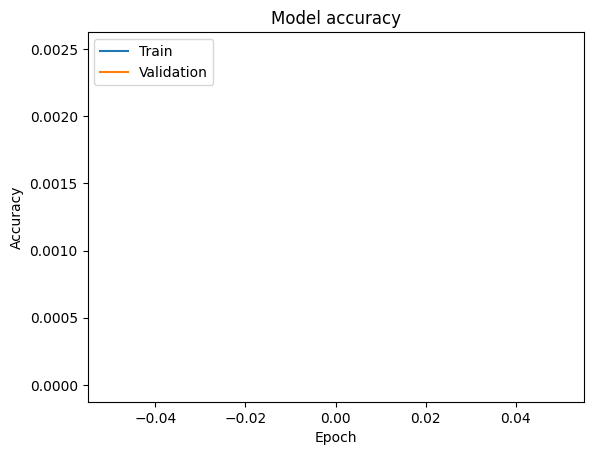

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub08\assets


Completed ROI:  STS sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub08
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 150)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 150)
X_val shape:  (100, 900)
y_val shape:  (100, 150)
25/25 [==============================] - 1s 12ms/step - loss: 163.4645 - accuracy: 0.0088 - val_loss: 0.2001 - val_accuracy: 0.0000e+00
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_237 (Dense)           (None, 650)               585650    
                                                                 
 dense_238 (Dense)           (None, 400)               260400    
                                                    

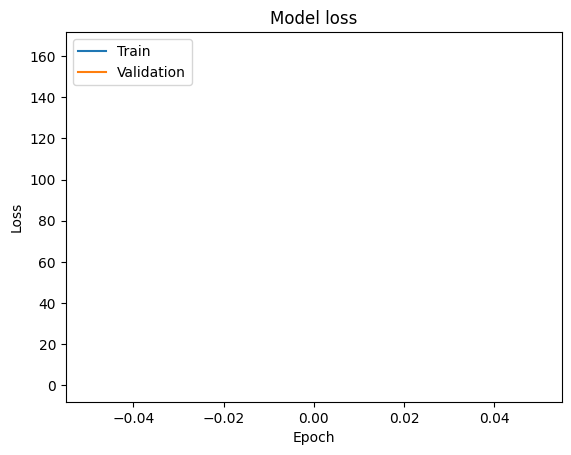

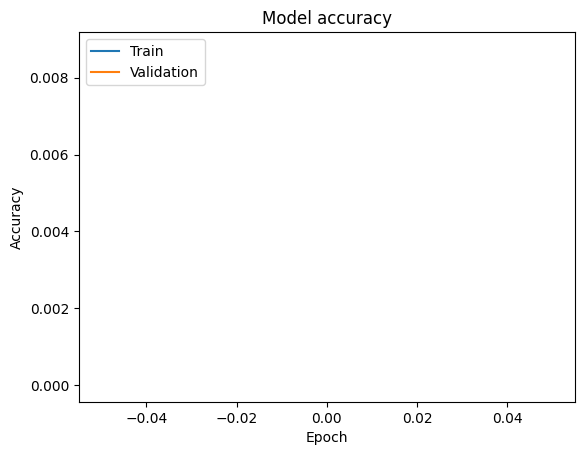

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub08
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub08\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub08\assets


Completed ROI:  PPA sub:  sub08
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 17570)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 17570)
X_val shape:  (100, 900)
y_val shape:  (100, 17570)
25/25 [==============================] - 30s 973ms/step - loss: 54.5756 - accuracy: 0.0000e+00 - val_loss: 0.2016 - val_accuracy: 0.0000e+00
Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, 6456)              5816856   
                                                                 
 dense_241 (Dense)           (None, 12013)             77567941  
                                          

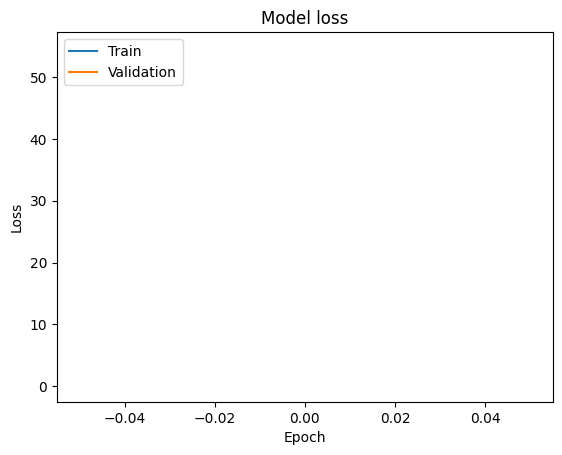

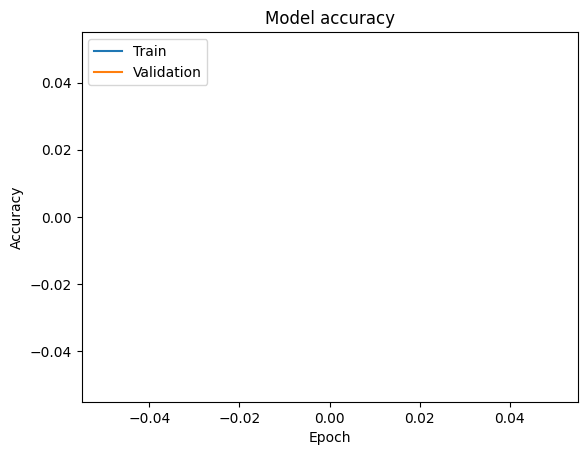

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub09\assets


Completed ROI:  WB sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 271)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 271)
X_val shape:  (100, 900)
y_val shape:  (100, 271)
25/25 [==============================] - 1s 20ms/step - loss: 116.4053 - accuracy: 0.0012 - val_loss: 0.2258 - val_accuracy: 0.0000e+00
Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_243 (Dense)           (None, 690)               621690    
                                                                 
 dense_244 (Dense)           (None, 480)               331680    
                                                      

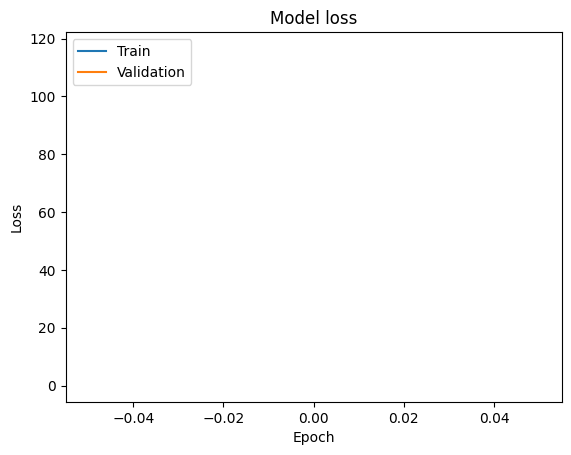

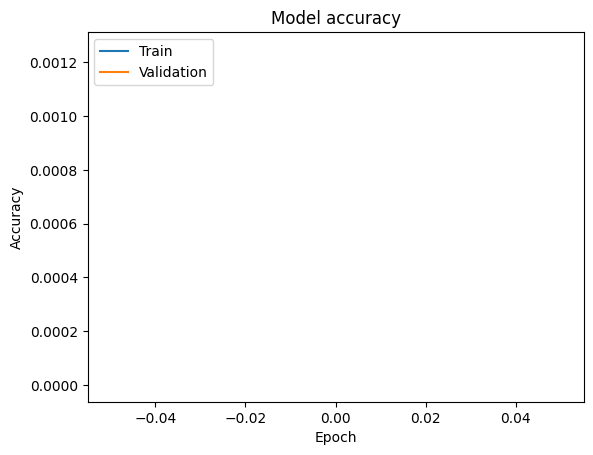

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub09\assets


Completed ROI:  V1 sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 265)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 265)
X_val shape:  (100, 900)
y_val shape:  (100, 265)
25/25 [==============================] - 1s 18ms/step - loss: 100.4026 - accuracy: 0.0037 - val_loss: 0.2261 - val_accuracy: 0.0000e+00
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_246 (Dense)           (None, 688)               619888    
                                                                 
 dense_247 (Dense)           (None, 476)               327964    
                                                      

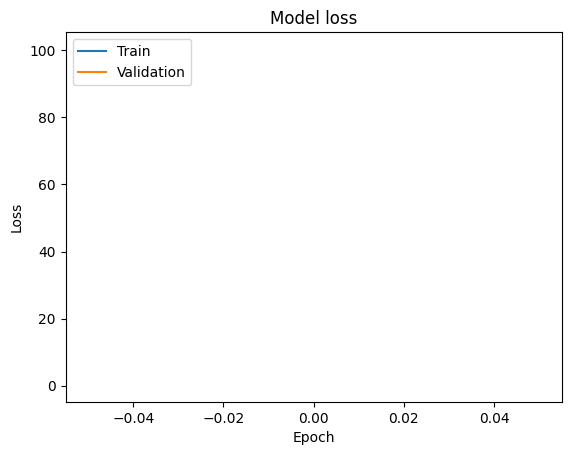

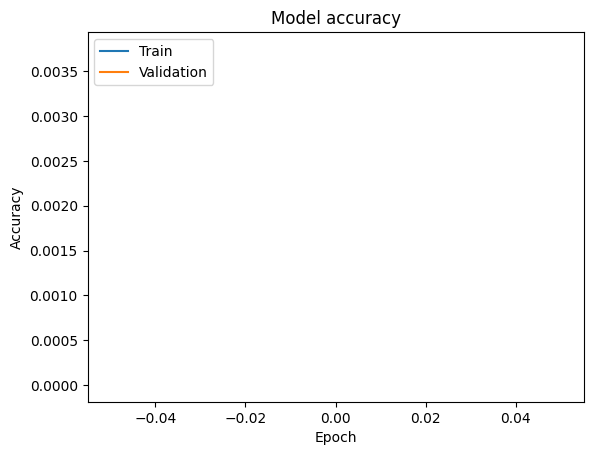

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub09\assets


Completed ROI:  V2 sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 245)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 245)
X_val shape:  (100, 900)
y_val shape:  (100, 245)
25/25 [==============================] - 1s 18ms/step - loss: 117.0119 - accuracy: 0.0037 - val_loss: 0.2347 - val_accuracy: 0.0200
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_249 (Dense)           (None, 681)               613581    
                                                                 
 dense_250 (Dense)           (None, 463)               315766    
                                                          

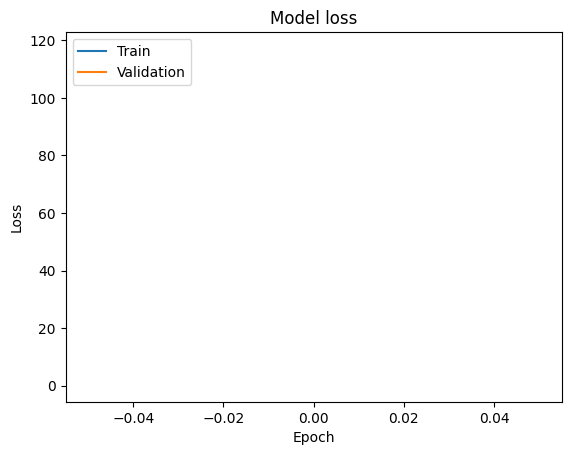

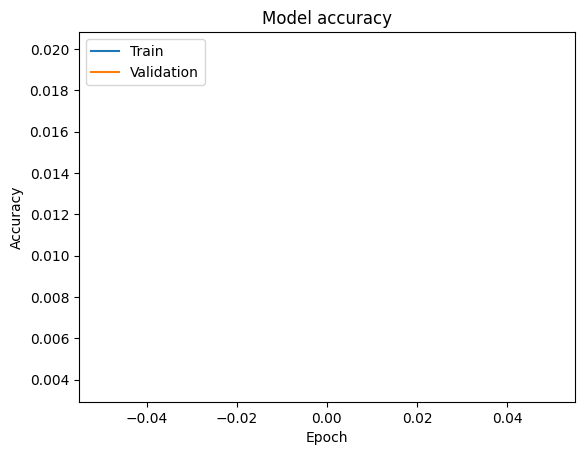

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub09\assets


Completed ROI:  V3 sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 94)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 94)
X_val shape:  (100, 900)
y_val shape:  (100, 94)
25/25 [==============================] - 1s 16ms/step - loss: 194.0773 - accuracy: 0.0063 - val_loss: 2.7570 - val_accuracy: 0.0300
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_252 (Dense)           (None, 631)               568531    
                                                                 
 dense_253 (Dense)           (None, 362)               228784    
                                                             

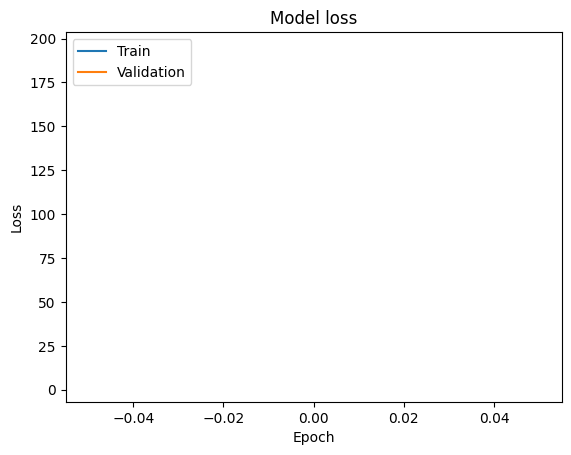

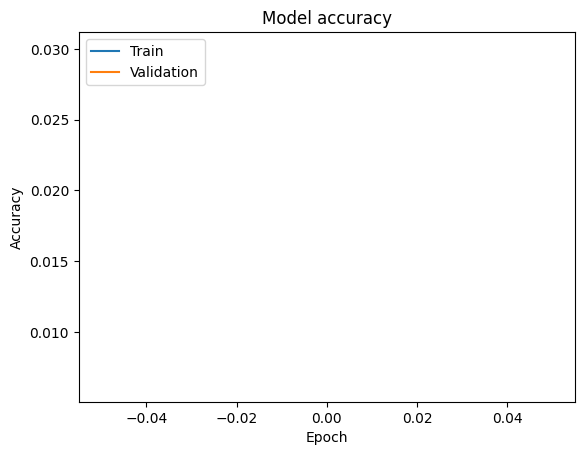

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub09\assets


Completed ROI:  V4 sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1515)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1515)
X_val shape:  (100, 900)
y_val shape:  (100, 1515)
25/25 [==============================] - 1s 28ms/step - loss: 41.2650 - accuracy: 0.0000e+00 - val_loss: 0.2381 - val_accuracy: 0.0000e+00
Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_255 (Dense)           (None, 1105)              995605    
                                                                 
 dense_256 (Dense)           (None, 1310)              1448860   
                                               

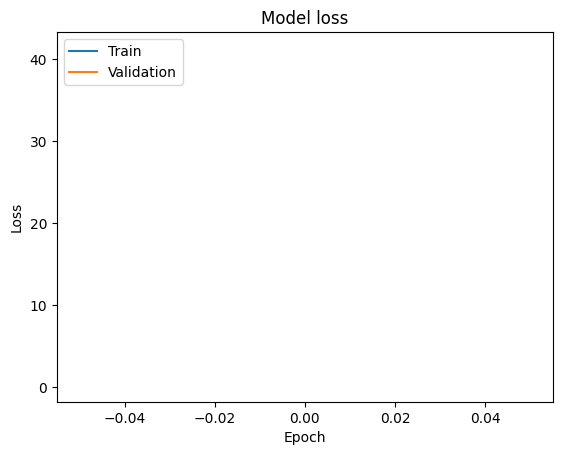

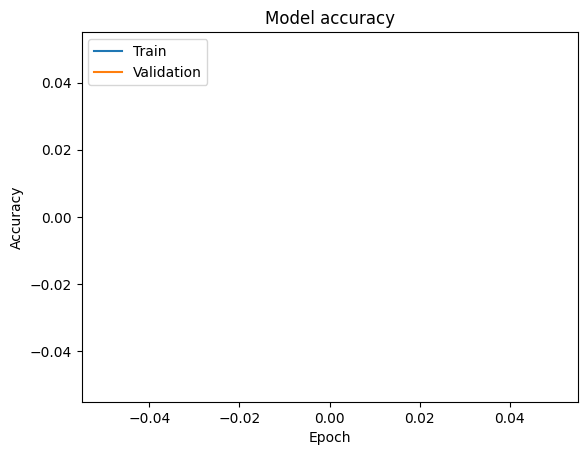

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub09\assets


Completed ROI:  LOC sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 191)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 191)
X_val shape:  (100, 900)
y_val shape:  (100, 191)
25/25 [==============================] - 1s 16ms/step - loss: 153.7739 - accuracy: 0.0037 - val_loss: 0.2510 - val_accuracy: 0.0200
Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_258 (Dense)           (None, 663)               597363    
                                                                 
 dense_259 (Dense)           (None, 427)               283528    
                                                        

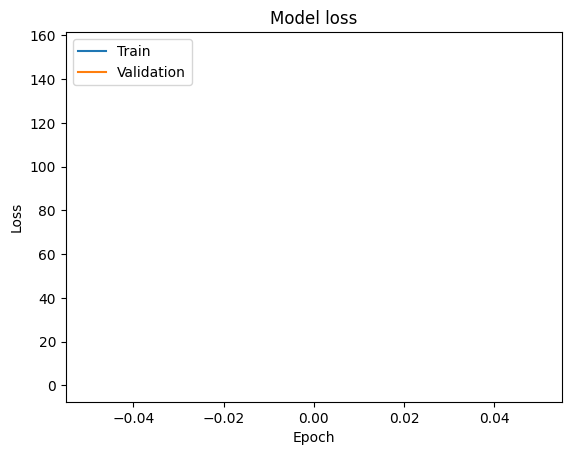

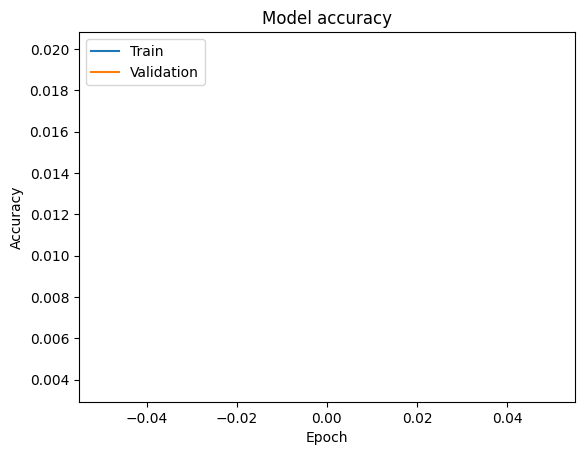

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub09\assets


Completed ROI:  EBA sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 76)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 76)
X_val shape:  (100, 900)
y_val shape:  (100, 76)
25/25 [==============================] - 1s 16ms/step - loss: 223.6916 - accuracy: 0.0175 - val_loss: 10.1319 - val_accuracy: 0.0100
Model: "sequential_87"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_261 (Dense)           (None, 625)               563125    
                                                                 
 dense_262 (Dense)           (None, 350)               219100    
                                                          

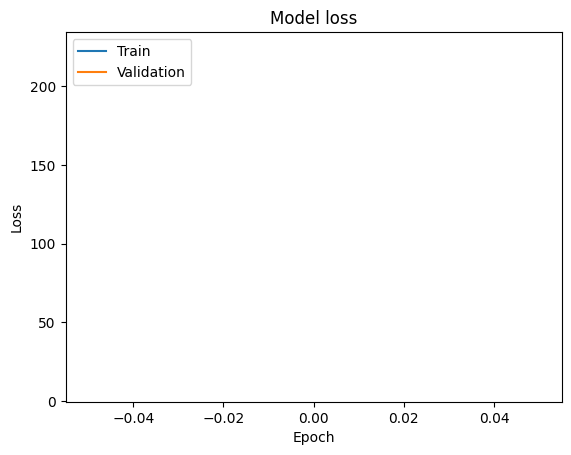

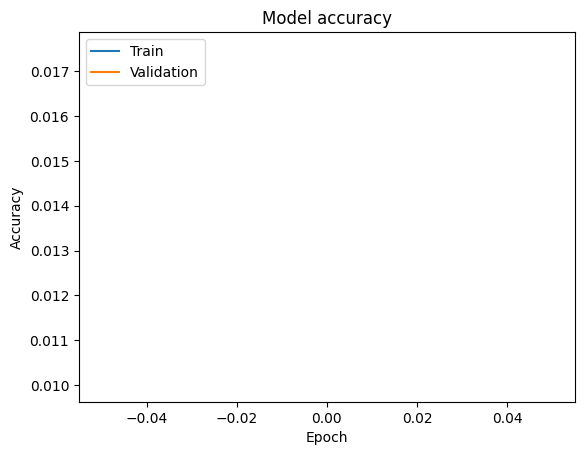

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub09\assets


Completed ROI:  FFA sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 346)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 346)
X_val shape:  (100, 900)
y_val shape:  (100, 346)
25/25 [==============================] - 1s 16ms/step - loss: 108.8525 - accuracy: 0.0037 - val_loss: 0.1982 - val_accuracy: 0.0000e+00
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_264 (Dense)           (None, 715)               644215    
                                                                 
 dense_265 (Dense)           (None, 530)               379480    
                                                    

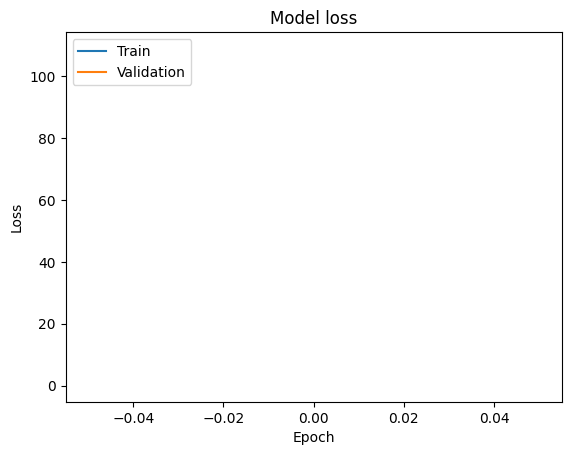

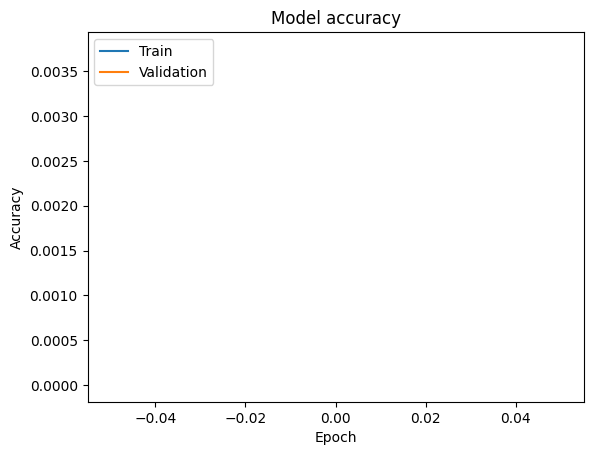

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub09\assets


Completed ROI:  STS sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub09
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 262)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 262)
X_val shape:  (100, 900)
y_val shape:  (100, 262)
25/25 [==============================] - 1s 17ms/step - loss: 110.4801 - accuracy: 0.0037 - val_loss: 0.1886 - val_accuracy: 0.0000e+00
Model: "sequential_89"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_267 (Dense)           (None, 687)               618987    
                                                                 
 dense_268 (Dense)           (None, 474)               326112    
                                                    

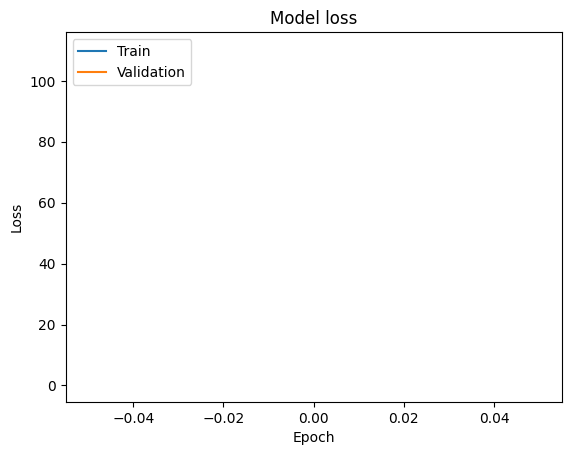

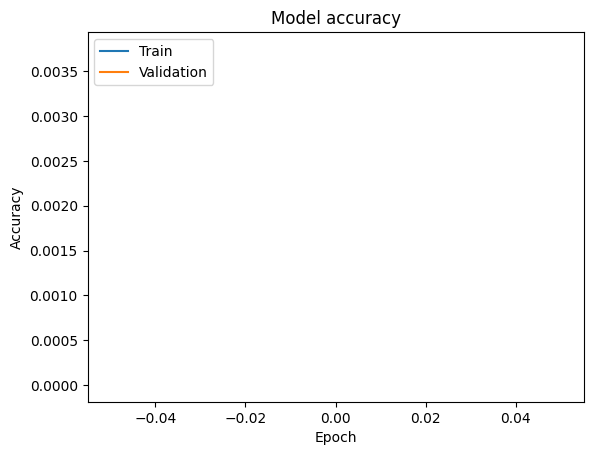

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub09
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub09\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub09\assets


Completed ROI:  PPA sub:  sub09
----------------------------------------------------------------------------
Starting ROI:  WB sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 12950)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 12950)
X_val shape:  (100, 900)
y_val shape:  (100, 12950)
25/25 [==============================] - 15s 571ms/step - loss: 40.4490 - accuracy: 0.0000e+00 - val_loss: 0.2065 - val_accuracy: 0.0000e+00
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_270 (Dense)           (None, 4916)              4429316   
                                                                 
 dense_271 (Dense)           (None, 8933)              43923561  
                                          

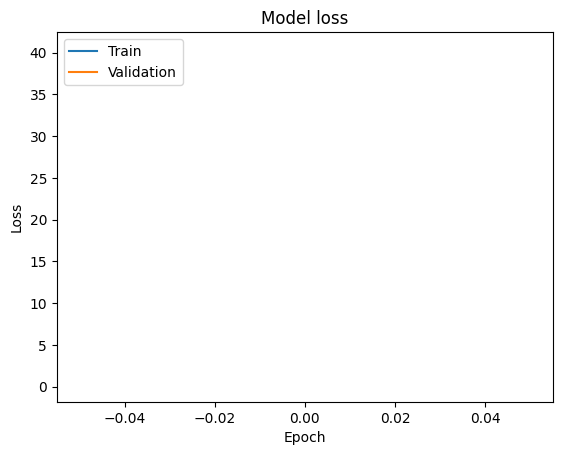

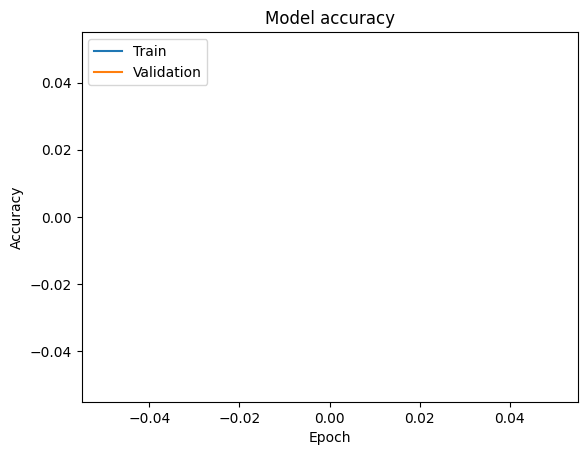

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\WB\sub10\assets


Completed ROI:  WB sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  V1 sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 238)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 238)
X_val shape:  (100, 900)
y_val shape:  (100, 238)
25/25 [==============================] - 1s 16ms/step - loss: 145.3509 - accuracy: 0.0037 - val_loss: 0.2341 - val_accuracy: 0.0100
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_273 (Dense)           (None, 679)               611779    
                                                                 
 dense_274 (Dense)           (None, 458)               311440    
                                                          

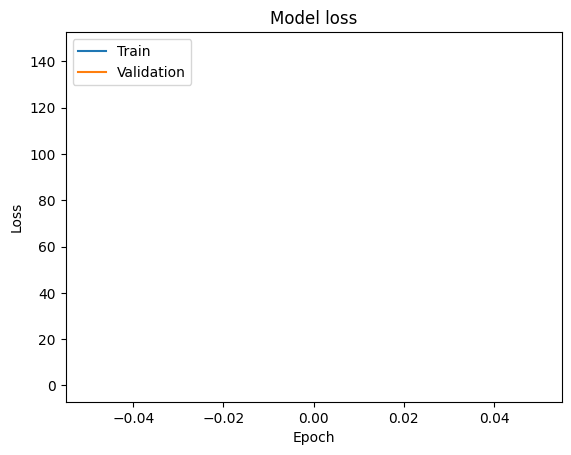

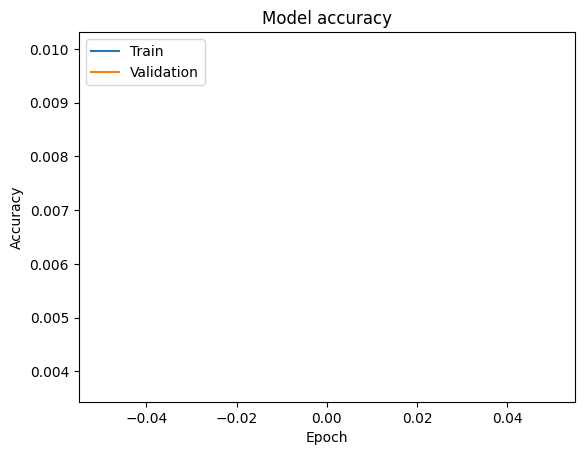

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V1\sub10\assets


Completed ROI:  V1 sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 249)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 249)
X_val shape:  (100, 900)
y_val shape:  (100, 249)
25/25 [==============================] - 1s 17ms/step - loss: 111.0347 - accuracy: 0.0050 - val_loss: 0.2417 - val_accuracy: 0.0000e+00
Model: "sequential_92"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_276 (Dense)           (None, 683)               615383    
                                                                 
 dense_277 (Dense)           (None, 466)               318744    
                                                      

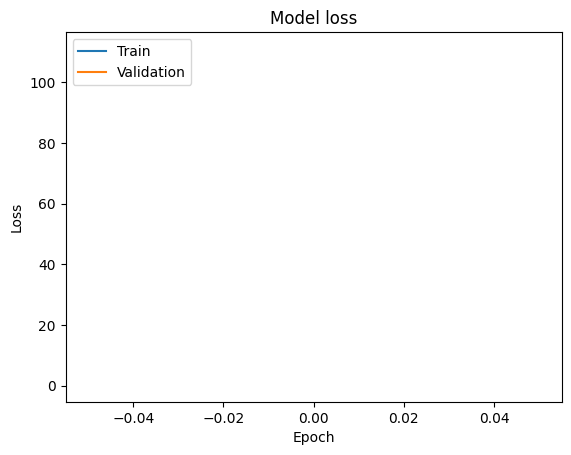

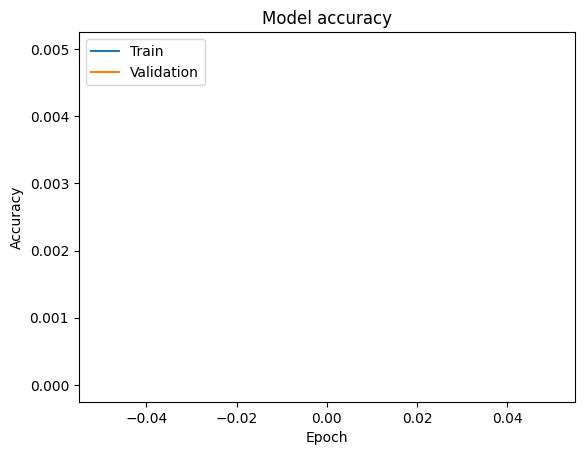

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V2\sub10\assets


Completed ROI:  V2 sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 188)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 188)
X_val shape:  (100, 900)
y_val shape:  (100, 188)
25/25 [==============================] - 1s 15ms/step - loss: 141.0444 - accuracy: 0.0012 - val_loss: 0.2419 - val_accuracy: 0.0000e+00
Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_279 (Dense)           (None, 662)               596462    
                                                                 
 dense_280 (Dense)           (None, 425)               281775    
                                                      

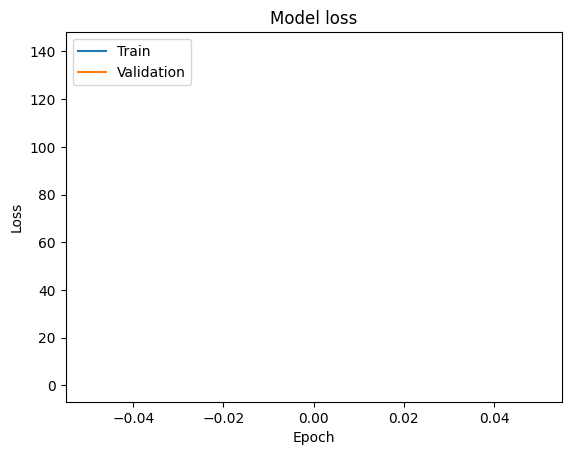

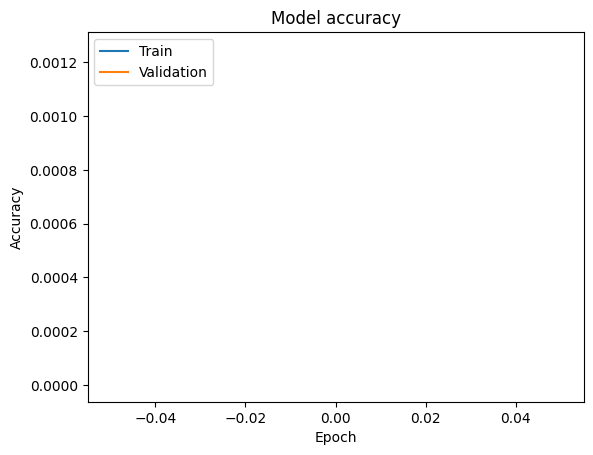

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V3\sub10\assets


Completed ROI:  V3 sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 60)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 60)
X_val shape:  (100, 900)
y_val shape:  (100, 60)
25/25 [==============================] - 1s 17ms/step - loss: 229.9993 - accuracy: 0.0188 - val_loss: 9.7816 - val_accuracy: 0.0500
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_282 (Dense)           (None, 620)               558620    
                                                                 
 dense_283 (Dense)           (None, 340)               211140    
                                                             

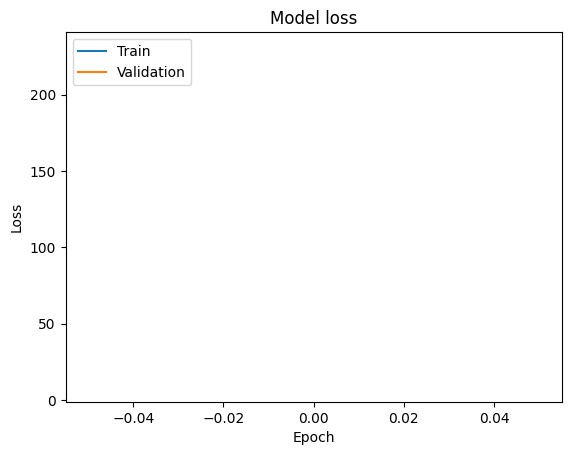

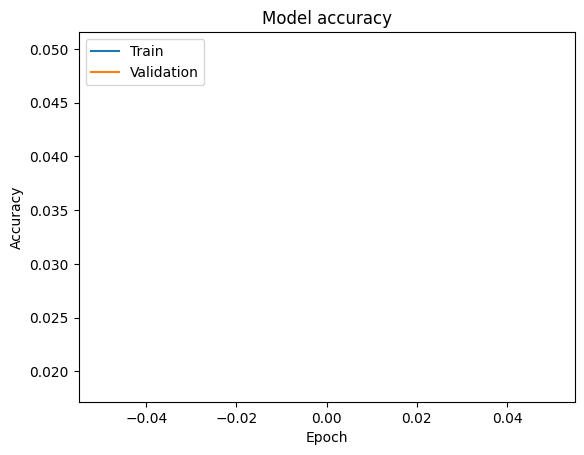

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\V4\sub10\assets


Completed ROI:  V4 sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  LOC sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 1034)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 1034)
X_val shape:  (100, 900)
y_val shape:  (100, 1034)
25/25 [==============================] - 1s 21ms/step - loss: 54.4931 - accuracy: 0.0012 - val_loss: 0.2435 - val_accuracy: 0.0000e+00
Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_285 (Dense)           (None, 944)               850544    
                                                                 
 dense_286 (Dense)           (None, 989)               934605    
                                                   

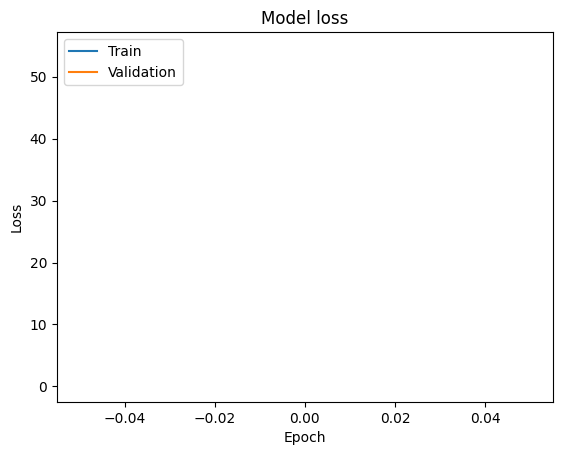

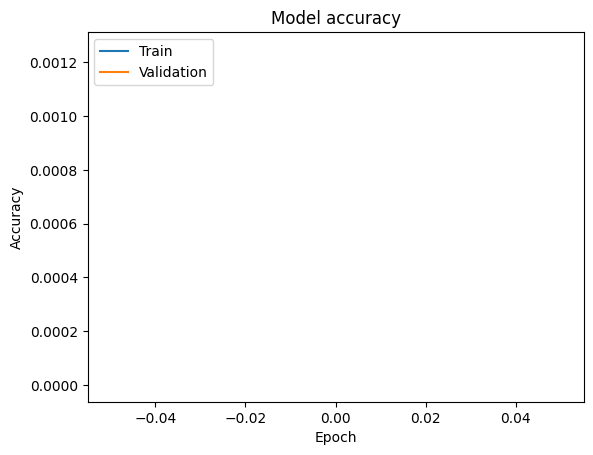

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\LOC\sub10\assets


Completed ROI:  LOC sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  EBA sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 162)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 162)
X_val shape:  (100, 900)
y_val shape:  (100, 162)
25/25 [==============================] - 1s 12ms/step - loss: 127.7270 - accuracy: 0.0050 - val_loss: 0.2652 - val_accuracy: 0.0000e+00
Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_288 (Dense)           (None, 654)               589254    
                                                                 
 dense_289 (Dense)           (None, 408)               267240    
                                                    

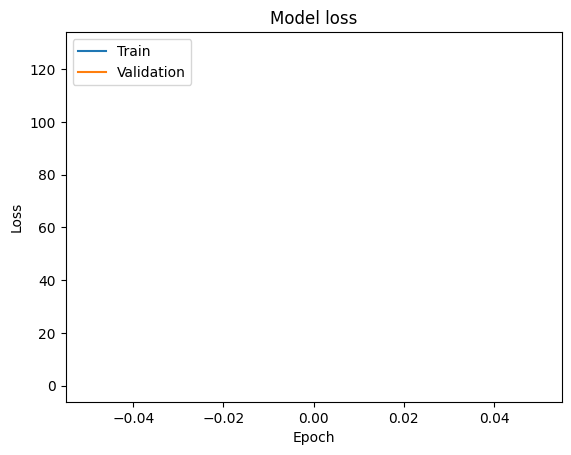

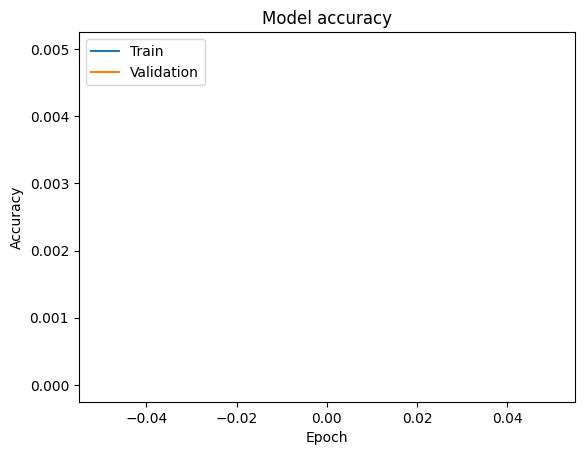

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\EBA\sub10\assets


Completed ROI:  EBA sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  FFA sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 69)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 69)
X_val shape:  (100, 900)
y_val shape:  (100, 69)
25/25 [==============================] - 3s 119ms/step - loss: 239.6234 - accuracy: 0.0100 - val_loss: 12.4976 - val_accuracy: 0.0100
Model: "sequential_97"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_291 (Dense)           (None, 623)               561323    
                                                                 
 dense_292 (Dense)           (None, 346)               215904    
                                                         

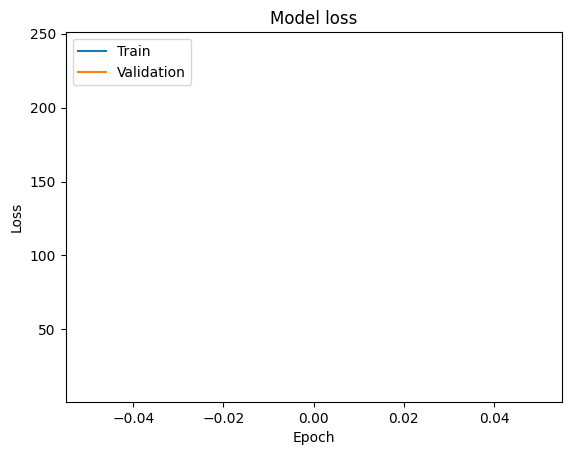

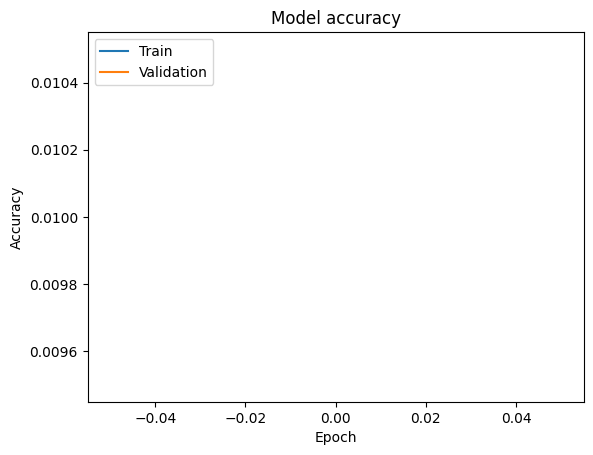

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\FFA\sub10\assets


Completed ROI:  FFA sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  STS sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 120)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 120)
X_val shape:  (100, 900)
y_val shape:  (100, 120)
25/25 [==============================] - 1s 15ms/step - loss: 195.1915 - accuracy: 0.0100 - val_loss: 0.2668 - val_accuracy: 0.0000e+00
Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_294 (Dense)           (None, 640)               576640    
                                                                 
 dense_295 (Dense)           (None, 380)               243580    
                                                    

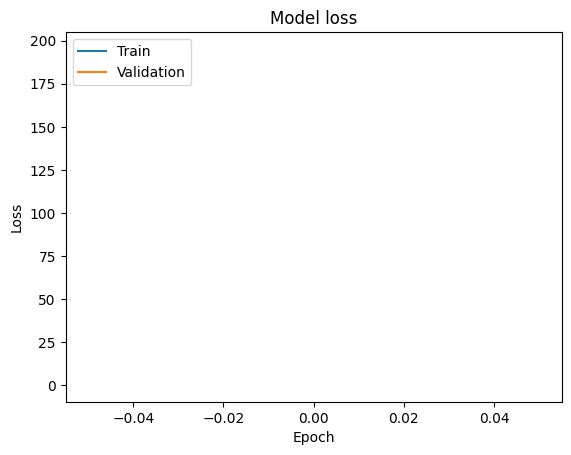

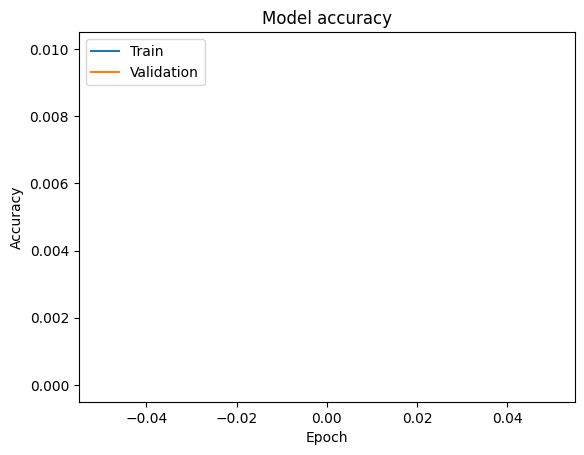

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\STS\sub10\assets


Completed ROI:  STS sub:  sub10
----------------------------------------------------------------------------
Starting ROI:  PPA sub:  sub10
C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\PCA\stage_4
(5, 30, 30)
(1000, 30, 30)
fmri_train_al (1000, 165)
train_activations (1000, 30, 30)
X_train shape:  (800, 900)
y_train shape:  (800, 165)
X_val shape:  (100, 900)
y_val shape:  (100, 165)
25/25 [==============================] - 1s 16ms/step - loss: 145.5916 - accuracy: 0.0063 - val_loss: 0.1937 - val_accuracy: 0.0000e+00
Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_297 (Dense)           (None, 655)               590155    
                                                                 
 dense_298 (Dense)           (None, 410)               268960    
                                                    

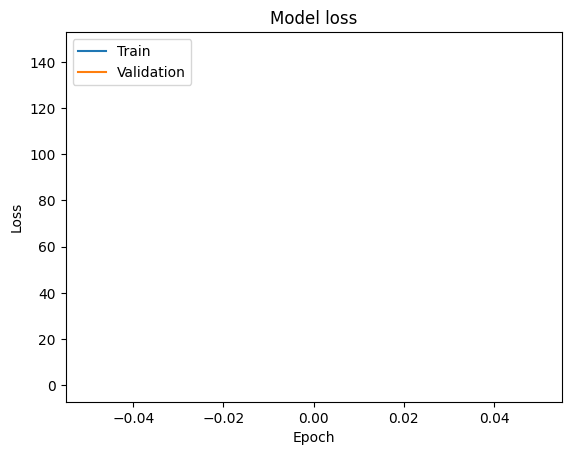

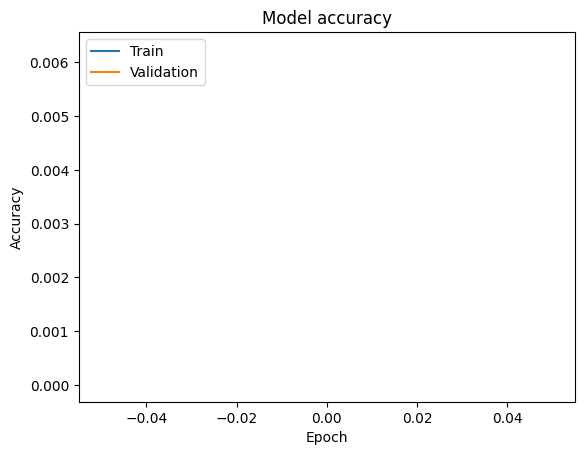

C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub10
INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub10\assets


INFO:tensorflow:Assets written to: C:\Users\julia\OneDrive - CBS - Copenhagen Business School\Documents\Master\Semester3\AdvancedML\Brainvision_Project\models\stage_4\PPA\sub10\assets


Completed ROI:  PPA sub:  sub10
----------------------------------------------------------------------------


In [8]:
# define directories for PCA and fmri data (repo_root necessary for runs in Ucloud)
repo_root = find_repo_root()
pca_dir = os.path.join(repo_root, "PCA")

fmri_dir =  os.path.join(repo_root, "participants_data_v2021")

prediction_dir = os.path.join(repo_root, "participants_data_v2021")

# specify layer manually: in ["stage_1", "stage_2", "stage_3", "stage_4", "stage_5", "final"]
layer = 'stage_4'

subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]
ROIs = ["WB", "V1", "V2","V3", "V4", "LOC", "EBA", "FFA","STS", "PPA"]
for sub in subs:
  for ROI in ROIs:
    if ROI == "WB":
        track = "full_track"
    else:
        track = "mini_track"

    # ToDo: implement saving of prediction scores (after model construction to save prediction scores for each sub & ROI)
    # specify directory to save prediction scores
    results_dir = os.path.join(prediction_dir, layer, ROI, sub)  
    if not os.path.exists(results_dir):
      os.makedirs(results_dir)
    
    print ("Starting ROI: ", ROI, "sub: ",sub)
    perform_encoding(pca_dir, fmri_dir,
                     results_dir, sub, layer,
                     ROI=ROI,mode='val')  # mode: 'val' for model training/selection, 'test' for obtaining evaluation metrics
    print ("Completed ROI: ", ROI, "sub: ",sub)
    print("----------------------------------------------------------------------------")